# Final Plots? 

Trying synthesize the final plots for the paper from all the other previous notebooks 

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 40

# update various fontsizes to match
params = {'figure.figsize': (20, 14),
          'legend.fontsize': 20,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 16,
          'xtick.minor.size': 13,
          'ytick.major.size': 16,
          'ytick.minor.size': 13}
plt.rcParams.update(params)

import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList
import glob

import seaborn as sns
pal = sns.color_palette("pastel")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from scipy.stats import kendalltau
from seaborn.algorithms import bootstrap

# ur gonna need this boi
import matplotlib as mpl

import statistics as stat

from lifelines import KaplanMeierFitter

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [2]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

## Bringing in and Organizing all the Data Tables 

In [3]:
#Bring in all the COS-Holes fit data and modifying
cosholes_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/cosholes_df.csv')
#cosholes_df

In [4]:
#DATA frame for just the upper limits 

up_ch = cosholes_df.loc[(cosholes_df['uplim'] == 0)]
#up_ch

#Df of just the sums for the whole data set (use this for everything but the relative velocity plot) with no uplims 

sum_ch = cosholes_df.loc[(cosholes_df['comp'] > 0) & (cosholes_df['uplim'] == 1)]
#sum_ch

#Df of all the components for the whole data set (use this for just the relative velocity plot) with no uplims 
com_ch = cosholes_df.loc[(cosholes_df['comp'] < 2) & (cosholes_df['uplim'] == 1)]
#com_ch

In [5]:
cos_sup = pd.concat([sum_ch, up_ch])
cos_sup = cos_sup.drop(['galaxy', 'zgal', 'Mhalo', 'SFR', 'vrel', 'line', 'wav', 'zsys', 'b', 'sigb', 'vel', 'sigvel', 'comp', 'Vhelio [km/s]'], axis=1)
cos_sup

QSO    MBH  sigMBH     M*       Rproj       Rvir  Rproj/Rvir          N  \
0   J1101  6.770   0.065  10.20  110.019140  273.43553    0.402359  13.403000   
1   J1159  8.255   0.125  10.43   37.385240  314.35077    0.118928  13.697000   
4   J1249  6.830   0.123  10.62   25.520224  363.76792    0.070155  14.311323   
8   J1051  8.400   0.071  10.79   40.499140  431.64653    0.093825  13.990000   
9   J1123  6.920   0.048  10.84  119.976000  458.29968    0.261785  14.012000   
10  J0246  8.140   0.090  10.50   55.657239  330.32571    0.168492  14.211000   
2   J1220  7.577   0.030  10.88   69.778997  482.42196    0.144643  13.650000   
3   J1222  7.577   0.030  10.88  130.305660  482.42196    0.270107  13.500000   
11  J1235  7.940   0.145  10.40  123.078500  308.12739    0.399440  13.380000   

        sigN  uplim  
0   0.099000      1  
1   0.074000      1  
4   0.123487      1  
8   0.057000      1  
9   0.076000      1  
10  0.053000      1  
2   0.050000      0  
3   0.050000      0  
11  0.050000      0

In [6]:
#M31 Data (Project AMIGA) Detections (and taking out the MS contaminations) 

amiga_2_det_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_det_sum.csv')
amiga_2_det_sum = amiga_2_det_sum.loc[(amiga_2_det_sum['sumlogN']!= 0)]
amiga_2_det_sum = amiga_2_det_sum.loc[amiga_2_det_sum['MS']==0]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
#making sure to use r200 as a substitute for since that is what we used 
amiga_m31_rvrir = 230 #kpc This is the value used for R200 in the paper? 

amiga_det_R = np.array(amiga_2_det_sum['Rad'])
amiga_det_RRvir = amiga_det_R/amiga_m31_rvrir

#amiga_2_det_sum

In [7]:
#M31 Data (Project AMIGA) non-detections (upper limits) and taking out the MS contamination
amiga_2_up_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_up_sum.csv')
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['sumlogN']!= 0)]
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['MS']== 0)]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
amiga_up_R = np.array(amiga_2_up_sum['Rad'])
amiga_up_RRvir = amiga_up_R/amiga_m31_rvrir

#amiga_2_up_sum

In [8]:
#making arrays of AMIGA MBH and error so that I can add to df 

#dets 
MBH_amiga = np.full(11, 8.15)
sigMBH_amiga = np.full(11, 0.24)
mstar_amiga = np.full(11, 10.3)
rvir_amiga = np.full(11,230)
uplim = np.full(11,1)

#ups
MBH_amiga_up = np.full(12, 8.15)
sigMBH_amiga_up = np.full(12, 0.24)
mstar_amiga_up = np.full(12, 10.3)
rvir_amiga_up = np.full(12,230)
uplim_up = np.full(12,0)

In [9]:
amiga_det = amiga_2_det_sum.drop(['index', 'z', 'RAdeg', 'Decdeg', 'ion', 'b_Vel', 'B_Vel', 'Vel', 'e_V', 'E_logN', 'e_logN', 'MS', 'sumlogN', 'f_logN'],axis=1)

amiga_det['amiga_det_RRvir'] = amiga_det_RRvir.tolist()
amiga_det['MBH_amiga'] = MBH_amiga.tolist()
amiga_det['sigMBH_amiga'] = sigMBH_amiga.tolist()
amiga_det['mstar_amiga'] = mstar_amiga.tolist()
amiga_det['rvir_amiga'] = rvir_amiga.tolist()
amiga_det['uplim'] = uplim.tolist()

amiga_det = amiga_det.rename(columns={'QSO': 'QSO', 'Rad': 'Rproj', 'logN': 'N', 'sum_elogN': 'sigN', 
                                      'amiga_det_RRvir': 'Rproj/Rvir', 'MBH_amiga': 'MBH', 'sigMBH_amiga': 'sigMBH', 'mstar_amiga': 'M*', 
                                     'rvir_amiga': 'Rvir','uplim': 'uplim'})

amiga_det = amiga_det.iloc[:,[0,5,6,7,1,8,4,2,3,9]]

#amiga_det
amiga_det = amiga_det.loc[(amiga_det['Rproj/Rvir'] <= 0.8)]

In [22]:
np.mean(amiga_det['N'])

13.4875

In [23]:
np.mean(amiga_up['N'])

13.014

In [24]:
amiga_up = amiga_2_up_sum.drop(['index', 'z', 'RAdeg', 'Decdeg', 'ion', 'b_Vel', 'B_Vel', 'Vel', 'e_V', 'E_logN', 'e_logN', 'MS', 'sumlogN', 'f_logN'],axis=1)

amiga_up['amiga_up_RRvir'] = amiga_up_RRvir.tolist()
amiga_up['MBH_amiga_up'] = MBH_amiga_up.tolist()
amiga_up['sigMBH_amiga_up'] = sigMBH_amiga_up.tolist()
amiga_up['mstar_amiga_up'] = mstar_amiga_up.tolist()
amiga_up['rvir_amiga_up'] = rvir_amiga_up.tolist()
amiga_up['uplim_up'] = uplim_up.tolist()

amiga_up = amiga_up.rename(columns={'QSO': 'QSO', 'Rad': 'Rproj', 'logN': 'N', 'sum_elogN': 'sigN',
                                      'amiga_up_RRvir': 'Rproj/Rvir', 'MBH_amiga_up': 'MBH', 'sigMBH_amiga_up': 'sigMBH', 
                                    'mstar_amiga_up': 'M*', 'rvir_amiga_up': 'Rvir', 'uplim_up': 'uplim'})

amiga_up = amiga_up.iloc[:,[0,5,6,7,1,8,4,2,3,9]]

#amiga_up
amiga_up = amiga_up.loc[(amiga_up['Rproj/Rvir'] <= 0.8)]

In [25]:
amiga_sup = pd.concat([amiga_det, amiga_up])
amiga_sup = amiga_sup.loc[(amiga_sup['Rproj/Rvir'] <= 0.8)]
amiga_sup

QSO   MBH  sigMBH    M*  Rproj  Rvir  Rproj/Rvir      N  \
3        HS0033+4300  8.15    0.24  10.3   30.5   230    0.132609  14.10   
4        HS0058+4213  8.15    0.24  10.3   48.6   230    0.211304  13.33   
6    RX_J0043.6+3725  8.15    0.24  10.3   50.5   230    0.219565  13.85   
7          Zw535.012  8.15    0.24  10.3   59.7   230    0.259565  12.99   
9    RX_J0050.8+3536  8.15    0.24  10.3   77.1   230    0.335217  13.45   
10  IRAS_F00040+4325  8.15    0.24  10.3   93.0   230    0.404348  13.23   
12            MRK352  8.15    0.24  10.3  131.7   230    0.572609  13.50   
15            KAZ238  8.15    0.24  10.3  150.2   230    0.653043  13.45   
1    RX_J0043.6+3725  8.15    0.24  10.3   50.5   230    0.219565  12.92   
5   RXS_J0118.8+3836  8.15    0.24  10.3   97.2   230    0.422609  12.90   
7    RX_J0028.1+3103  8.15    0.24  10.3  139.1   230    0.604783  13.11   
10       FBS0150+396  8.15    0.24  10.3  175.5   230    0.763043  13.18   
11            3C48.0  8.15    0.24  10.3  177.9   230    0.773478  12.96   

        sigN  uplim  
3   0.050000      1  
4   0.183848      1  
6   0.030000      1  
7   0.300167      1  
9   0.070000      1  
10  0.106301      1  
12  0.152971      1  
15  0.136015      1  
1   0.300000      0  
5   0.420000      0  
7   0.420000      0  
10  0.300000      0  
11  0.300000      0

In [26]:
w = np.array([0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25])

In [27]:
amiga_sup_w = amiga_sup
amiga_sup_w['w'] = w.tolist()

In [28]:
amiga_sup_w

QSO   MBH  sigMBH    M*  Rproj  Rvir  Rproj/Rvir      N  \
3        HS0033+4300  8.15    0.24  10.3   30.5   230    0.132609  14.10   
4        HS0058+4213  8.15    0.24  10.3   48.6   230    0.211304  13.33   
6    RX_J0043.6+3725  8.15    0.24  10.3   50.5   230    0.219565  13.85   
7          Zw535.012  8.15    0.24  10.3   59.7   230    0.259565  12.99   
9    RX_J0050.8+3536  8.15    0.24  10.3   77.1   230    0.335217  13.45   
10  IRAS_F00040+4325  8.15    0.24  10.3   93.0   230    0.404348  13.23   
12            MRK352  8.15    0.24  10.3  131.7   230    0.572609  13.50   
15            KAZ238  8.15    0.24  10.3  150.2   230    0.653043  13.45   
1    RX_J0043.6+3725  8.15    0.24  10.3   50.5   230    0.219565  12.92   
5   RXS_J0118.8+3836  8.15    0.24  10.3   97.2   230    0.422609  12.90   
7    RX_J0028.1+3103  8.15    0.24  10.3  139.1   230    0.604783  13.11   
10       FBS0150+396  8.15    0.24  10.3  175.5   230    0.763043  13.18   
11            3C48.0  8.15    0.24  10.3  177.9   230    0.773478  12.96   

        sigN  uplim     w  
3   0.050000      1  0.75  
4   0.183848      1  0.75  
6   0.030000      1  0.75  
7   0.300167      1  0.75  
9   0.070000      1  0.75  
10  0.106301      1  0.75  
12  0.152971      1  0.75  
15  0.136015      1  0.75  
1   0.300000      0  0.25  
5   0.420000      0  0.25  
7   0.420000      0  0.25  
10  0.300000      0  0.25  
11  0.300000      0  0.25

In [29]:
np.average(amiga_sup_w['N'], weights = amiga_sup_w['w'])

13.405862068965517

In [30]:
np.average(amiga_sup_w['sigN'], weights = amiga_sup_w['w'])

0.16647942745862065

In [31]:
np.average(amiga_sup_w['Rproj/Rvir'])

0.4285953177257525

In [32]:
np.average(amiga_sup_w['Rvir'])

230.0

In [33]:
#Mean Project AMIGA Literature Point    

amiga = {'QSO': ['M31'],
            'MBH': [8.15],
            'sigMBH': [0.24],
            'M*': [10.3], 
            'Rproj': [98.58], 
            'Rvir': [230],
               'Rproj/Rvir': [0.43],
               'N': [13.41],
               'sigN': [0.17], 
           'uplim': [1]}
AMIGA = pd.DataFrame(data=amiga)

In [34]:
#Borthakur 2013 Data
#https://iopscience.iop.org/article/10.1088/0004-637X/768/1/18/pdf

borthakur = pd.read_csv("/Users/samgarza/Documents/COS-Holes/notebooks/borthakur_2013.csv", sep=",")   
borthakur.sort_values('det', inplace=True)
#borthakur

#remove the zero value in the df 
borthakur_no_zero = borthakur.drop(labels=12, axis=0)
#print(borthakur_no_zero)

########################################################

#Bordoloi 2014 Data 
#https://iopscience.iop.org/article/10.1088/0004-637X/796/2/136/pdf

bordoloi = pd.read_csv("/Users/samgarza/Documents/COS-Holes/notebooks/bordoloi_2014_CIV.csv", sep=",") 
bordoloi.sort_values('det', inplace=True)
#bordoloi

########################################################

#COS-Halos    

coshalos = {'QSO': ['J0910', 'J1619'],
            'sigMBH': [0.5, 0.5],
            'M*': [10.61, 10.10], 
            'Rproj': [112, 97], 
            'Rvir': [329, 249],
               'Rproj/Rvir': [0.34, 0.39],
               'N': [14.10, 13.90],
               'sigN': [0.09, 0.03], 
           'uplim': [1,1]}
COSHALOS = pd.DataFrame(data=coshalos)

### Setting up Stellar Mass Bins 

Since we are still seeing a null result I want to investigate how the stellar mass may be impacting the sample so will split the larger sample into a stellar mass bin that only has values between 10^10-11 and use data from 0-150 kpc (since that is where we see the most "consistency")

In [35]:
####### BORTHAKUR ######### => Only has high stellar mass bin values 

borthakur_less150 = borthakur_no_zero.loc[(borthakur_no_zero['rhokpc[i]'] <= 150)]
#borthakur_less150
borthakur_high = borthakur_less150.loc[(borthakur_less150['mstar[i]'] >= 10) & (borthakur_less150['mstar[i]'] <= 11)]
borthakur_high

galname[i]  mstar[i]  alog10(mhalo[i])    rvir[i]  rhokpc[i]  \
16  J154527.12+484642.2     10.50         12.029020  330.32571       64.7   
13  J132150.89+033034.1     10.81         12.408067  441.86569      140.2   
8   J102846.43+391842.9     10.50         12.029020  330.32571       88.7   
14  J140502.20+470525.9     10.43         11.964435  314.35077      146.9   

    rhokpc[i]/rvir[i]  logNCIV[i]   err  det  
16           0.195867       13.79  0.00    0  
13           0.317291       14.06  0.00    0  
8            0.268523       14.65  0.04    1  
14           0.467312       14.25  0.08    1

In [36]:
####### BORDOLOI ######### 

bordoloi_less150 = bordoloi.loc[(bordoloi['R[kpc]'] <= 150) & (bordoloi['logM*'] >= 9) ]
#bordoloi_less150

#separating into the stellar mass sample: 10-11
#bordoloi_low = bordoloi_less150.loc[(bordoloi_less150['logM*'] >= 9) & (bordoloi_less150['logM*'] < 10)]
    #Due to the new stellar mass bin idea, we don't need the bordoloi low
bordoloi_high = bordoloi_less150.loc[(bordoloi_less150['logM*'] >= 10.0) & (bordoloi_less150['logM*'] <= 11.0)]

bordoloi_high

QSO  logNCIV   err  det  logM*  R[kpc]  Rvir[kpc]    R/Rvir
25   J1211+3657    13.17  0.00    0   10.1      90        272  0.330882
26   J1121+0325    13.45  0.00    0   10.1      89        277  0.321300
1   J09525+4535    13.56  0.06    1   10.0      95        259  0.366795
15   PG1202+281    13.58  0.10    1   10.0      92        254  0.362205
12   J0959+0503    14.69  0.00    2   10.0      14        247  0.056680

### Using the Velocity Dispersions of the Galaxy to calculate the MBH for each of our literature values

In [37]:
gals = fits.open('/Users/samgarza/Dropbox/COS-Holes/ArchivalData/gal_info_dr7_v5_2.fit')
gals.info()

Filename: /Users/samgarza/Dropbox/COS-Holes/ArchivalData/gal_info_dr7_v5_2.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     67   927552R x 25C   [I, J, I, 5I, E, E, 5E, I, I, 19A, 6A, 21A, E, E, I, E, E, E, E, E, E, 3E, 3E, 5E, 12A]   


In [38]:
gal_data = gals[1].data

In [39]:
#Values that I need to search for the vdisps for the specific galaxy/qso using from literature 

#BORDOLOI VALUES 
pids = np.array([2105, 511, 833, 2227, 995])
mjds = np.array([53472, 52636, 52314, 53820, 52731])
fids = np.array([407, 449, 104, 491, 208])

#BORTHAKUR VALUES 

pids_borth = np.array([1167, 526, 1430, 1285])
mjds_borth = np.array([52738, 52312, 53002, 52723])
fids_borth = np.array([638, 529, 237, 37])

In [40]:
#For Bordoloi
vdisps = []
vdisps_err = []

for i in range(len(pids)): 
    #Plate ID
    mask = gal_data.PLATEID == pids[i]
    check = gal_data[mask]

    #MJD
    mask2 = check.MJD == mjds[i]
    check = check[mask2]

    #FIBERID
    mask3 = check.FIBERID == fids[i]
    test = check[mask3]
    print(test.shape)
    
    print(f'V_DISP: {test.V_DISP}, V_DISP_ERR:{test.V_DISP_ERR}')
    
    vdisps.append(test.V_DISP)
    vdisps_err.append(test.V_DISP_ERR)
    
vdisps = np.array(vdisps)
vdisps = vdisps.reshape(5,)
#vdisps

vdisps_err = np.array(vdisps_err)
vdisps_err = vdisps_err.reshape(5,)
#vdisps_err

(1,)
V_DISP: [57.136898], V_DISP_ERR:[13.070264]
(1,)
V_DISP: [41.15367], V_DISP_ERR:[9.7062435]
(1,)
V_DISP: [43.57293], V_DISP_ERR:[7.5054946]
(1,)
V_DISP: [33.40527], V_DISP_ERR:[16.83185]
(1,)
V_DISP: [77.021416], V_DISP_ERR:[17.392845]


In [41]:
#For Borthakur
vdisps_borth = []
vdisps_err_borth = []

for i in range(len(pids_borth)): 
    #Plate ID
    mask = gal_data.PLATEID == pids_borth[i]
    check = gal_data[mask]

    #MJD
    mask2 = check.MJD == mjds_borth[i]
    check = check[mask2]

    #FIBERID
    mask3 = check.FIBERID == fids_borth[i]
    test = check[mask3]
    print(test.shape)
    
    print(f'V_DISP: {test.V_DISP}, V_DISP_ERR:{test.V_DISP_ERR}')
    
    vdisps_borth.append(test.V_DISP)
    vdisps_err_borth.append(test.V_DISP_ERR)
    
vdisps_borth = np.array(vdisps_borth)
vdisps_borth = vdisps_borth.reshape(4,)
#vdisps

vdisps_err_borth = np.array(vdisps_err_borth)
vdisps_err_borth = vdisps_err_borth.reshape(4,)
#vdisps_err

(1,)
V_DISP: [76.28716], V_DISP_ERR:[17.076445]
(1,)
V_DISP: [148.91199], V_DISP_ERR:[7.8888116]
(1,)
V_DISP: [121.198685], V_DISP_ERR:[18.669765]
(1,)
V_DISP: [134.5503], V_DISP_ERR:[24.878817]


#### Using Equation (7) from Piotrowska et al 2022 to take the velocity dispersions that we just found and get the MBH 
(https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.1052P/abstract)

In [42]:
#BORDOLOI MBH AND ERROR
logMBH_bord = (5.246 * np.log10(vdisps)) - 3.77 #epsilon = 0.417
#logMBH_bord

logMBH_bord_err_down = (5.246 * np.log10(vdisps - vdisps_err)) - 3.77 #epsilon = 0.417
#logMBH_bord_err_down

logMBH_bord_err_up = (5.246 * np.log10(vdisps + vdisps_err)) - 3.77 #epsilon = 0.417
#logMBH_bord_err_up

logMBH_bord_err = (logMBH_bord_err_down+logMBH_bord_err_up)/2
#logMBH_bord_err

In [43]:
#BORDOLOI MBH AND ERROR
logMBH_borth = (5.246 * np.log10(vdisps_borth)) - 3.77 #epsilon = 0.417
#logMBH_borth

logMBH_borth_err_down = (5.246 * np.log10(vdisps_borth - vdisps_err_borth)) - 3.77 #epsilon = 0.417
#logMBH_borth_err_down

logMBH_borth_err_up = (5.246 * np.log10(vdisps_borth + vdisps_err_borth)) - 3.77 #epsilon = 0.417
#logMBH_borth_err_up

logMBH_borth_err = (logMBH_borth_err_down+logMBH_borth_err_up)/2
#logMBH_borth_err

In [44]:
#COS-Halos MBH

vdisp_halos = np.array([154, 78])

logMBH_halo = (5.246 * np.log10(vdisp_halos)) - 3.77 #epsilon = 0.417
logMBH_halo

array([7.7057337 , 6.15592829])

In [45]:
#Adding the mbhs to the literature tables (that have been shortened due to stellar mass) 

#For the sum values 
mini_borth= {'MBH': logMBH_borth,
             'MBH_err': logMBH_borth_err}
mini_borth = pd.DataFrame(data=mini_borth)
#mini_borth

In [46]:
#For the sum values 
mini_bord= {'MBH': logMBH_bord,
             'MBH_err': logMBH_bord_err}
mini_bord = pd.DataFrame(data=mini_bord)
#mini_bord

In [47]:
#All the data for Borthakur
borthakur_new = pd.concat([borthakur_high.reset_index(drop=True), mini_borth], axis=1)
#borthakur_new

borth_sup = borthakur_new.drop(['alog10(mhalo[i])'], axis=1)
borth_sup = borth_sup.rename(columns={"galname[i]": "QSO", "MBH": "MBH", "MBH_err": "sigMBH","mstar[i]": "M*",
                         "rhokpc[i]": "Rproj", "rvir[i]": "Rvir", "rhokpc[i]/rvir[i]": "Rproj/Rvir",
                         "logNCIV[i]": "N", "err": "sigN", "det": "uplim",})
borth_sup = borth_sup.iloc[:,[0,8,9,1,3,2,4,5,6,7]]
borth_sup

QSO       MBH    sigMBH     M*  Rproj       Rvir  \
0  J154527.12+484642.2  6.105340  6.046782  10.50   64.7  330.32571   
1  J132150.89+033034.1  7.629189  7.625987  10.81  140.2  441.86569   
2  J102846.43+391842.9  7.160030  7.132673  10.50   88.7  330.32571   
3  J140502.20+470525.9  7.398128  7.358500  10.43  146.9  314.35077   

   Rproj/Rvir      N  sigN  uplim  
0    0.195867  13.79  0.00      0  
1    0.317291  14.06  0.00      0  
2    0.268523  14.65  0.04      1  
3    0.467312  14.25  0.08      1

In [48]:
#Split into det and non det 

borth_det = borth_sup.loc[(borthakur_new['det'] == 1)]
#borth_det

borth_uplim = borth_sup.loc[(borthakur_new['det'] == 0)]
#borth_uplim

In [49]:
#All the data for Bordoloi
bordoloi_new = pd.concat([bordoloi_high.reset_index(drop=True), mini_bord], axis=1)
#bordoloi_new

bord_sup = bordoloi_new.rename(columns={"QSO": "QSO", "logNCIV": "N", "err": "sigN","det": "uplim",
                         "logM*": "M*", "R[kpc]": "Rproj", "Rvir[kpc]": "Rvir",
                         "R/Rvir": "Rproj/Rvir", "MBH": "MBH", "MBH_err": "sigMBH",})
bord_sup = bord_sup.iloc[:,[0,8,9,4,5,6,7,1,2,3]]
bord_sup

QSO       MBH    sigMBH    M*  Rproj  Rvir  Rproj/Rvir      N  \
0   J1211+3657  5.446784  5.385558  10.1     90   272    0.330882  13.17   
1   J1121+0325  4.699188  4.633988  10.1     89   277    0.321300  13.45   
2  J09525+4535  4.829331  4.795020  10.0     95   259    0.366795  13.56   
3   PG1202+281  4.223933  3.890306  10.0     92   254    0.362205  13.58   
4   J0959+0503  6.127163  6.067540  10.0     14   247    0.056680  14.69   

   sigN  uplim  
0  0.00      0  
1  0.00      0  
2  0.06      1  
3  0.10      1  
4  0.00      2

In [50]:
bord_det = bord_sup.loc[(bordoloi_new['det'] == 1)]
#bord_det

bord_uplim = bord_sup.loc[(bordoloi_new['det'] == 0)]
#bord_uplim

bord_lolim = bord_sup.loc[(bordoloi_new['det'] == 2)]
#bord_lolim

In [51]:
COSHALOS.insert(loc = 1,
          column = 'MBH',
          value = logMBH_halo)
COSHALOS

QSO       MBH  sigMBH     M*  Rproj  Rvir  Rproj/Rvir     N  sigN  uplim
0  J0910  7.705734     0.5  10.61    112   329        0.34  14.1  0.09      1
1  J1619  6.155928     0.5  10.10     97   249        0.39  13.9  0.03      1

In [67]:
coslit = pd.concat([cos_sup, borth_sup, bord_sup, COSHALOS, AMIGA])

coslit = coslit.reset_index(drop=True)

coslit

QSO       MBH    sigMBH     M*       Rproj       Rvir  \
0                 J1101  6.770000  0.065000  10.20  110.019140  273.43553   
1                 J1159  8.255000  0.125000  10.43   37.385240  314.35077   
2                 J1249  6.830000  0.123000  10.62   25.520224  363.76792   
3                 J1051  8.400000  0.071000  10.79   40.499140  431.64653   
4                 J1123  6.920000  0.048000  10.84  119.976000  458.29968   
5                 J0246  8.140000  0.090000  10.50   55.657239  330.32571   
6                 J1220  7.577000  0.030000  10.88   69.778997  482.42196   
7                 J1222  7.577000  0.030000  10.88  130.305660  482.42196   
8                 J1235  7.940000  0.145000  10.40  123.078500  308.12739   
9   J154527.12+484642.2  6.105340  6.046782  10.50   64.700000  330.32571   
10  J132150.89+033034.1  7.629189  7.625987  10.81  140.200000  441.86569   
11  J102846.43+391842.9  7.160030  7.132673  10.50   88.700000  330.32571   
12  J140502.20+470525.9  7.398128  7.358500  10.43  146.900000  314.35077   
13           J1211+3657  5.446784  5.385558  10.10   90.000000  272.00000   
14           J1121+0325  4.699188  4.633988  10.10   89.000000  277.00000   
15          J09525+4535  4.829331  4.795020  10.00   95.000000  259.00000   
16           PG1202+281  4.223933  3.890306  10.00   92.000000  254.00000   
17           J0959+0503  6.127163  6.067540  10.00   14.000000  247.00000   
18                J0910  7.705734  0.500000  10.61  112.000000  329.00000   
19                J1619  6.155928  0.500000  10.10   97.000000  249.00000   
20                  M31  8.150000  0.240000  10.30   98.580000  230.00000   

    Rproj/Rvir          N      sigN  uplim  
0     0.402359  13.403000  0.099000      1  
1     0.118928  13.697000  0.074000      1  
2     0.070155  14.311323  0.123487      1  
3     0.093825  13.990000  0.057000      1  
4     0.261785  14.012000  0.076000      1  
5     0.168492  14.211000  0.053000      1  
6     0.144643  13.650000  0.050000      0  
7     0.270107  13.500000  0.050000      0  
8     0.399440  13.380000  0.050000      0  
9     0.195867  13.790000  0.000000      0  
10    0.317291  14.060000  0.000000      0  
11    0.268523  14.650000  0.040000      1  
12    0.467312  14.250000  0.080000      1  
13    0.330882  13.170000  0.000000      0  
14    0.321300  13.450000  0.000000      0  
15    0.366795  13.560000  0.060000      1  
16    0.362205  13.580000  0.100000      1  
17    0.056680  14.690000  0.000000      2  
18    0.340000  14.100000  0.090000      1  
19    0.390000  13.900000  0.030000      1  
20    0.430000  13.410000  0.170000      1

In [68]:
coslit_det = coslit.loc[(coslit['uplim'] == 1)]

coslit_uplim = coslit.loc[(coslit['uplim'] == 0)]

coslit_lolim = coslit.loc[(coslit['uplim'] == 2)]

In [71]:
coslit_det = coslit_det.reset_index(drop=True)
#coslit_det

QSO       MBH    sigMBH     M*       Rproj       Rvir  \
0                 J1101  6.770000  0.065000  10.20  110.019140  273.43553   
1                 J1159  8.255000  0.125000  10.43   37.385240  314.35077   
2                 J1249  6.830000  0.123000  10.62   25.520224  363.76792   
3                 J1051  8.400000  0.071000  10.79   40.499140  431.64653   
4                 J1123  6.920000  0.048000  10.84  119.976000  458.29968   
5                 J0246  8.140000  0.090000  10.50   55.657239  330.32571   
6   J102846.43+391842.9  7.160030  7.132673  10.50   88.700000  330.32571   
7   J140502.20+470525.9  7.398128  7.358500  10.43  146.900000  314.35077   
8           J09525+4535  4.829331  4.795020  10.00   95.000000  259.00000   
9            PG1202+281  4.223933  3.890306  10.00   92.000000  254.00000   
10                J0910  7.705734  0.500000  10.61  112.000000  329.00000   
11                J1619  6.155928  0.500000  10.10   97.000000  249.00000   
12                  M31  8.150000  0.240000  10.30   98.580000  230.00000   

    Rproj/Rvir          N      sigN  uplim  
0     0.402359  13.403000  0.099000      1  
1     0.118928  13.697000  0.074000      1  
2     0.070155  14.311323  0.123487      1  
3     0.093825  13.990000  0.057000      1  
4     0.261785  14.012000  0.076000      1  
5     0.168492  14.211000  0.053000      1  
6     0.268523  14.650000  0.040000      1  
7     0.467312  14.250000  0.080000      1  
8     0.366795  13.560000  0.060000      1  
9     0.362205  13.580000  0.100000      1  
10    0.340000  14.100000  0.090000      1  
11    0.390000  13.900000  0.030000      1  
12    0.430000  13.410000  0.170000      1

In [72]:
coslit_uplim = coslit_uplim.reset_index(drop=True)
coslit_lolim = coslit_lolim.reset_index(drop=True)

## Okay finally Done getting the data all situated and now we can focus on the plots 

### IDEAS for FIG 3

In [204]:
low_mask, high_mask = (cosholes_df["MBH"] <= 7.577), (cosholes_df["MBH"] > 7.577)
low_mask_rr, high_mask_rr = (cosholes_df["Rproj/Rvir"] <= 0.25), (cosholes_df["Rproj/Rvir"] > 0.25)

#Creating masks for literature 

low_mask_lit, high_mask_lit = (coslit["MBH"] <= 7.577), (coslit["MBH"] > 7.577)

#Creating masks for literature individually bc the whole df wants to be a dick right now 

low_mask_borth, high_mask_borth = (borthakur_new["MBH"] <= 7.577), (borthakur_new["MBH"] > 7.577)
low_mask_bord, high_mask_bord = (bordoloi_new["MBH"] <= 7.577), (bordoloi_new["MBH"] > 7.577)
low_mask_halos, high_mask_halos = (COSHALOS["MBH"] <= 7.577), (COSHALOS["MBH"] > 7.577)

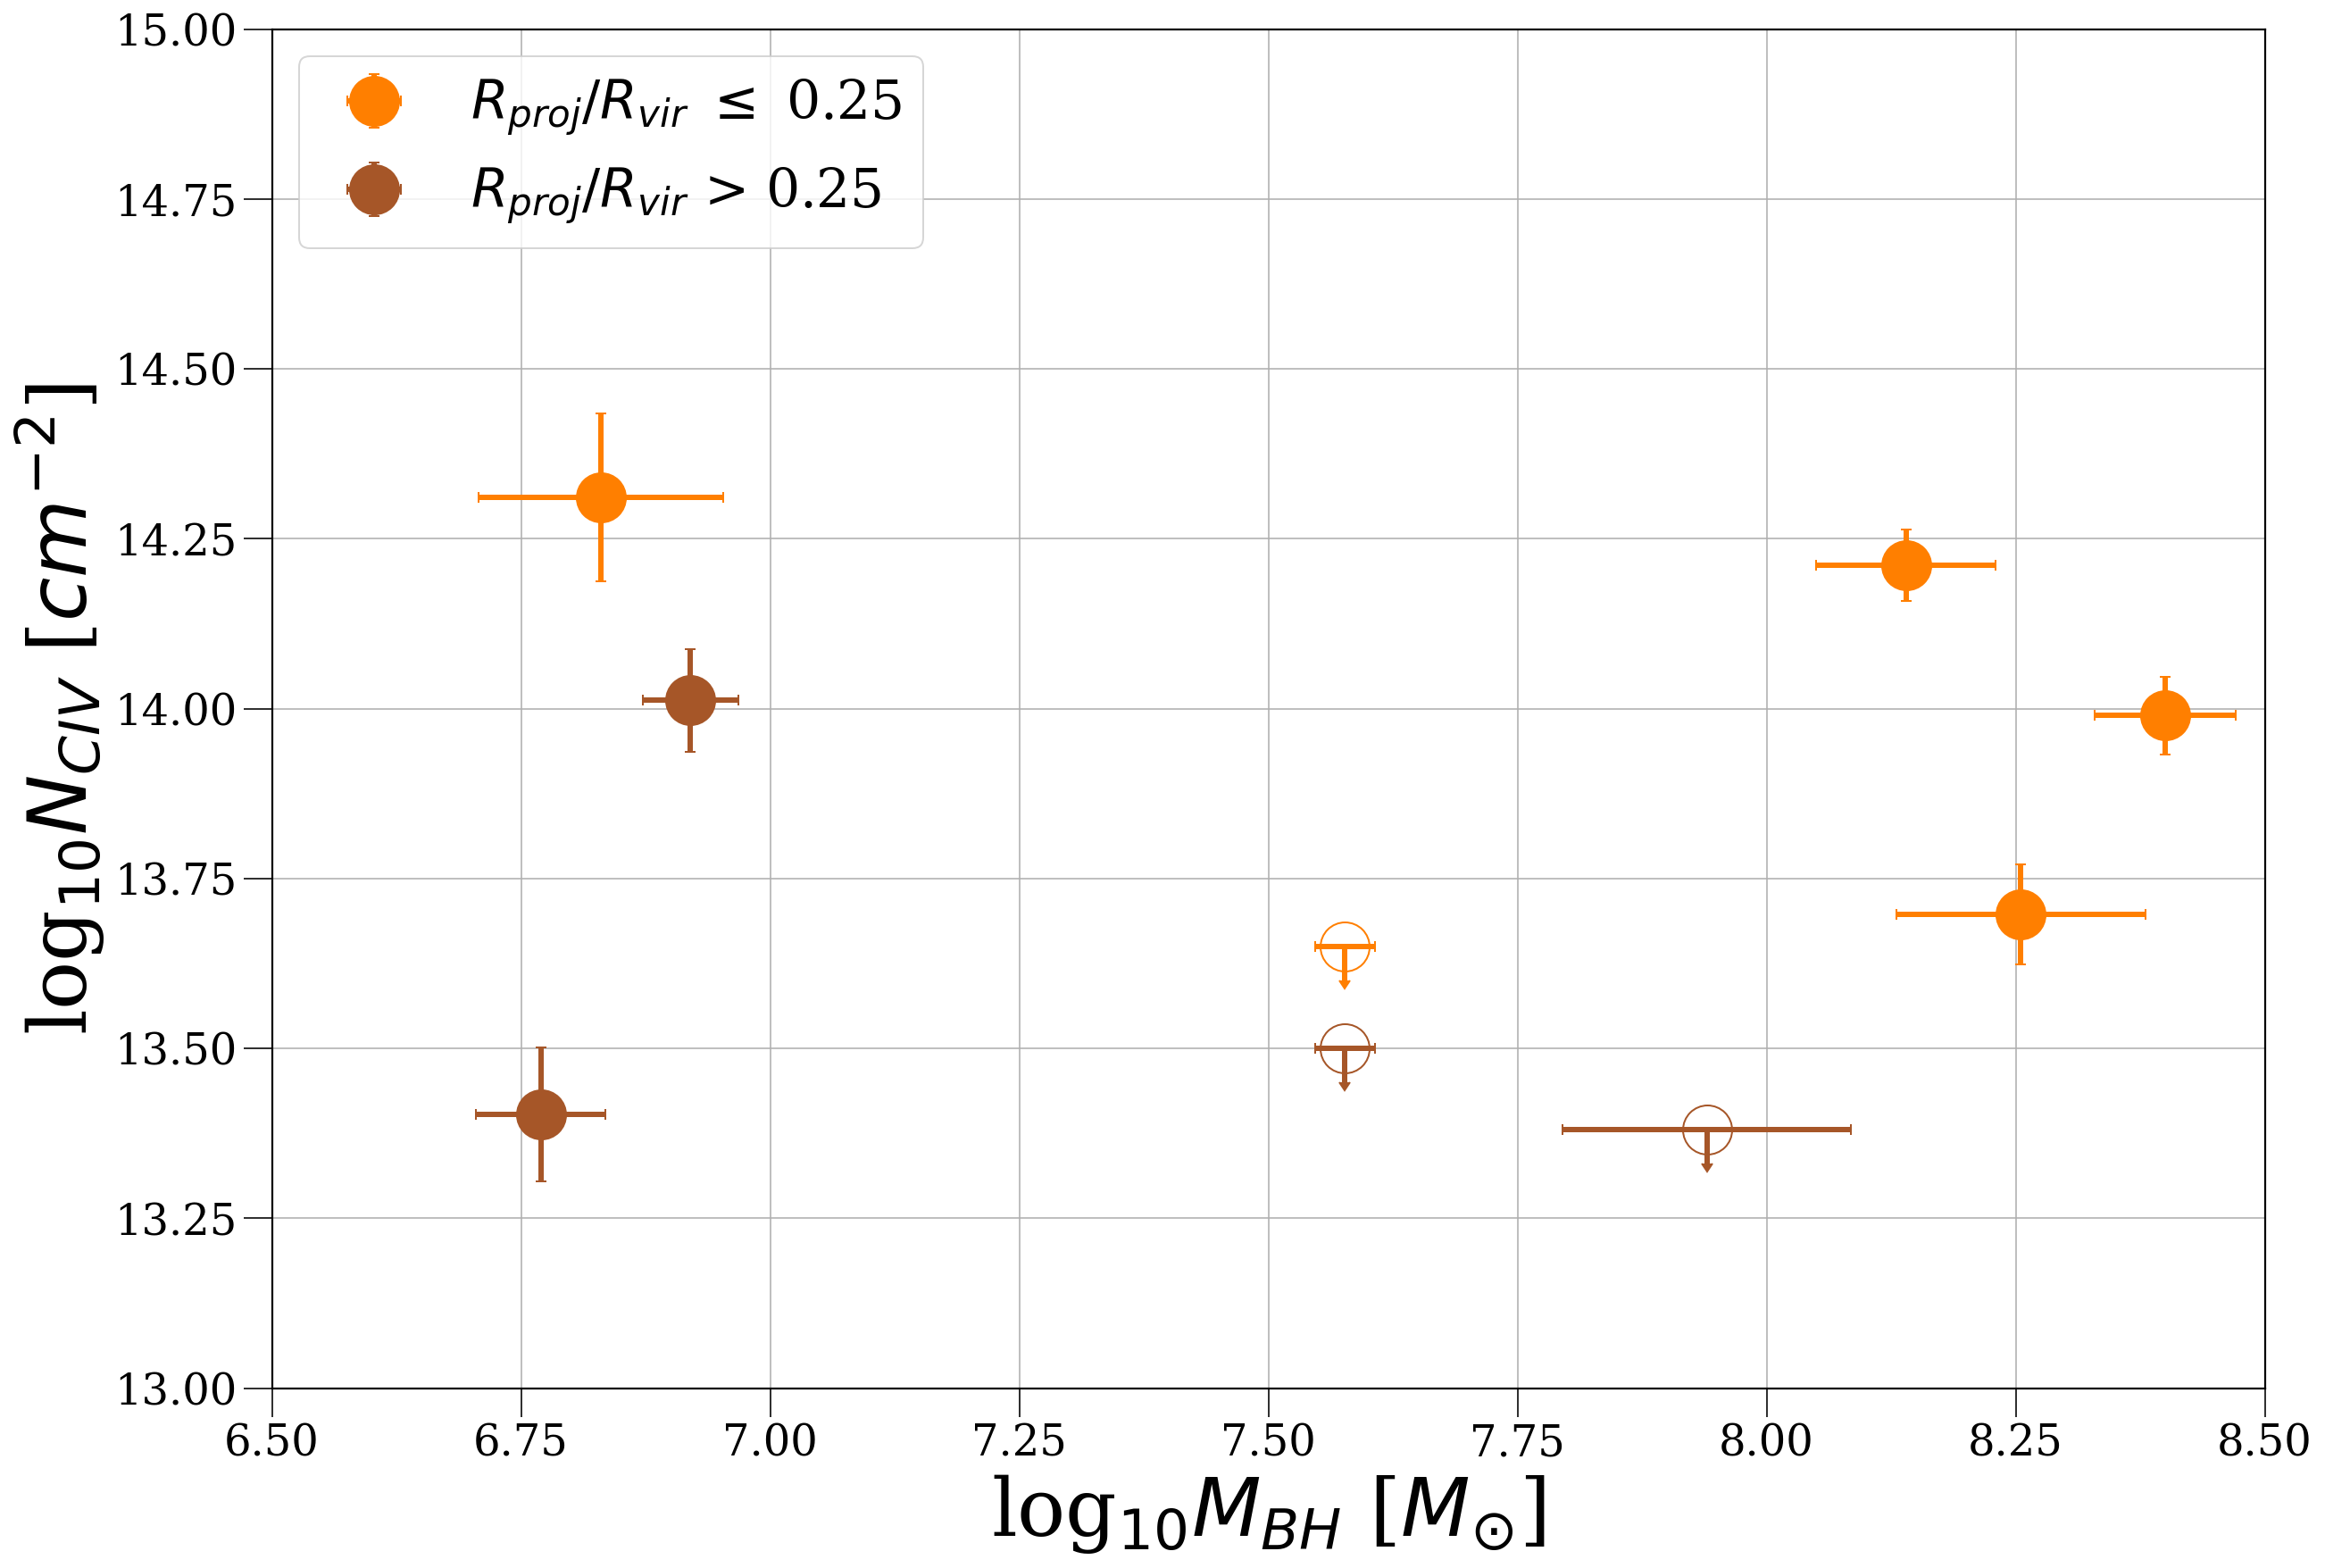

In [206]:
#Plotting NCIV vs MBH using R/Rvir as the split between the parameters   
fig, ax = plt.subplots()

######################################################

########################################################


########################################################
    
for mask, colour, label in zip([low_mask_rr, high_mask_rr], [CB_color_cycle[1], CB_color_cycle[4]], 
                               [r"$R_{proj}/R_{vir}$ $\leq$ 0.25", 
                                r"$R_{proj}/R_{vir}$ > 0.25"]):
    
    ax.errorbar(sum_ch["MBH"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["MBH"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)
    

ax.legend(loc=2, fontsize=30)
ax.set_xlabel(r"log$_{10}M_{BH}$ [$M_{\odot}$]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(13, 15)
ax.set_xlim(6.5, 8.5)
plt.grid(True)
#plt.savefig('Figures/nciv_vs_bh.png')
plt.show()

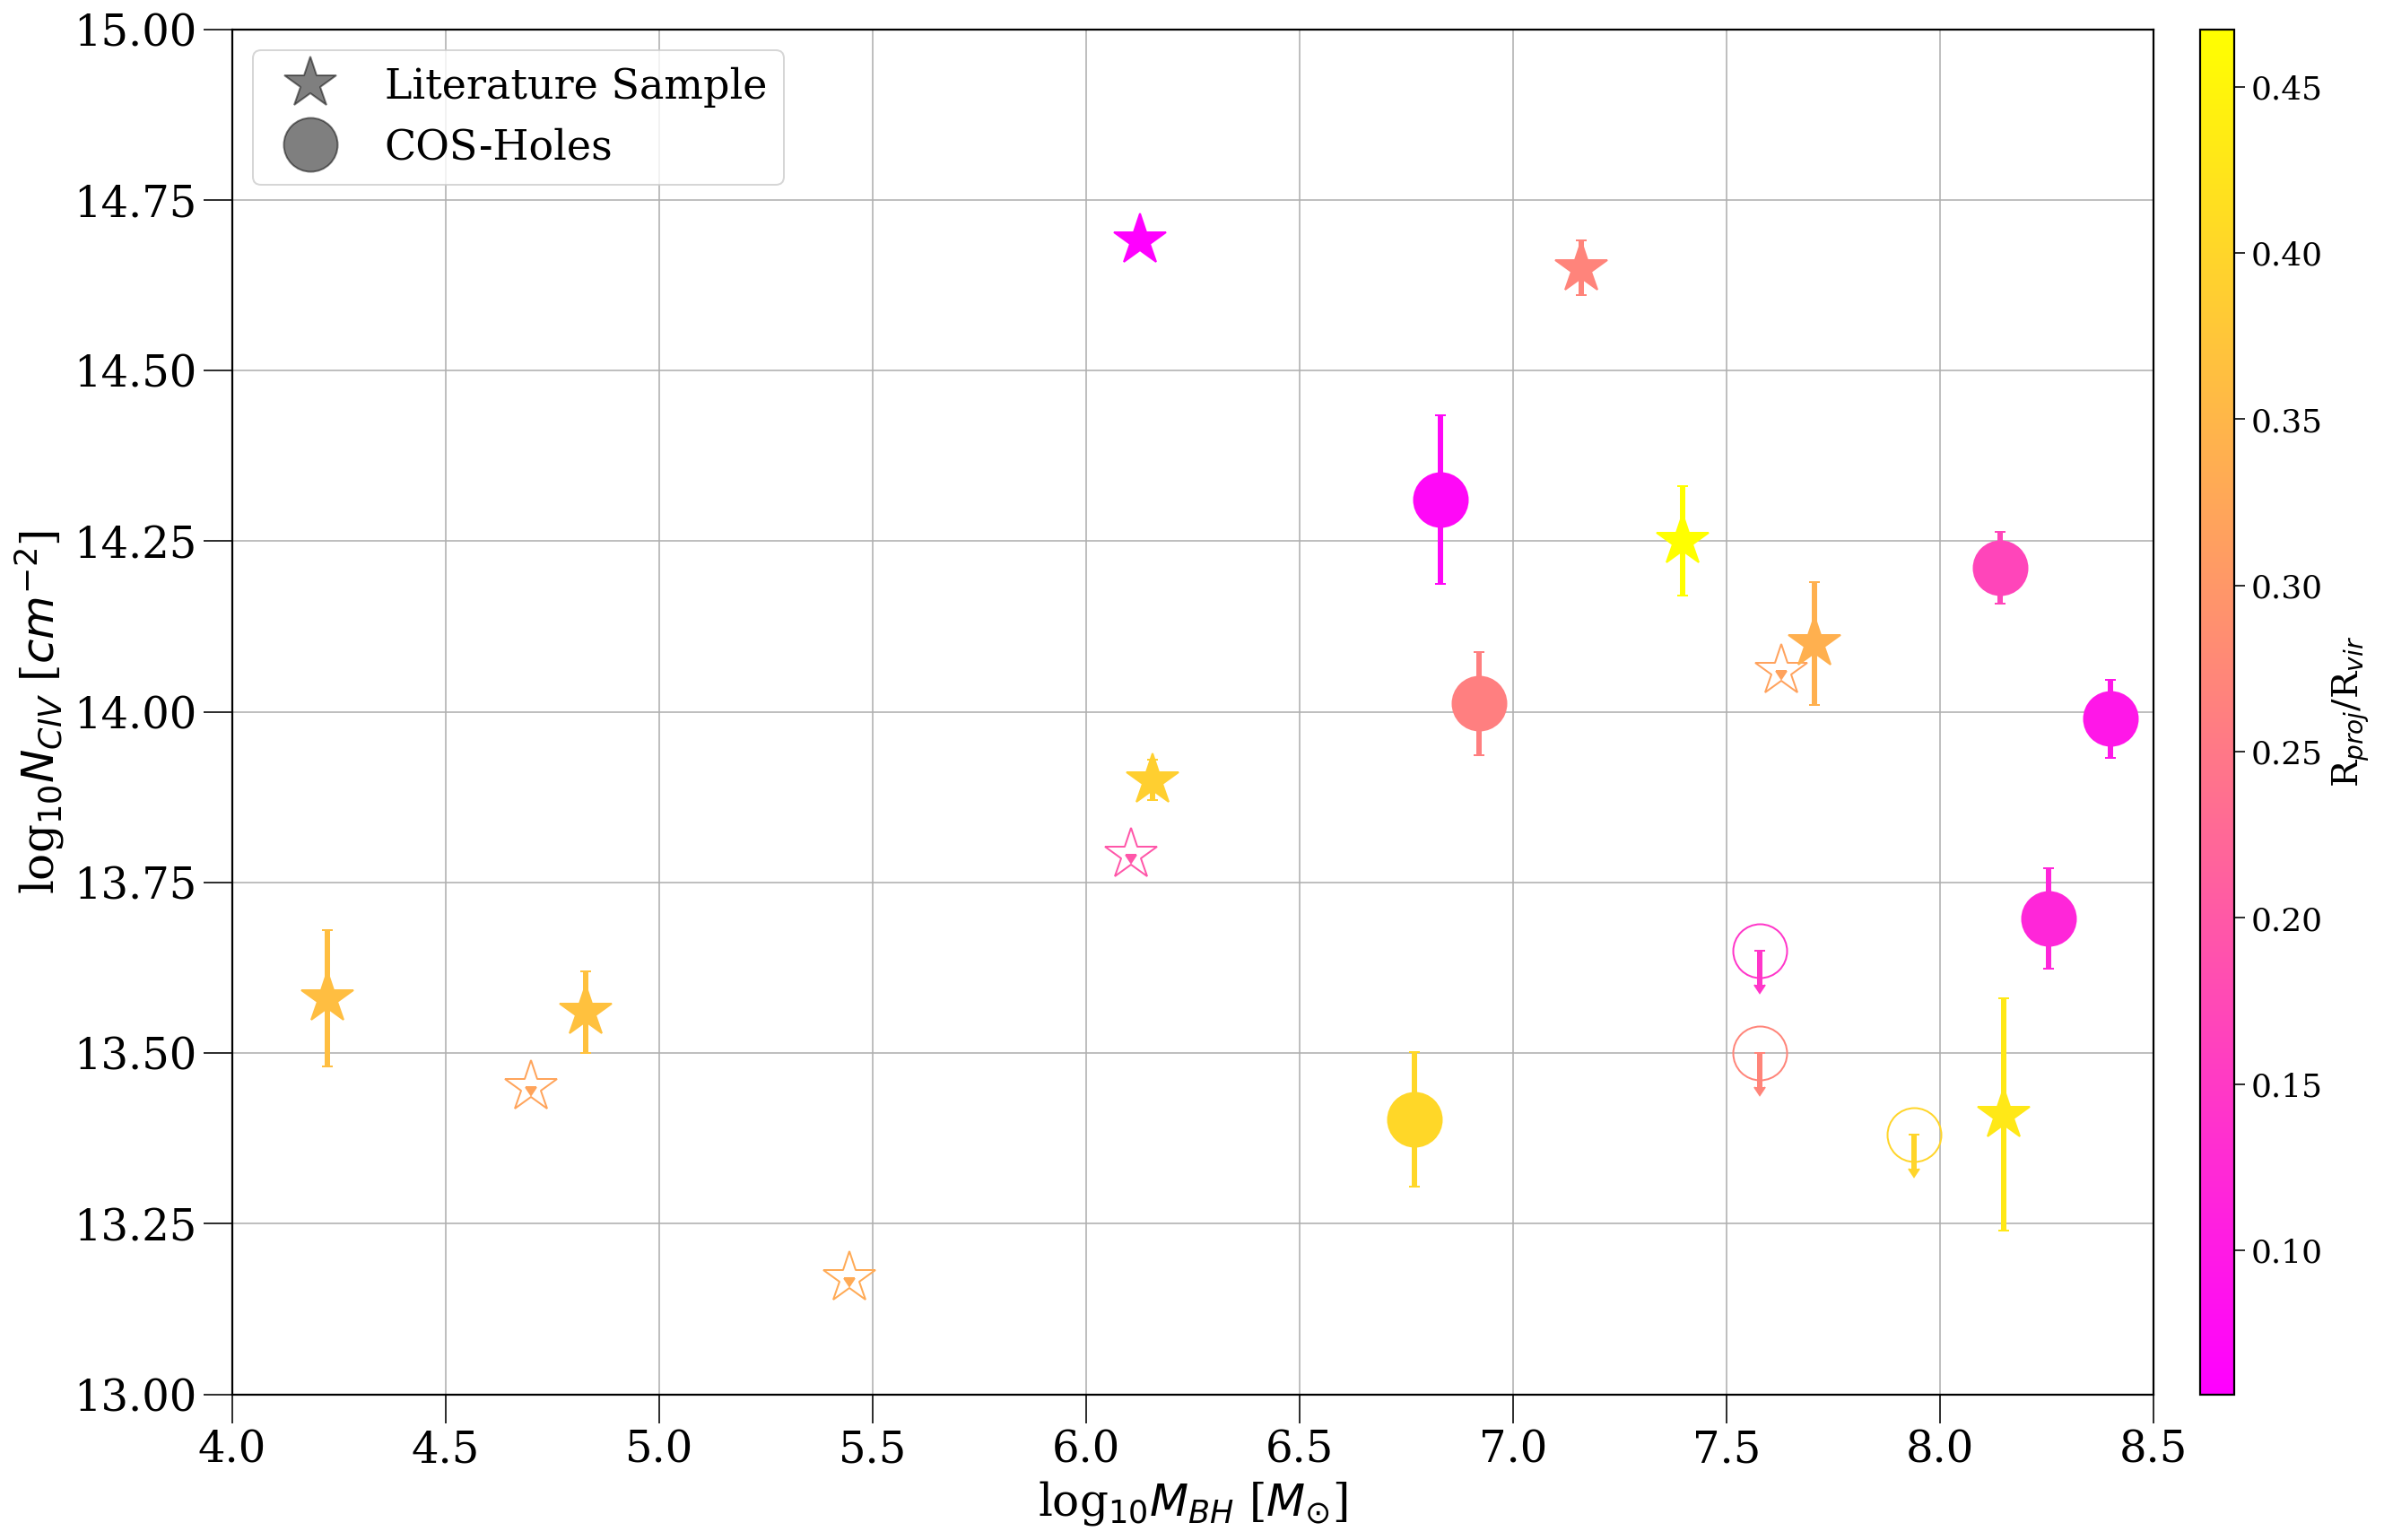

In [56]:
# Set figure size, I like this for 1 plot w colorbar but yaknow whateva
fig = plt.figure()

# Set a grid on your figure so you can define the color bar axis
axs = fig.add_gridspec(1, 50)

# Define the plot and the colorbar axes
plot = fig.add_subplot(axs[0, 0:48]) # this means use cols 0 - 49
cbar = fig.add_subplot(axs[0, 49])

# Now lets get the colors for ur points, luckily you have the values ...
# ... you want the colors to correspond to defined above as array 'c'
cool = plt.cm.get_cmap('spring')

c = np.asarray(coslit['Rproj/Rvir'])
c_normed = (c-min(c))/(max(c)-min(c))
coloring = cool(c_normed) # you can replace plasma with whatev


# Okay now plotting, same as above but made the color our new defined one
# It gets mad at you without the loop cuz its dumb
mbh_arr = np.array(coslit['MBH'])
N_arr = np.array(coslit['N'])
sigN_arr = np.array(coslit['sigN'])
sigmbh_arr = np.array(coslit['sigMBH'])
uplim_arr = np.array(coslit['uplim'])
marker_types = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o','o',
                '*', '*', '*', '*', 
               '*', '*', '*', '*', '*', 
               '*', '*', 
               '*']

#need to have unassigned shapes to represent the 4 datasets but not have them show up on the plot 
plot.plot(0,0, c='k', marker='*', markersize=30, ls='none', label='Literature Sample', alpha=0.5)
#plot.plot(0,0, c='k', marker='H', markersize=30, ls='none', label='Werk+13: COS-Halos', alpha=0.5)
#plot.plot(0,0, c='k', marker='d', markersize=30, ls='none', label='Borthakur+14: COS-Dwarfs', alpha=0.5)
#plot.plot(0,0, c='k', marker='p', markersize=30, ls='none', label='Lehner+20: Project AMIGA', alpha=0.5)
plot.plot(0,0, c='k', marker='o', markersize=30, ls='none', label='COS-Holes', alpha=0.5)  

    
for i in range(len(mbh_arr)):
    if uplim_arr[i] < 1:  
        plot.errorbar(mbh_arr[i], N_arr[i], 
                yerr=sigN_arr[i],  
                capsize = 3, c=coloring[i], marker= marker_types[i], 
                markersize=30, ls='none', elinewidth=3, mfc='none', uplims=True)
    else: 
        plot.errorbar(mbh_arr[i], N_arr[i], 
                yerr=sigN_arr[i], 
                capsize = 3, c=coloring[i], marker=marker_types[i], 
                markersize=30, ls='none', elinewidth=3)
    
# Here's where the magic happens
# Set up normalization for the color bar
# (sets lowest color to min value and highest color to max value)
norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))

# make the color bar
#cmap = mpl.colors.ListedColormap(coloring, name='Rproj/Rvir')

# !!!!! Use this instead to make the colorbar look continuous gradient:
cmap = cool

# mapping for the color bar
mapping = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# do the thing, telling it to use the subplot you created for the ...
# ... color bar (cax = cbar)
colorbar = fig.colorbar(mapping, cax=cbar, orientation='vertical')

# Okay now it's created, the rest is just visual preference:
colorbar.ax.tick_params(length=6, labelsize=18)
colorbar.ax.spines['top'].set_linewidth(1.5)
colorbar.ax.spines['bottom'].set_linewidth(1.5)
colorbar.ax.spines['left'].set_linewidth(1.5)
colorbar.ax.spines['right'].set_linewidth(1.5)
colorbar.set_label(label=r'R$_{proj}$/R$_{vir}$', size=20)

# Your other stylings from above:
plot.legend(loc=2, fontsize=23) # Theres no labels for your legend but ill leave it
plot.set_xlabel(r"log$_{10}M_{BH}$ [$M_{\odot}$]", fontsize=25)
plot.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=25)
plot.set_ylim([13, 15])
plot.set_xlim([4, 8.5])
plot.grid(True)
#plt.tight_layout()
plt.show()

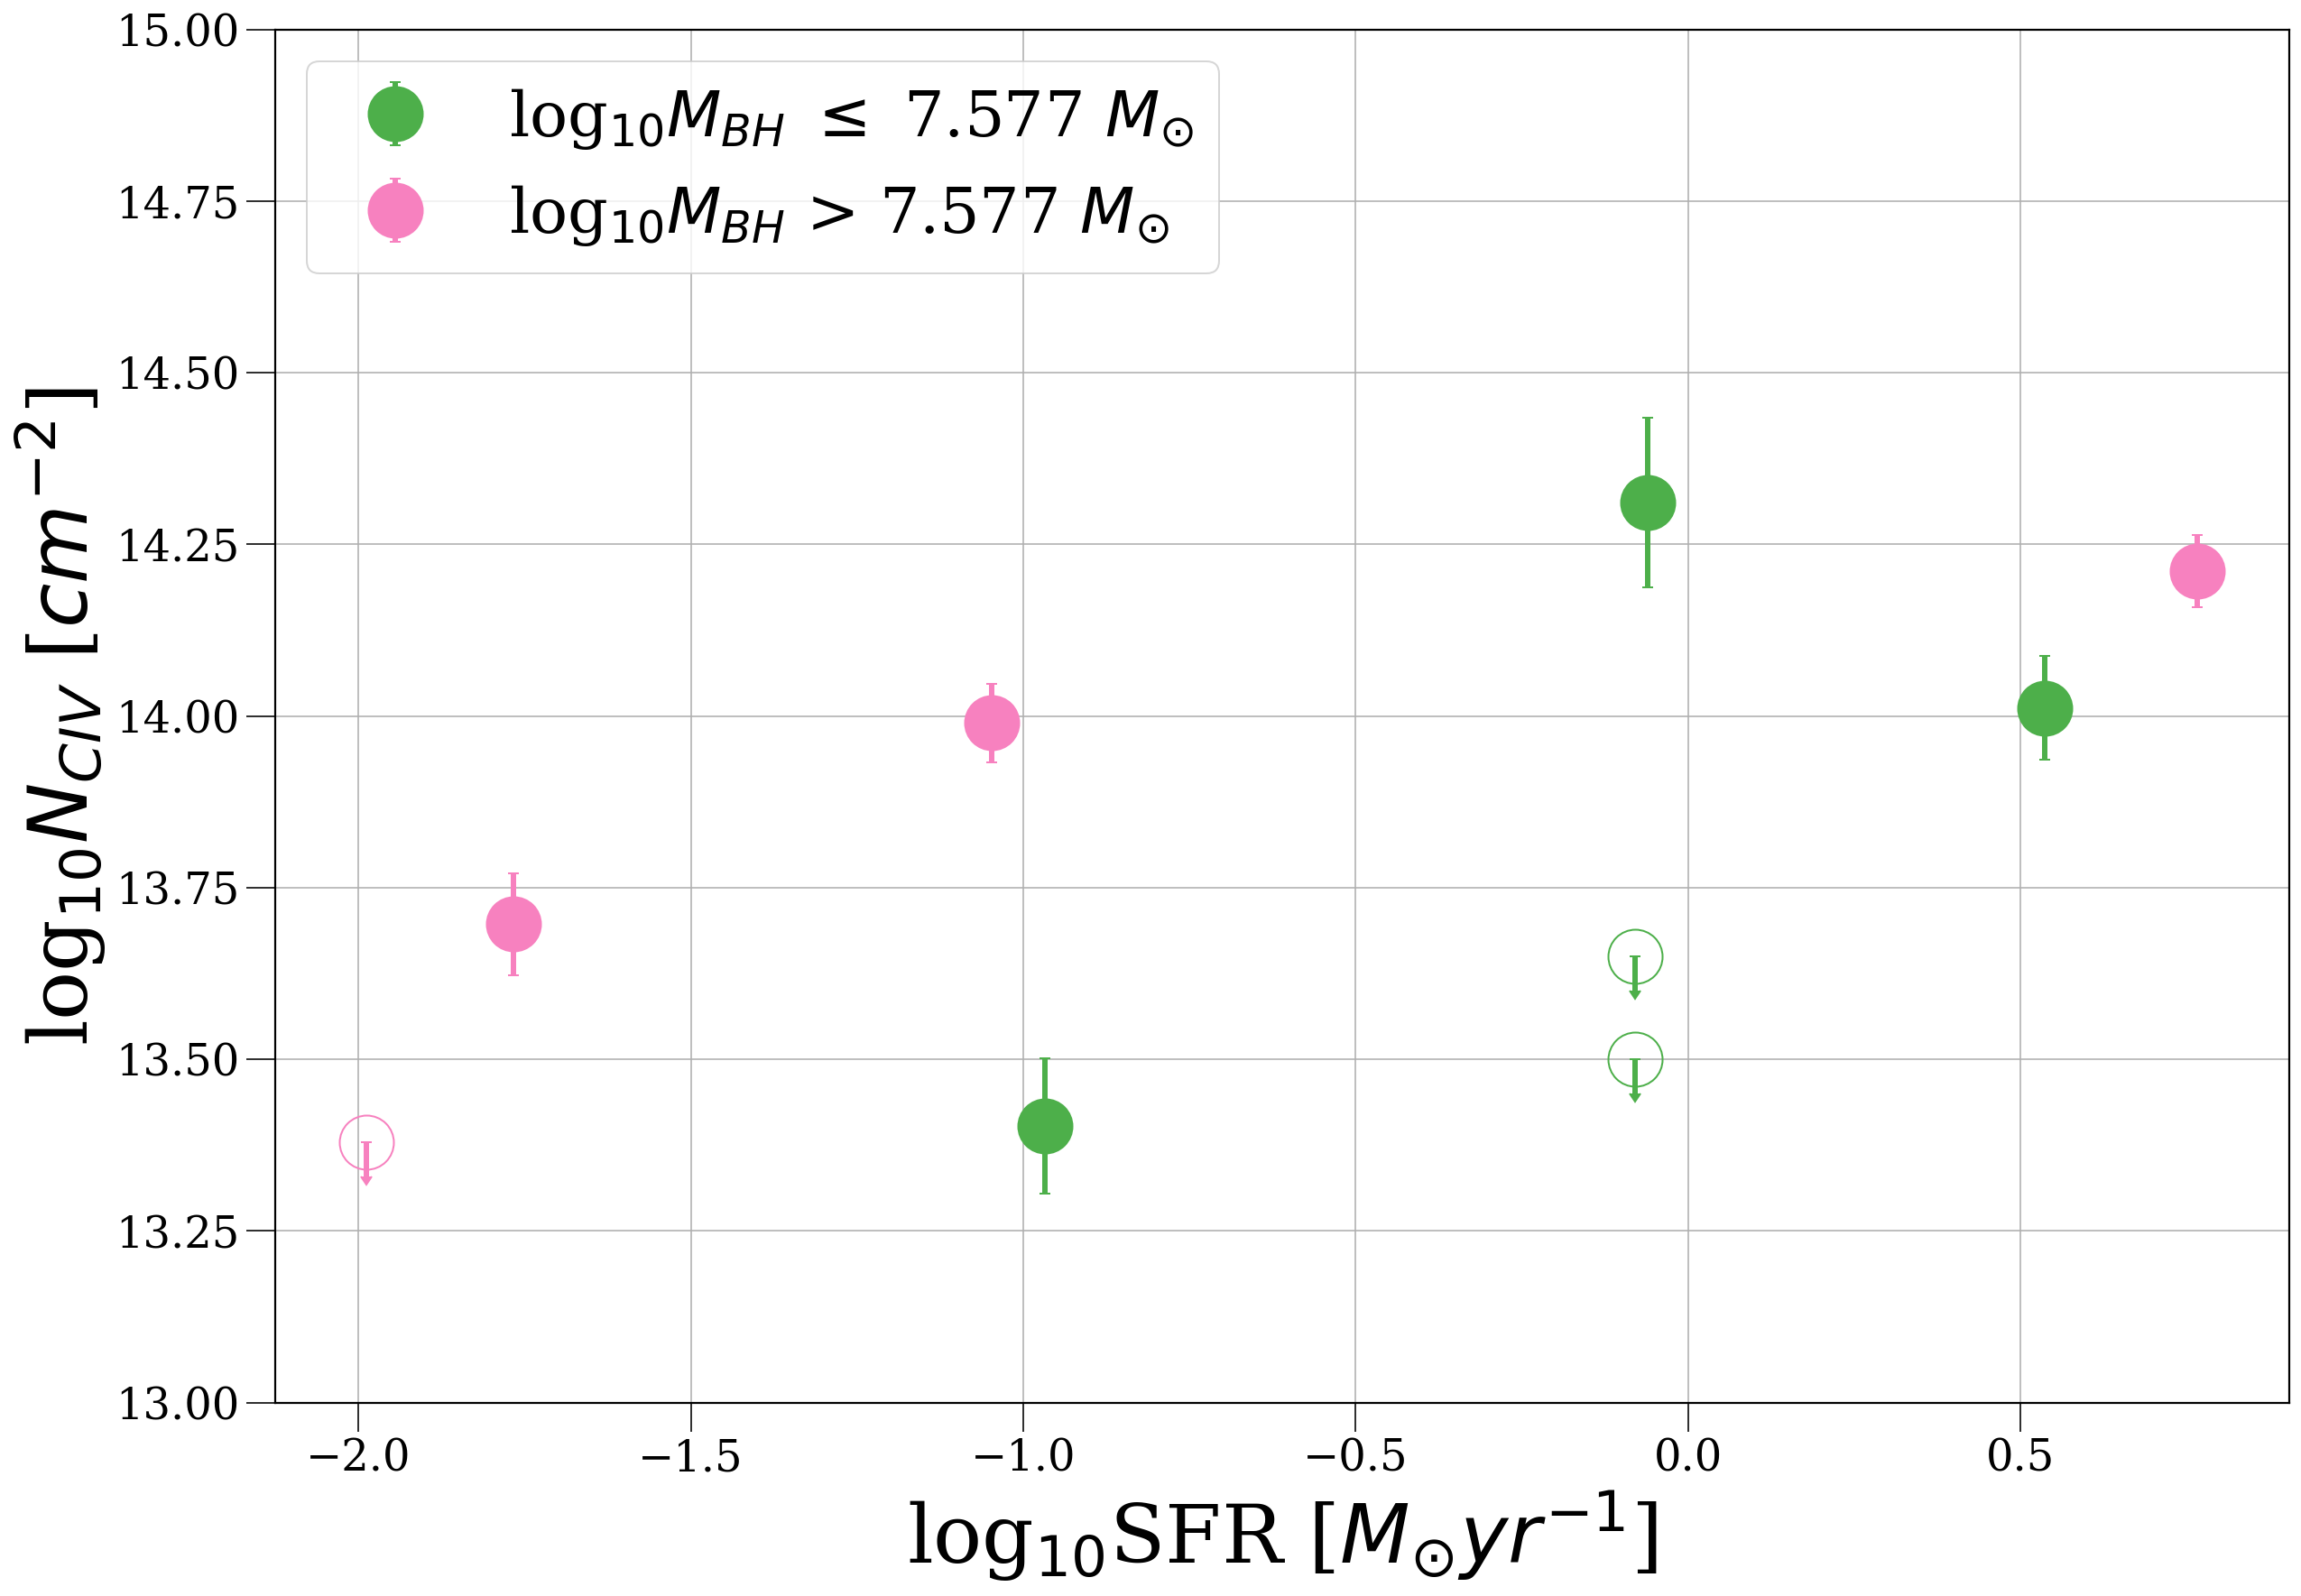

In [57]:
#Plotting NCIV vs SFR    
fig, ax = plt.subplots()

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.577 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.577 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["SFR"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["SFR"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=2, fontsize=35)
ax.set_xlabel(r"log$_{10}$SFR [$M_{\odot} yr^{-1}$]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
plt.grid(True)
ax.set_ylim(13, 15)
plt.show()

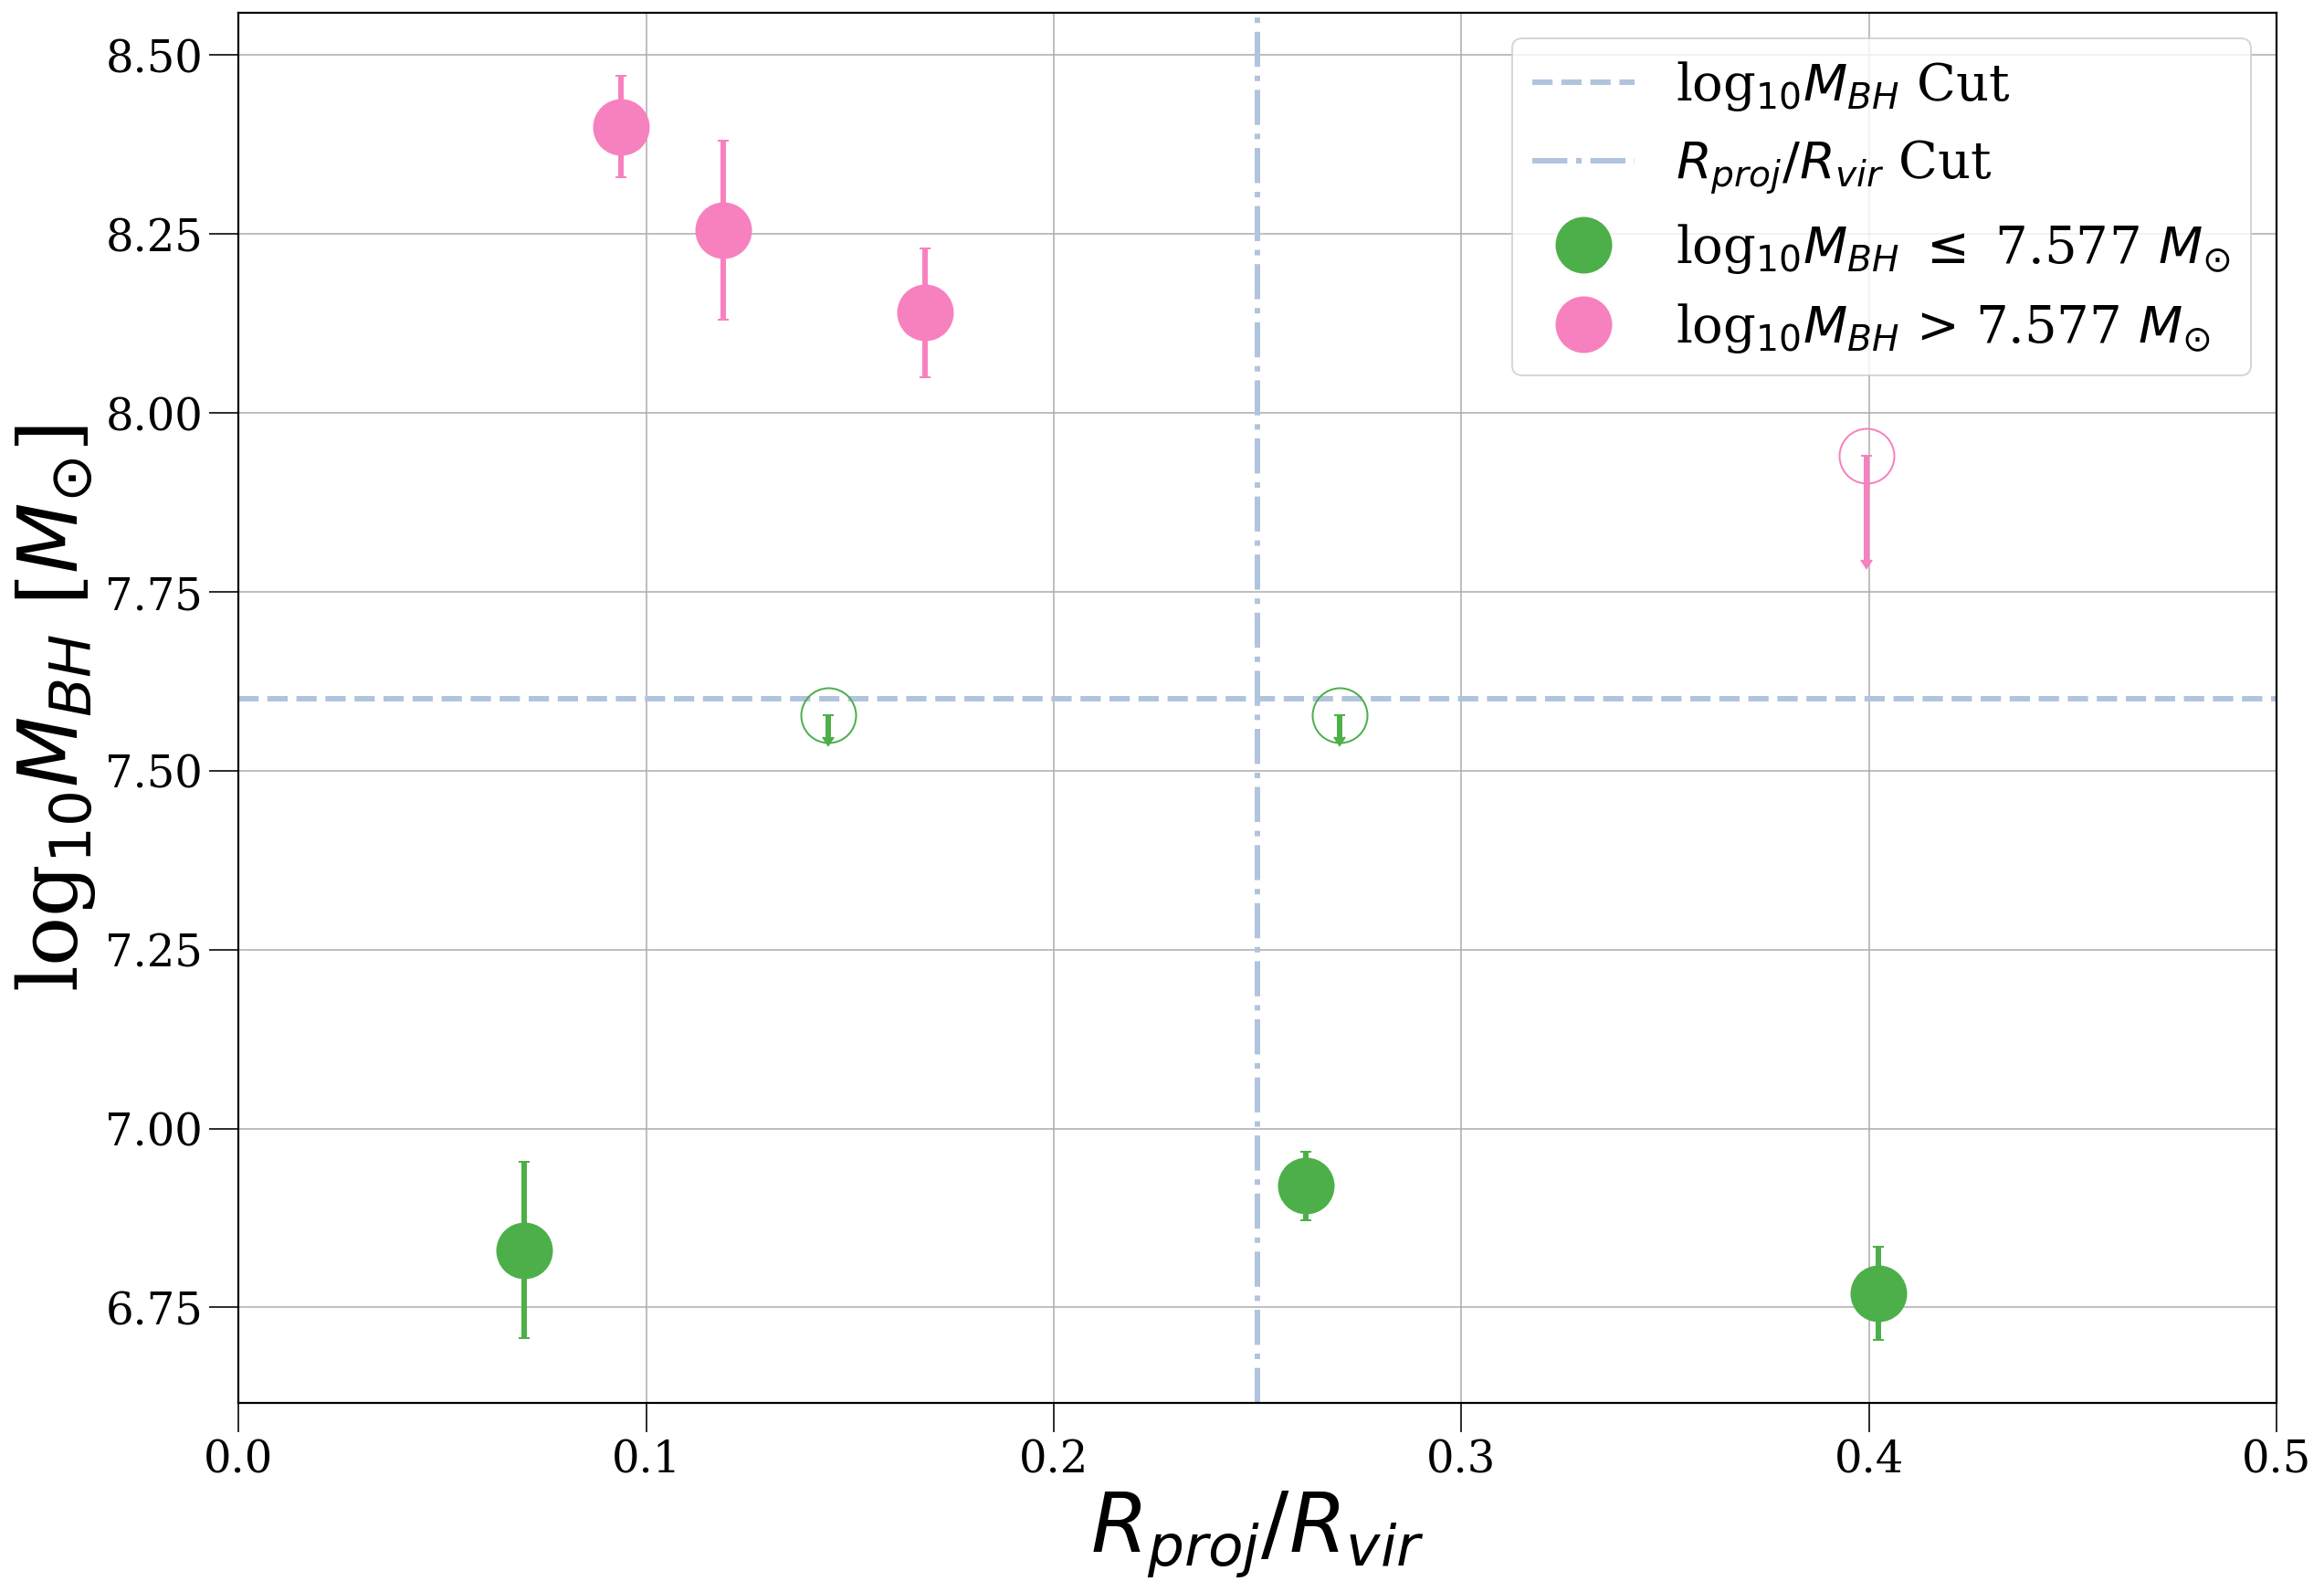

In [225]:
#Making the new plot that Jess wanted us to look into 
    #Want to look at the Mbh vs R/Rvir and have the cits dotted where we cut in half for Mbh and R/Rvir 
    #and see what that looks like 

fig, ax = plt.subplots()

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.577 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.577 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['MBH'][mask],yerr=sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['MBH'][mask], yerr=up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, ls='none', uplims=True, mfc='none', elinewidth=3)
    
plt.axhline(7.6, c='lightsteelblue', ls='--', lw=3, label='log$_{10}M_{BH}$ Cut')
plt.axvline(0.25, c='lightsteelblue', ls='-.', lw=3, label=r"$R_{proj}/R_{vir}$ Cut")

ax.legend(loc=1, fontsize=28)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}M_{BH}$ [$M_{\odot}$]", fontsize=45)
plt.grid(True)
#ax.set_ylim(4, 9)
ax.set_xlim(0, 0.5)
plt.show()

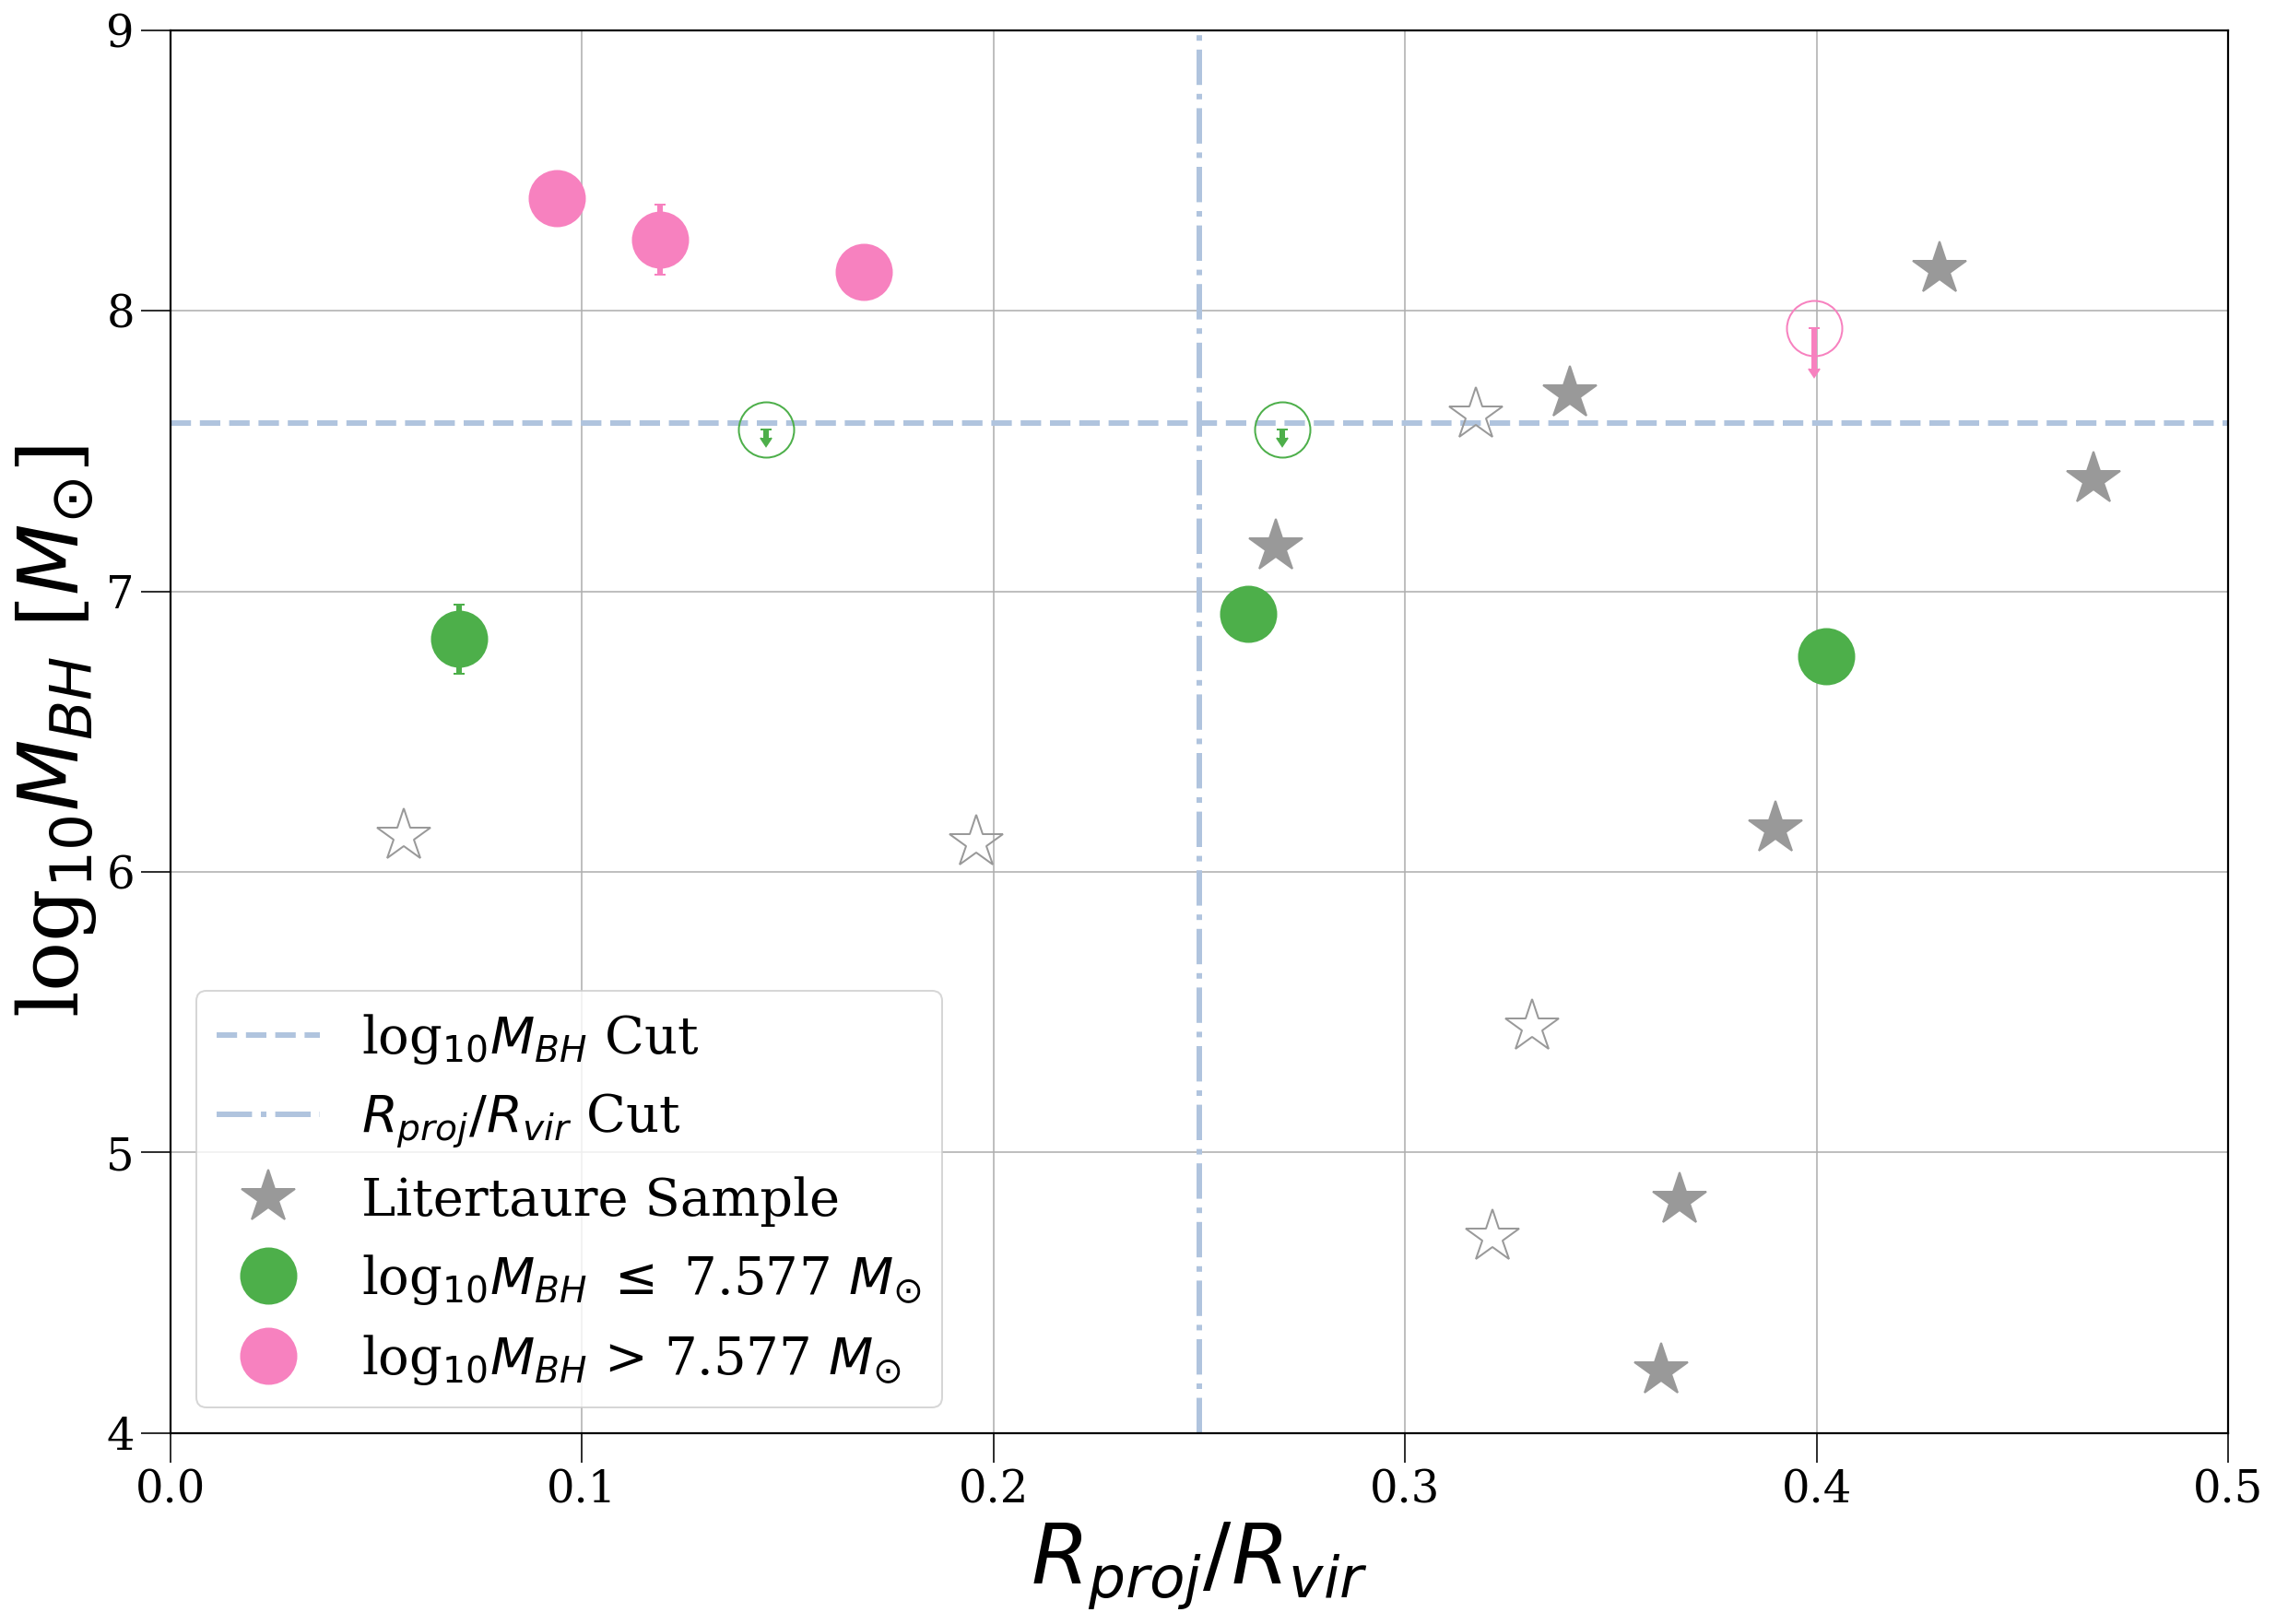

In [238]:
#Making the new plot that Jess wanted us to look into 
    #Want to look at the Mbh vs R/Rvir and have the cits dotted where we cut in half for Mbh and R/Rvir 
    #and see what that looks like 

fig, ax = plt.subplots()

########################################################

#Literature Sample 
    
ax.errorbar(coslit_det['Rproj/Rvir'][6:], coslit_det['MBH'][6:],#yerr=coslit_det['sigMBH'],
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, label='Litertaure Sample', ls='none', elinewidth=3)
    
ax.errorbar(coslit_uplim['Rproj/Rvir'][3:], coslit_uplim['MBH'][3:],#yerr=coslit_uplim['sigMBH'], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.errorbar(coslit_lolim['Rproj/Rvir'], coslit_lolim['MBH'],#yerr=coslit_lolim['sigMBH'], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=3)

########################################################

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.577 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.577 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['MBH'][mask],yerr=sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['MBH'][mask], yerr=up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, ls='none', uplims=True, mfc='none', elinewidth=3)
    
plt.axhline(7.6, c='lightsteelblue', ls='--', lw=3, label='log$_{10}M_{BH}$ Cut')
plt.axvline(0.25, c='lightsteelblue', ls='-.', lw=3, label=r"$R_{proj}/R_{vir}$ Cut")

ax.legend(loc=3, fontsize=28)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}M_{BH}$ [$M_{\odot}$]", fontsize=45)
plt.grid(True)
ax.set_ylim(4, 9)
ax.set_xlim(0, 0.5)
plt.show()

In [58]:
np.median(cos_sup['MBH'])

7.577

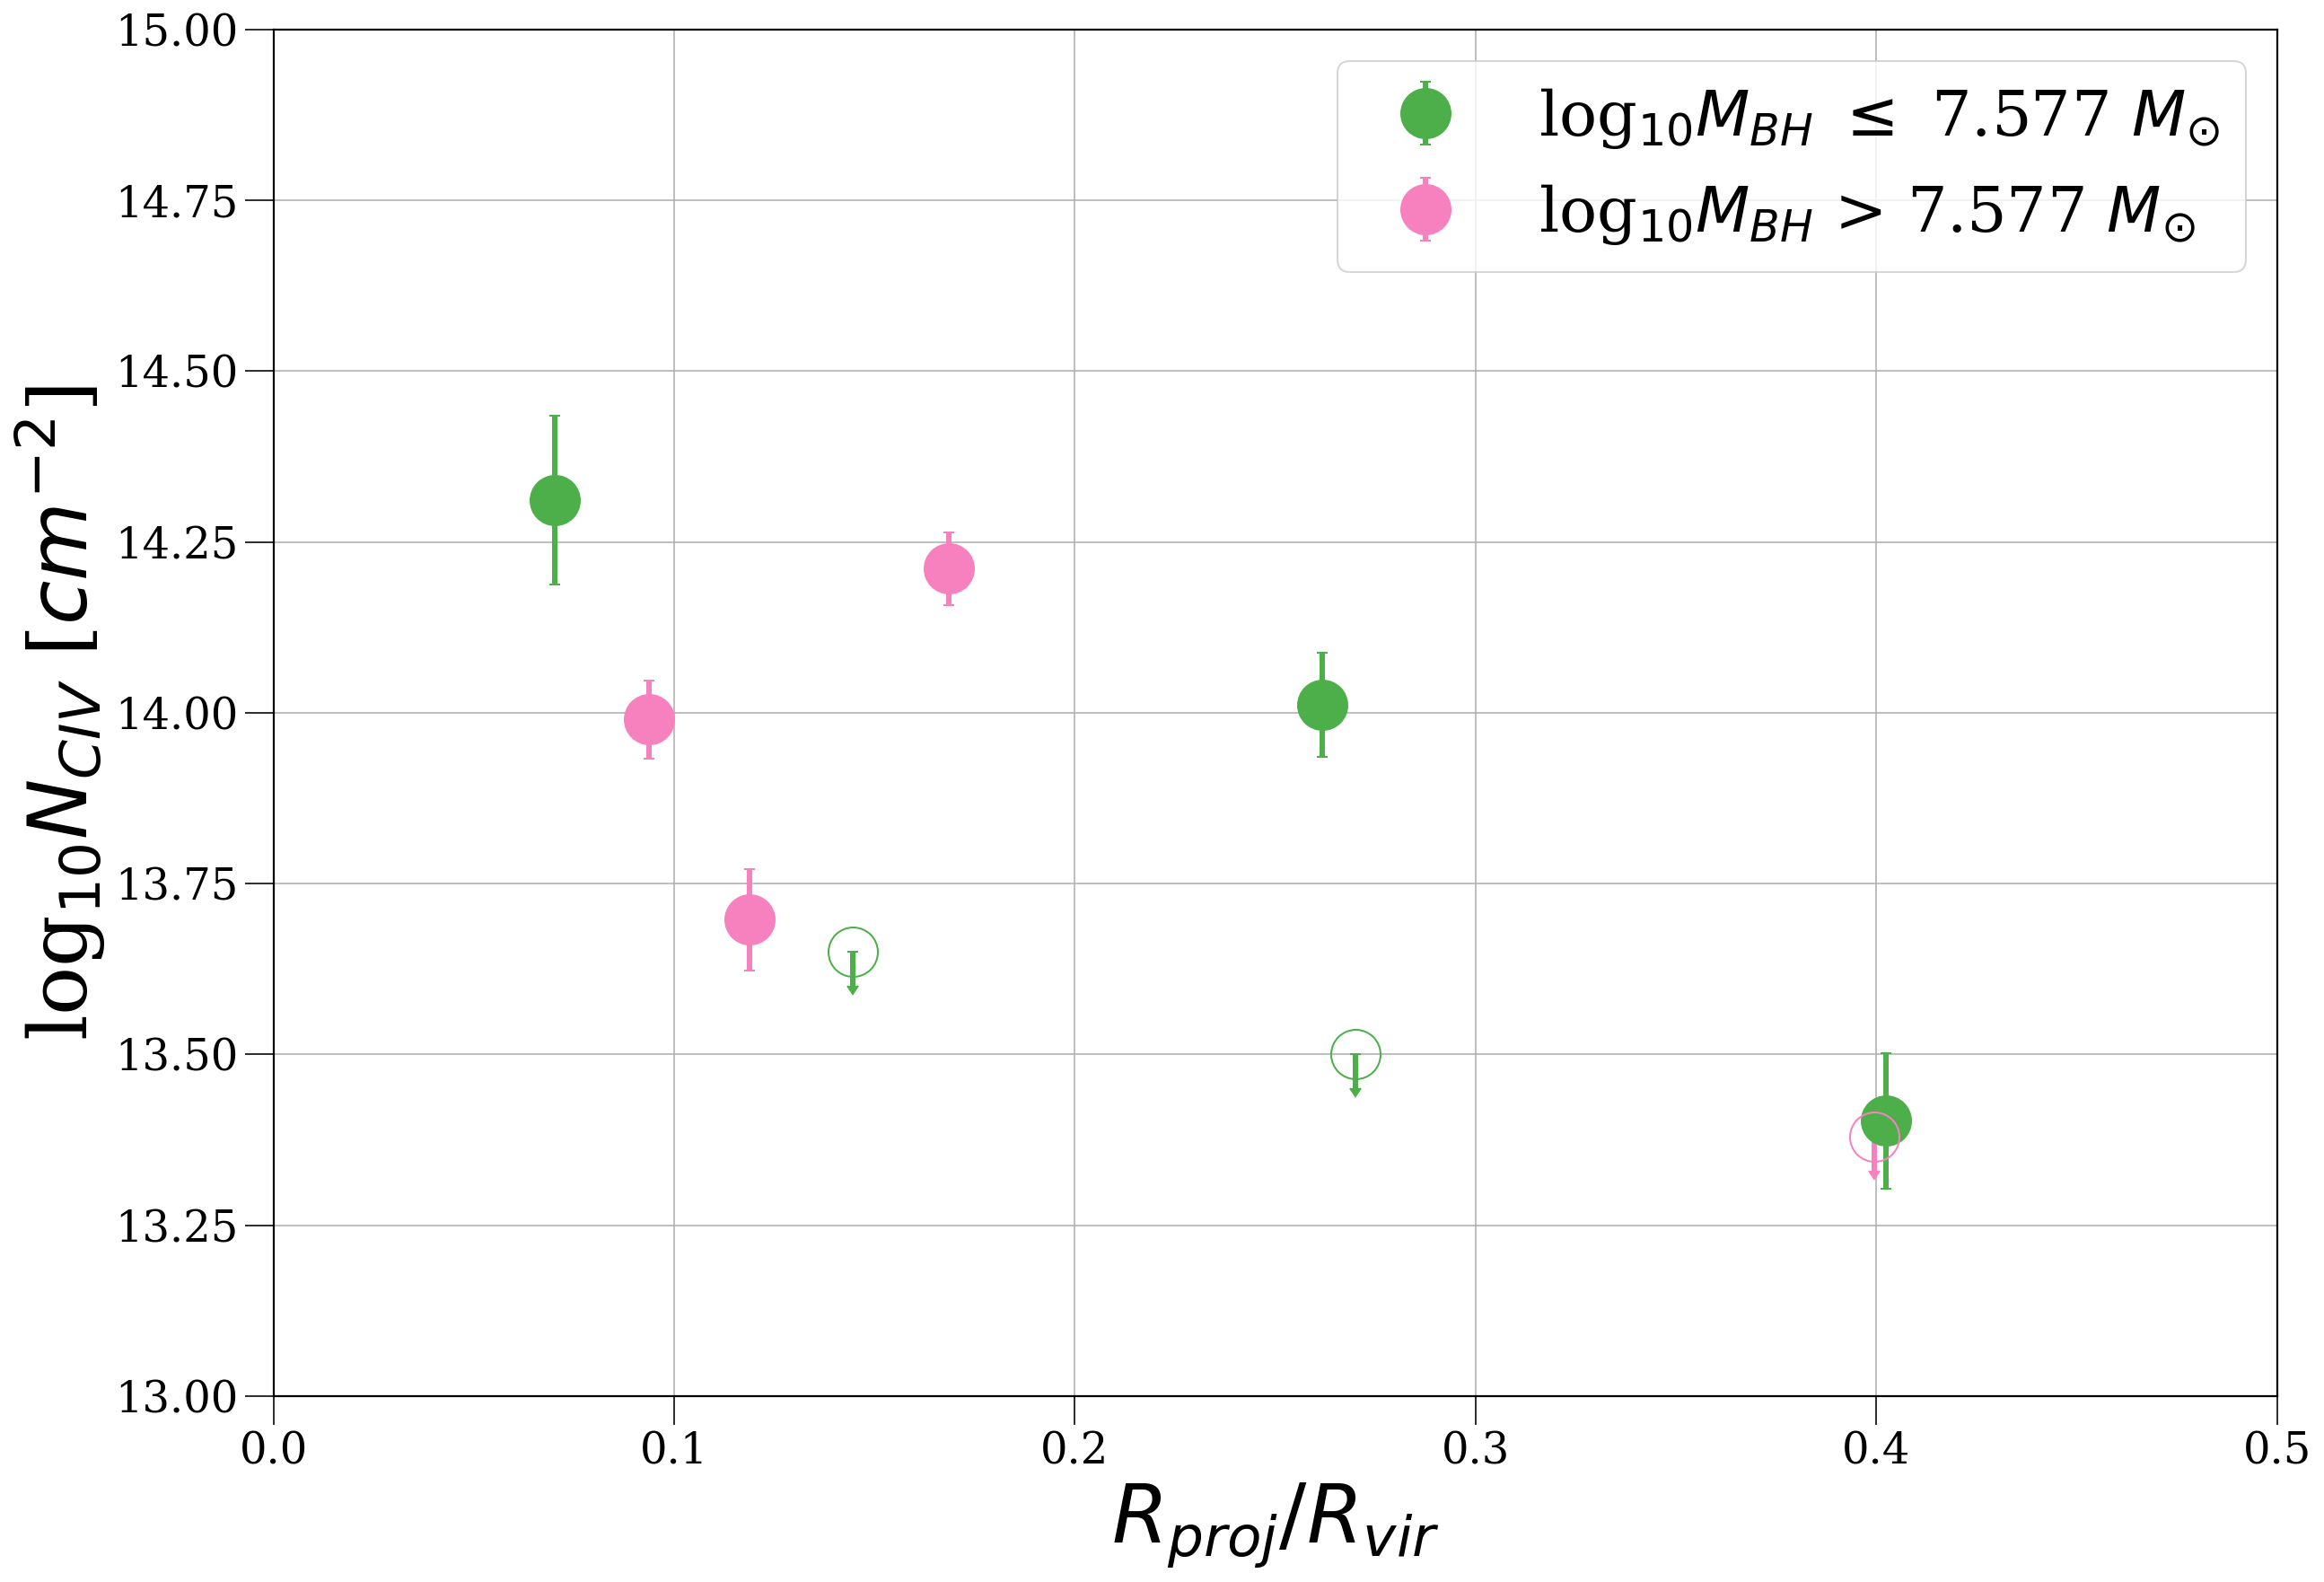

In [83]:
#Plotting NCIV vs R/Rvir     
fig, ax = plt.subplots()

########################################################

########################################################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.577 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.577 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)
    

ax.legend(loc=1, fontsize=35)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(13, 15)
ax.set_xlim(0, 0.5)
ax.grid(True)
#plt.savefig('Figures/nciv_r25_vs_rr.png')
plt.show()

In [235]:
coslit_lolim['QSO']

0    J0959+0503
Name: QSO, dtype: object

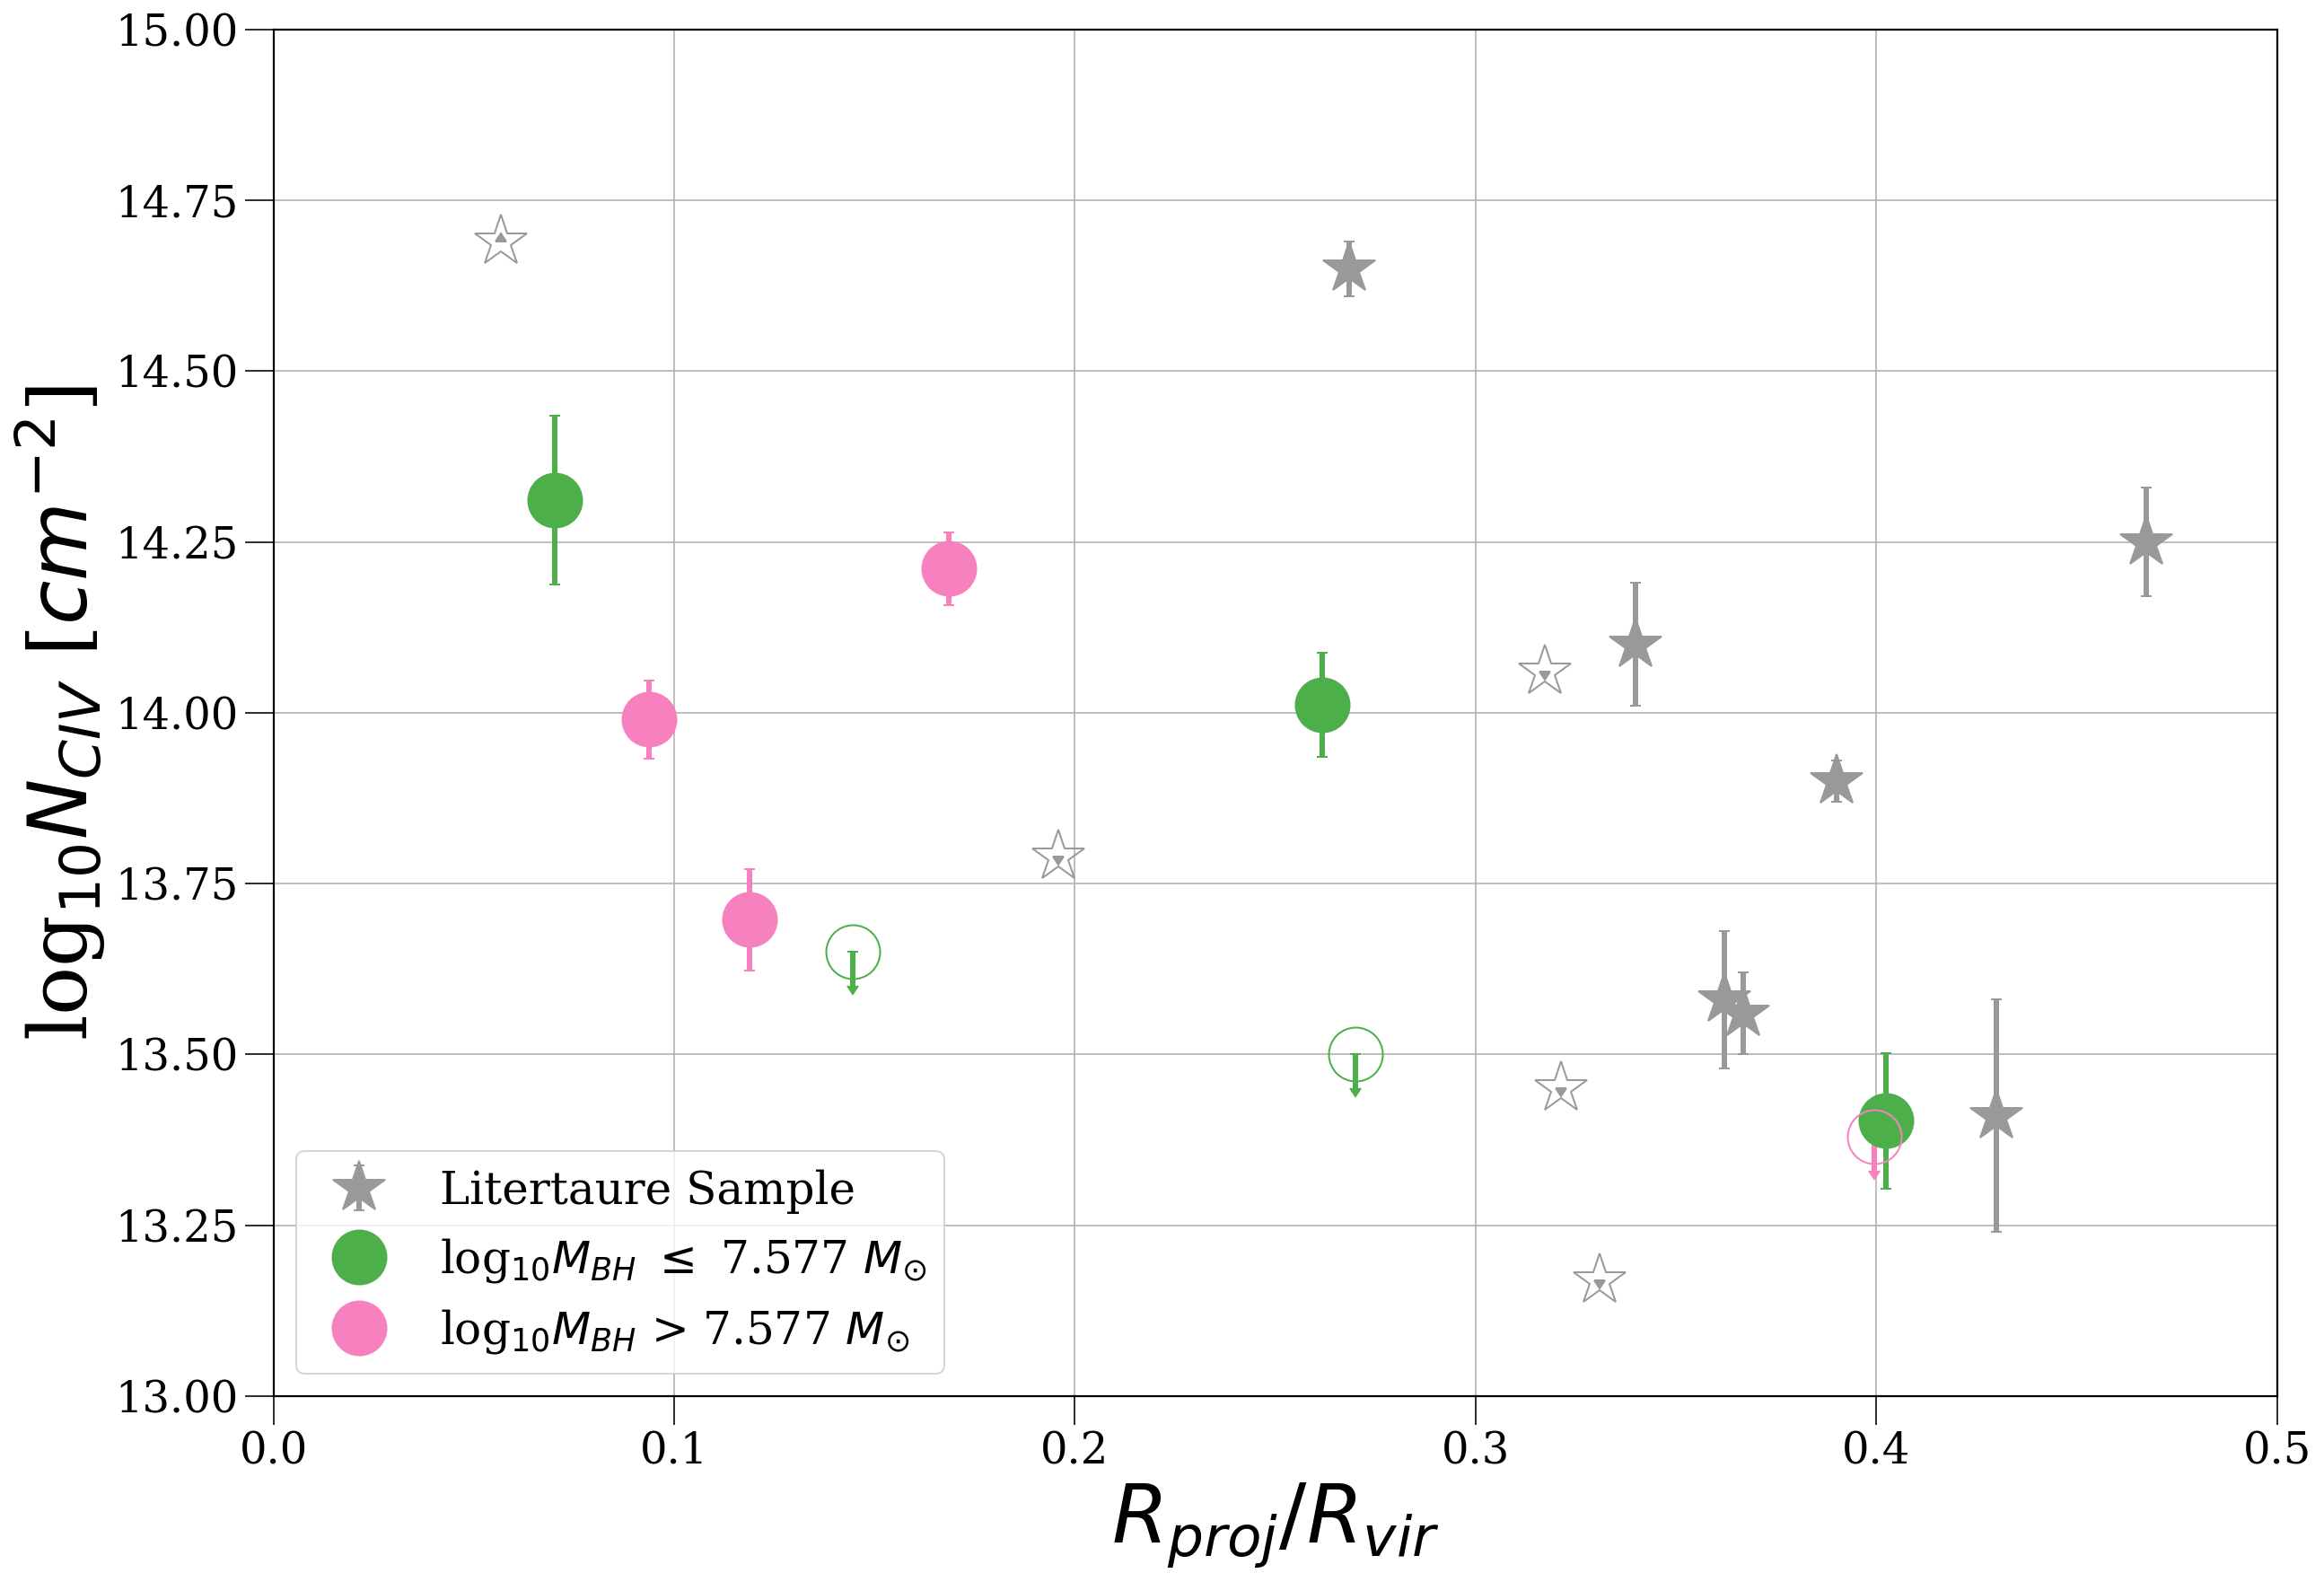

In [236]:
#Plotting NCIV vs R/Rvir     
fig, ax = plt.subplots()

########################################################

#Literature Sample 
    
ax.errorbar(coslit_det['Rproj/Rvir'][6:], coslit_det['N'][6:],yerr=coslit_det['sigN'][6:],
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, label='Litertaure Sample', ls='none', elinewidth=3)
    
ax.errorbar(coslit_uplim['Rproj/Rvir'][3:], coslit_uplim['N'][3:],yerr=coslit_uplim['sigN'][:], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.errorbar(coslit_lolim['Rproj/Rvir'], coslit_lolim['N'],yerr=coslit_lolim['sigN'], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=3)

########################################################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.577 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.577 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker="o", markersize=30, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker="o", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)
    

ax.legend(loc=3, fontsize=25)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(13, 15)
ax.set_xlim(0, 0.5)
ax.grid(True)
#plt.savefig('Figures/nciv_r25_vs_rr.png')
plt.show()

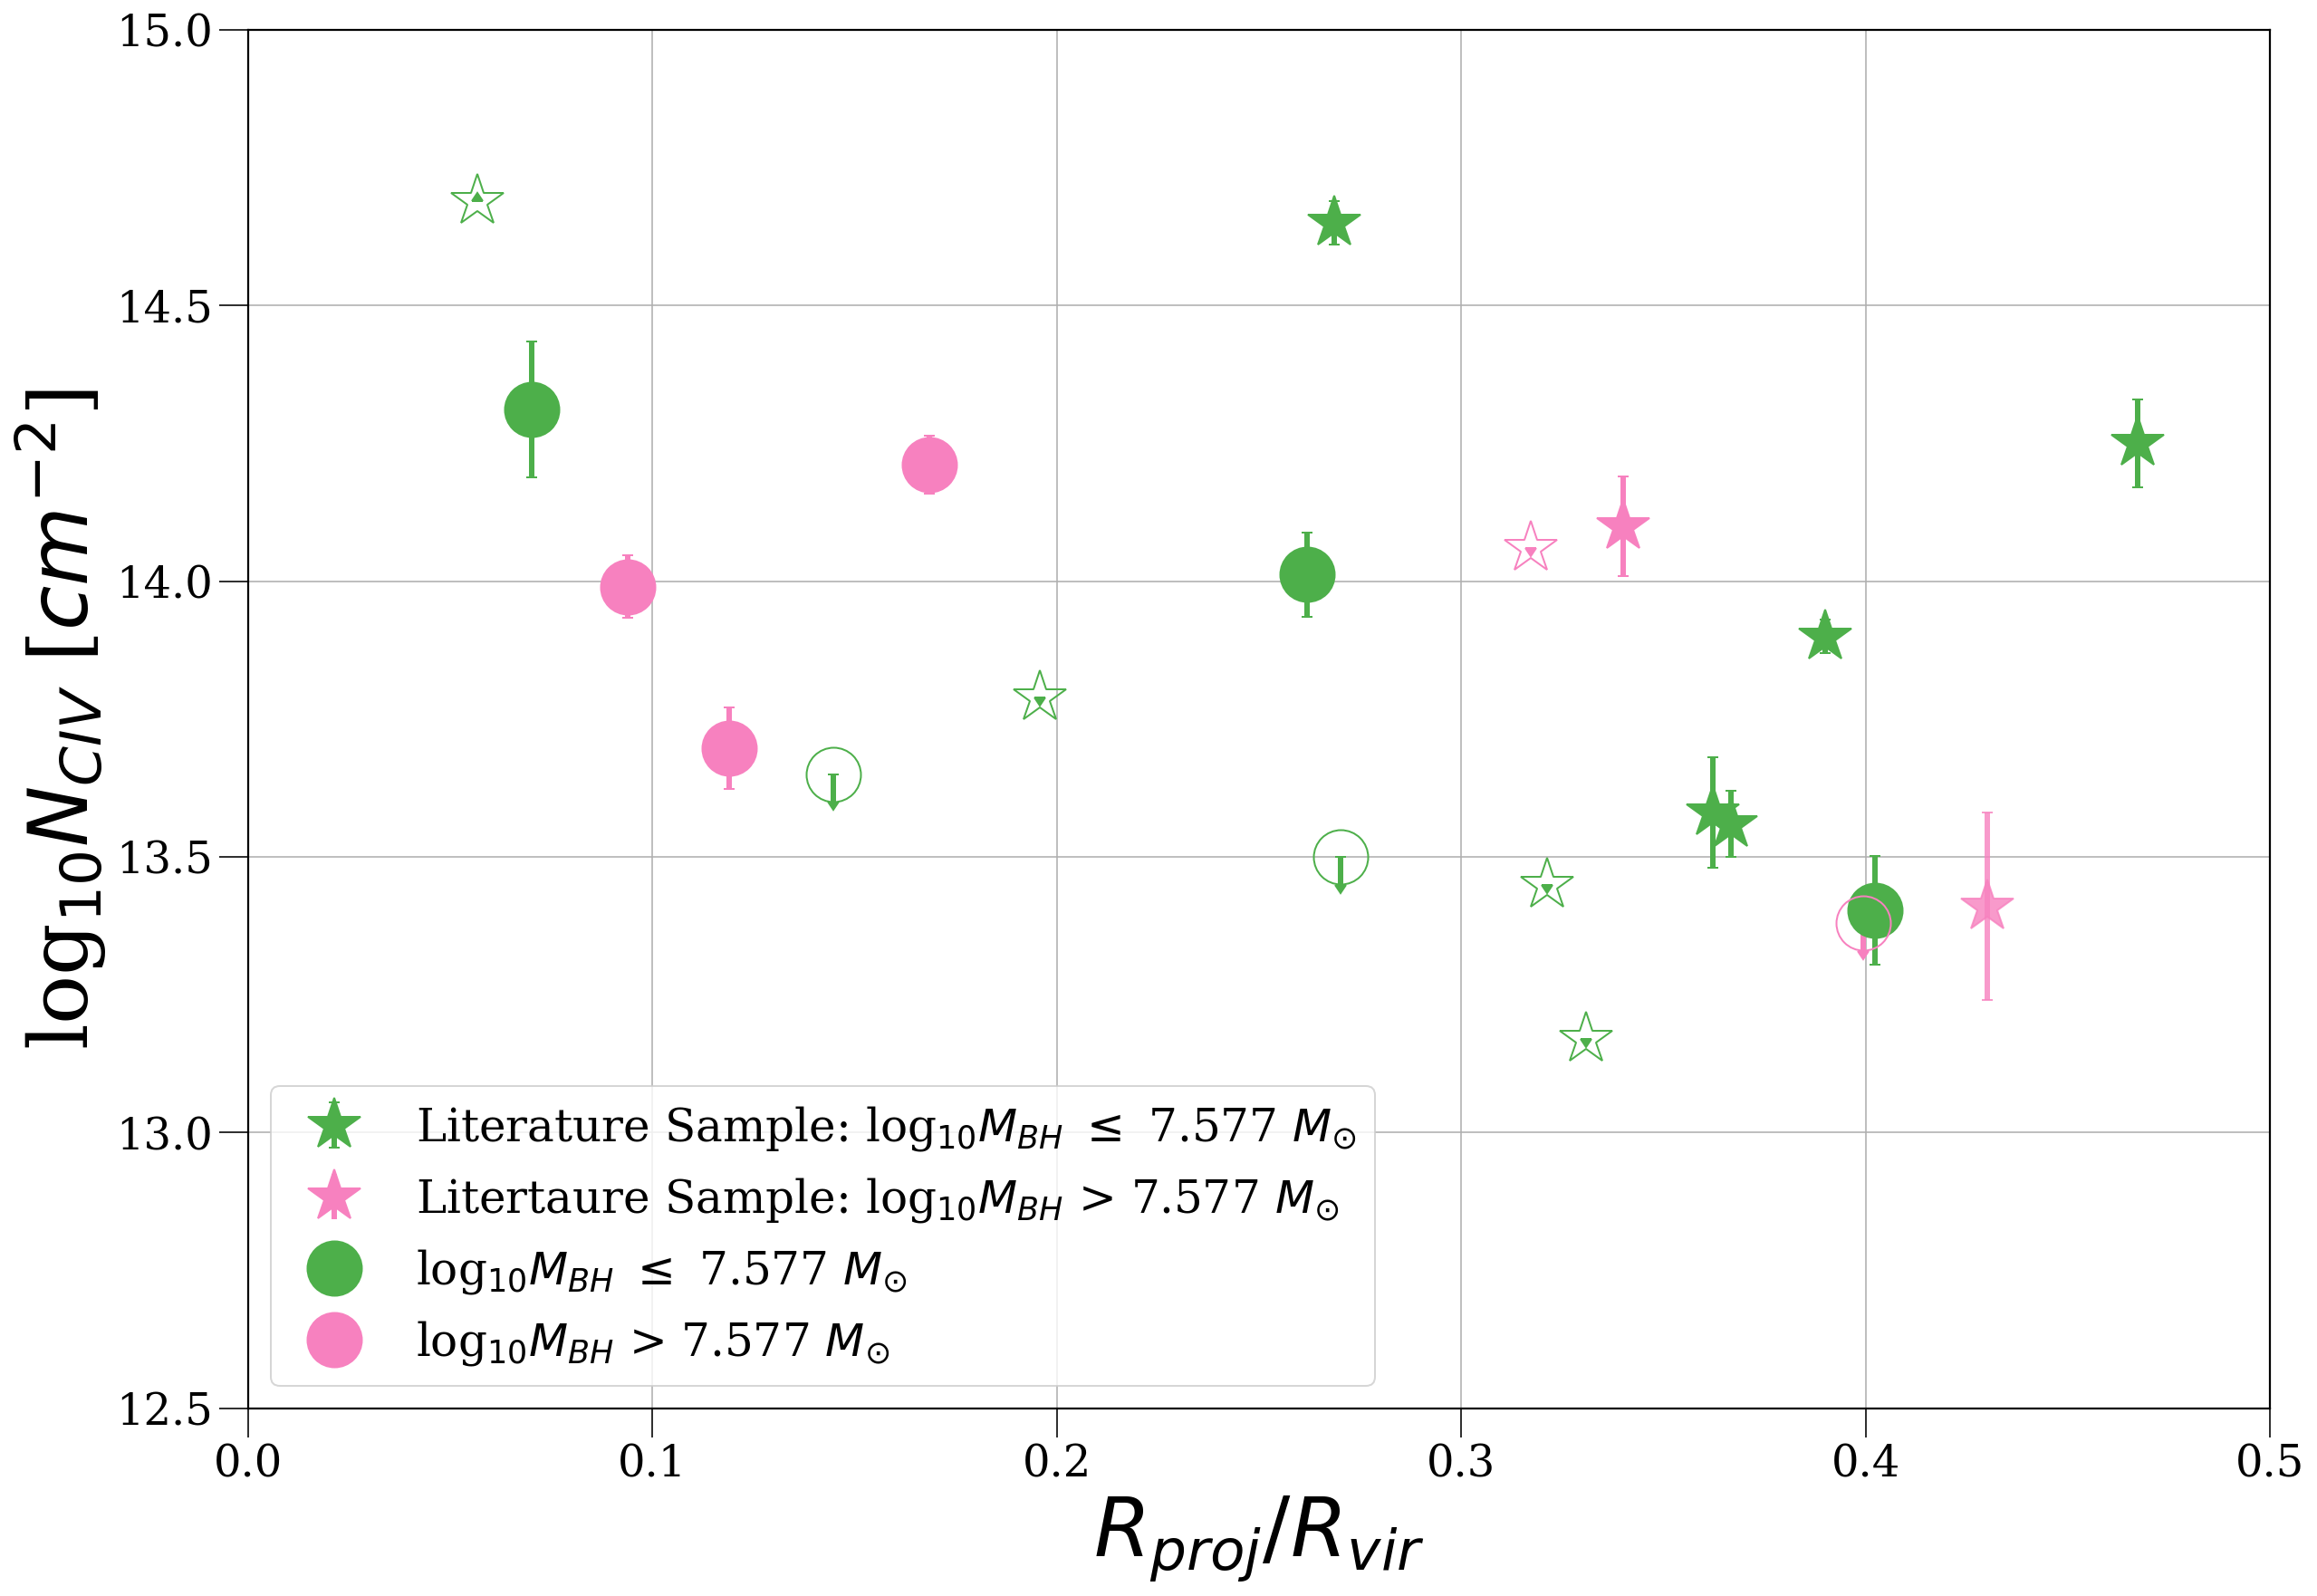

In [91]:
#Plotting NCIV vs R/Rvir     
fig, ax = plt.subplots()

########################################################

#Literature Sample 

########################################################


# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (AMIGA['Rproj/Rvir'], AMIGA['N'], yerr=AMIGA['sigN'],capsize = 3, c = CB_color_cycle[3], 
              alpha=0.8, marker="*", markersize=30, ls='none', elinewidth=3)

########################################################


########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth, high_mask_borth], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Literature Sample: log$_{10}M_{BH}$ $\leq$ 7.577 $M_{\odot}$", 
                                r"Litertaure Sample: log$_{10}M_{BH}$ > 7.577 $M_{\odot}$"]):
    
    ax.errorbar(borth_det['Rproj/Rvir'][mask], borth_det['N'][mask],yerr=borth_det['sigN'][mask], #xerr=borth_det['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=30, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(borth_uplim['Rproj/Rvir'][mask], borth_uplim['N'][mask],yerr=borth_uplim['sigN'][mask], #xerr=borth_uplim['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)
    
########## Bordoloi ##########
    
for mask, colour, in zip([low_mask_bord, high_mask_bord], [CB_color_cycle[2],CB_color_cycle[3]]):
    
    ax.errorbar(bord_det['Rproj/Rvir'][mask], bord_det['N'][mask],yerr=bord_det['sigN'][mask], #xerr=bord_det['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=30, ls='none', elinewidth=3)
    
    ax.errorbar(bord_uplim['Rproj/Rvir'][mask], bord_uplim['N'][mask],yerr=bord_uplim['sigN'][mask], #xerr=bord_uplim['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)
    
    ax.errorbar(bord_lolim['Rproj/Rvir'][mask], bord_lolim['N'][mask],yerr=bord_lolim['sigN'][mask], #xerr=bord_lolim['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=3)
    
########## COS-HAlOS ##########

for mask, colour in zip([low_mask_halos, high_mask_halos], [CB_color_cycle[2],CB_color_cycle[3]]):
    
    ax.errorbar(COSHALOS['Rproj/Rvir'][mask], COSHALOS['N'][mask],yerr=COSHALOS['sigN'][mask], 
                capsize = 3, c = colour, marker="*", markersize=30, ls='none', elinewidth=3)


########################################################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.577 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.577 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker="o", markersize=30, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker="o", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)
    

ax.legend(loc=3, fontsize=25)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(12.5, 15)
ax.set_xlim(0, 0.5)
ax.grid(True)
#plt.savefig('Figures/nciv_r25_vs_rr.png')
plt.show()

#### Making radial profiles for COS and Lit Points so it kinda matches Figure 5

In [97]:
#Splitting COSlit sample up so that I can make the fits for each 

coslit_low = coslit.loc[(coslit['MBH'] <= 7.16)]
#coslit_low

coslit_high = coslit.loc[(coslit['MBH'] > 7.16)]
#coslit_high

In [98]:
#LOW FIT

XX =  np.copy(coslit_low['Rproj/Rvir']) #Getting the impact parameter from my galaxy parameters table 
YY = np.copy(coslit_low["N"]) #getting the column density of CIV from main data table 
YY_err = np.copy(coslit_low["sigN"]) #column density error of CIV 
UL = np.copy(coslit_low['uplim']) #1 = det and 0= uplim 
has_UL = UL < 1 #determining the ones that have upper limts (in his table they are denoted with -1 in the error column) T/F

Ylim = np.zeros_like(XX, dtype = int) #Return an array of zeros with the same shape and type as the impact parameters (XX)
Ylim[has_UL] = 1 #if this array has a -1 values (upper limit) then it is given the value of 1 
Xlim = np.zeros_like(XX, dtype = int) #Return an array of zeros with the same shape and type as the impact parameters (XX)

coeff = "kendallt" # the correlation coefficient 
Nboot = 10_000 #number of bootstrapping iterations over which the uncertainties are estimated 

xCrr = XX #same as XX => impact parameters 
yCrr = YY #same as YY => column densities 
yCrr_err = YY_err #same as YY_err => column density error 
xlimCrr = Xlim #array of 0s same length as XX or Xlim 
ylimCrr = Ylim #array od 0s and 1s same length as YY or Ylim (1 if it is an upper limit)

kwargs = {"return_dist":True}
res = pymccorrelation(xCrr, yCrr, xlim = xlimCrr, ylim = ylimCrr, coeff = coeff, Nboot = Nboot, **kwargs)

outCrr = {} #Where the stat information is stored 

outCrr["coeff_percentiles"] = res[0]
outCrr["p-value_percentiles"] = res[1]
outCrr["coeff_dist"] = res[2]
outCrr["p-value_dist"] = res[3]

mc_datarr = {
    "Ion":["CIV"]*len(outCrr["coeff_dist"]),
    r"Kendall's $\tau$":outCrr["coeff_dist"],
    r"$\log_{10}$(p-value)":np.log10(outCrr["p-value_dist"])
}

In [99]:
upper_lim_Crr = yCrr_err < 0 #a mask to find the upper limits for later stuff I think 

delta_Crr = np.invert(upper_lim_Crr) #array of True and False 
xsig_Crr = np.zeros_like(xCrr) #array of 0s like xC => like XX => the impact parameters bc they dont have error oh i see
ysig_Crr = yCrr_err[:] #error of the column densities 

lmcens_Crr = linmix.LinMix(xCrr, yCrr, xsig_Crr, ysig_Crr, delta=delta_Crr, K=2)
lmcens_Crr.run_mcmc(silent=True)

yints_Crr = lmcens_Crr.chain['alpha'] #same shape as the Nboot (looks like 12-14 values)
slopes_Crr = lmcens_Crr.chain['beta'] #same shape as the Nboot (looks like very very small values)

mean_yint_Crr = yints_Crr.mean() #mean alpha value (~14)
mean_slope_Crr = slopes_Crr.mean() #mean beta value (~ -0.010)

xxrr_low = np.linspace(0,1,1000) #This is how long the line is gonna be
all_lines_low = np.array([m*xxrr_low + b for (m,b) in zip(slopes_Crr, yints_Crr)]) #makng the equation

lo_line_low, med_line_low, hi_line_low = np.percentile(all_lines_low, (16,50,84), axis = 0) #percentiles for stats knowledge
mean_line_low = mean_slope_Crr*xxrr_low + mean_yint_Crr #mean line equation

In [100]:
#HIGH FIT

XX =  np.copy(coslit_high['Rproj/Rvir']) #Getting the impact parameter from my galaxy parameters table 
YY = np.copy(coslit_high["N"]) #getting the column density of CIV from main data table 
YY_err = np.copy(coslit_high["sigN"]) #column density error of CIV 
UL = np.copy(coslit_high['uplim']) #1 = det and 0= uplim 
has_UL = UL < 1 #determining the ones that have upper limts (in his table they are denoted with -1 in the error column) T/F

Ylim = np.zeros_like(XX, dtype = int) #Return an array of zeros with the same shape and type as the impact parameters (XX)
Ylim[has_UL] = 1 #if this array has a -1 values (upper limit) then it is given the value of 1 
Xlim = np.zeros_like(XX, dtype = int) #Return an array of zeros with the same shape and type as the impact parameters (XX)

coeff = "kendallt" # the correlation coefficient 
Nboot = 10_000 #number of bootstrapping iterations over which the uncertainties are estimated 

xCrr = XX #same as XX => impact parameters 
yCrr = YY #same as YY => column densities 
yCrr_err = YY_err #same as YY_err => column density error 
xlimCrr = Xlim #array of 0s same length as XX or Xlim 
ylimCrr = Ylim #array od 0s and 1s same length as YY or Ylim (1 if it is an upper limit)

kwargs = {"return_dist":True}
res = pymccorrelation(xCrr, yCrr, xlim = xlimCrr, ylim = ylimCrr, coeff = coeff, Nboot = Nboot, **kwargs)

outCrr = {} #Where the stat information is stored 

outCrr["coeff_percentiles"] = res[0]
outCrr["p-value_percentiles"] = res[1]
outCrr["coeff_dist"] = res[2]
outCrr["p-value_dist"] = res[3]

mc_datarr = {
    "Ion":["CIV"]*len(outCrr["coeff_dist"]),
    r"Kendall's $\tau$":outCrr["coeff_dist"],
    r"$\log_{10}$(p-value)":np.log10(outCrr["p-value_dist"])
}

In [101]:
upper_lim_Crr = yCrr_err < 0 #a mask to find the upper limits for later stuff I think 

delta_Crr = np.invert(upper_lim_Crr) #array of True and False 
xsig_Crr = np.zeros_like(xCrr) #array of 0s like xC => like XX => the impact parameters bc they dont have error oh i see
ysig_Crr = yCrr_err[:] #error of the column densities 

lmcens_Crr = linmix.LinMix(xCrr, yCrr, xsig_Crr, ysig_Crr, delta=delta_Crr, K=2)
lmcens_Crr.run_mcmc(silent=True)

yints_Crr = lmcens_Crr.chain['alpha'] #same shape as the Nboot (looks like 12-14 values)
slopes_Crr = lmcens_Crr.chain['beta'] #same shape as the Nboot (looks like very very small values)

mean_yint_Crr = yints_Crr.mean() #mean alpha value (~14)
mean_slope_Crr = slopes_Crr.mean() #mean beta value (~ -0.010)

xxrr_high = np.linspace(0,1,1000) #This is how long the line is gonna be
all_lines_high = np.array([m*xxrr_high + b for (m,b) in zip(slopes_Crr, yints_Crr)]) #makng the equation

lo_line_high, med_line_high, hi_line_high = np.percentile(all_lines_high, (16,50,84), axis = 0) #percentiles for stats knowledge
mean_line_high = mean_slope_Crr*xxrr_high + mean_yint_Crr #mean line equation

<>:9: DeprecationWarning: invalid escape sequence \l
<>:14: DeprecationWarning: invalid escape sequence \o
<>:9: DeprecationWarning: invalid escape sequence \l
<>:14: DeprecationWarning: invalid escape sequence \o
<>:9: DeprecationWarning: invalid escape sequence \l
<>:14: DeprecationWarning: invalid escape sequence \o
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_98141/3266411565.py:9: DeprecationWarning: invalid escape sequence \l
  plt.plot(xxrr_low, mean_line_low, color = CB_color_cycle[2], alpha = 0.8,lw = 5, ls = "-", label='log$_{10}M_{BH}$ $\leq$ 7.16 $M_{\odot}$ Best Fit')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_98141/3266411565.py:14: DeprecationWarning: invalid escape sequence \o
  plt.plot(xxrr_high, mean_line_high, color = CB_color_cycle[3], alpha = 0.8,lw = 5, ls = "-", label='log$_{10}M_{BH}$ > 7.16 $M_{\odot}$ Best Fit')


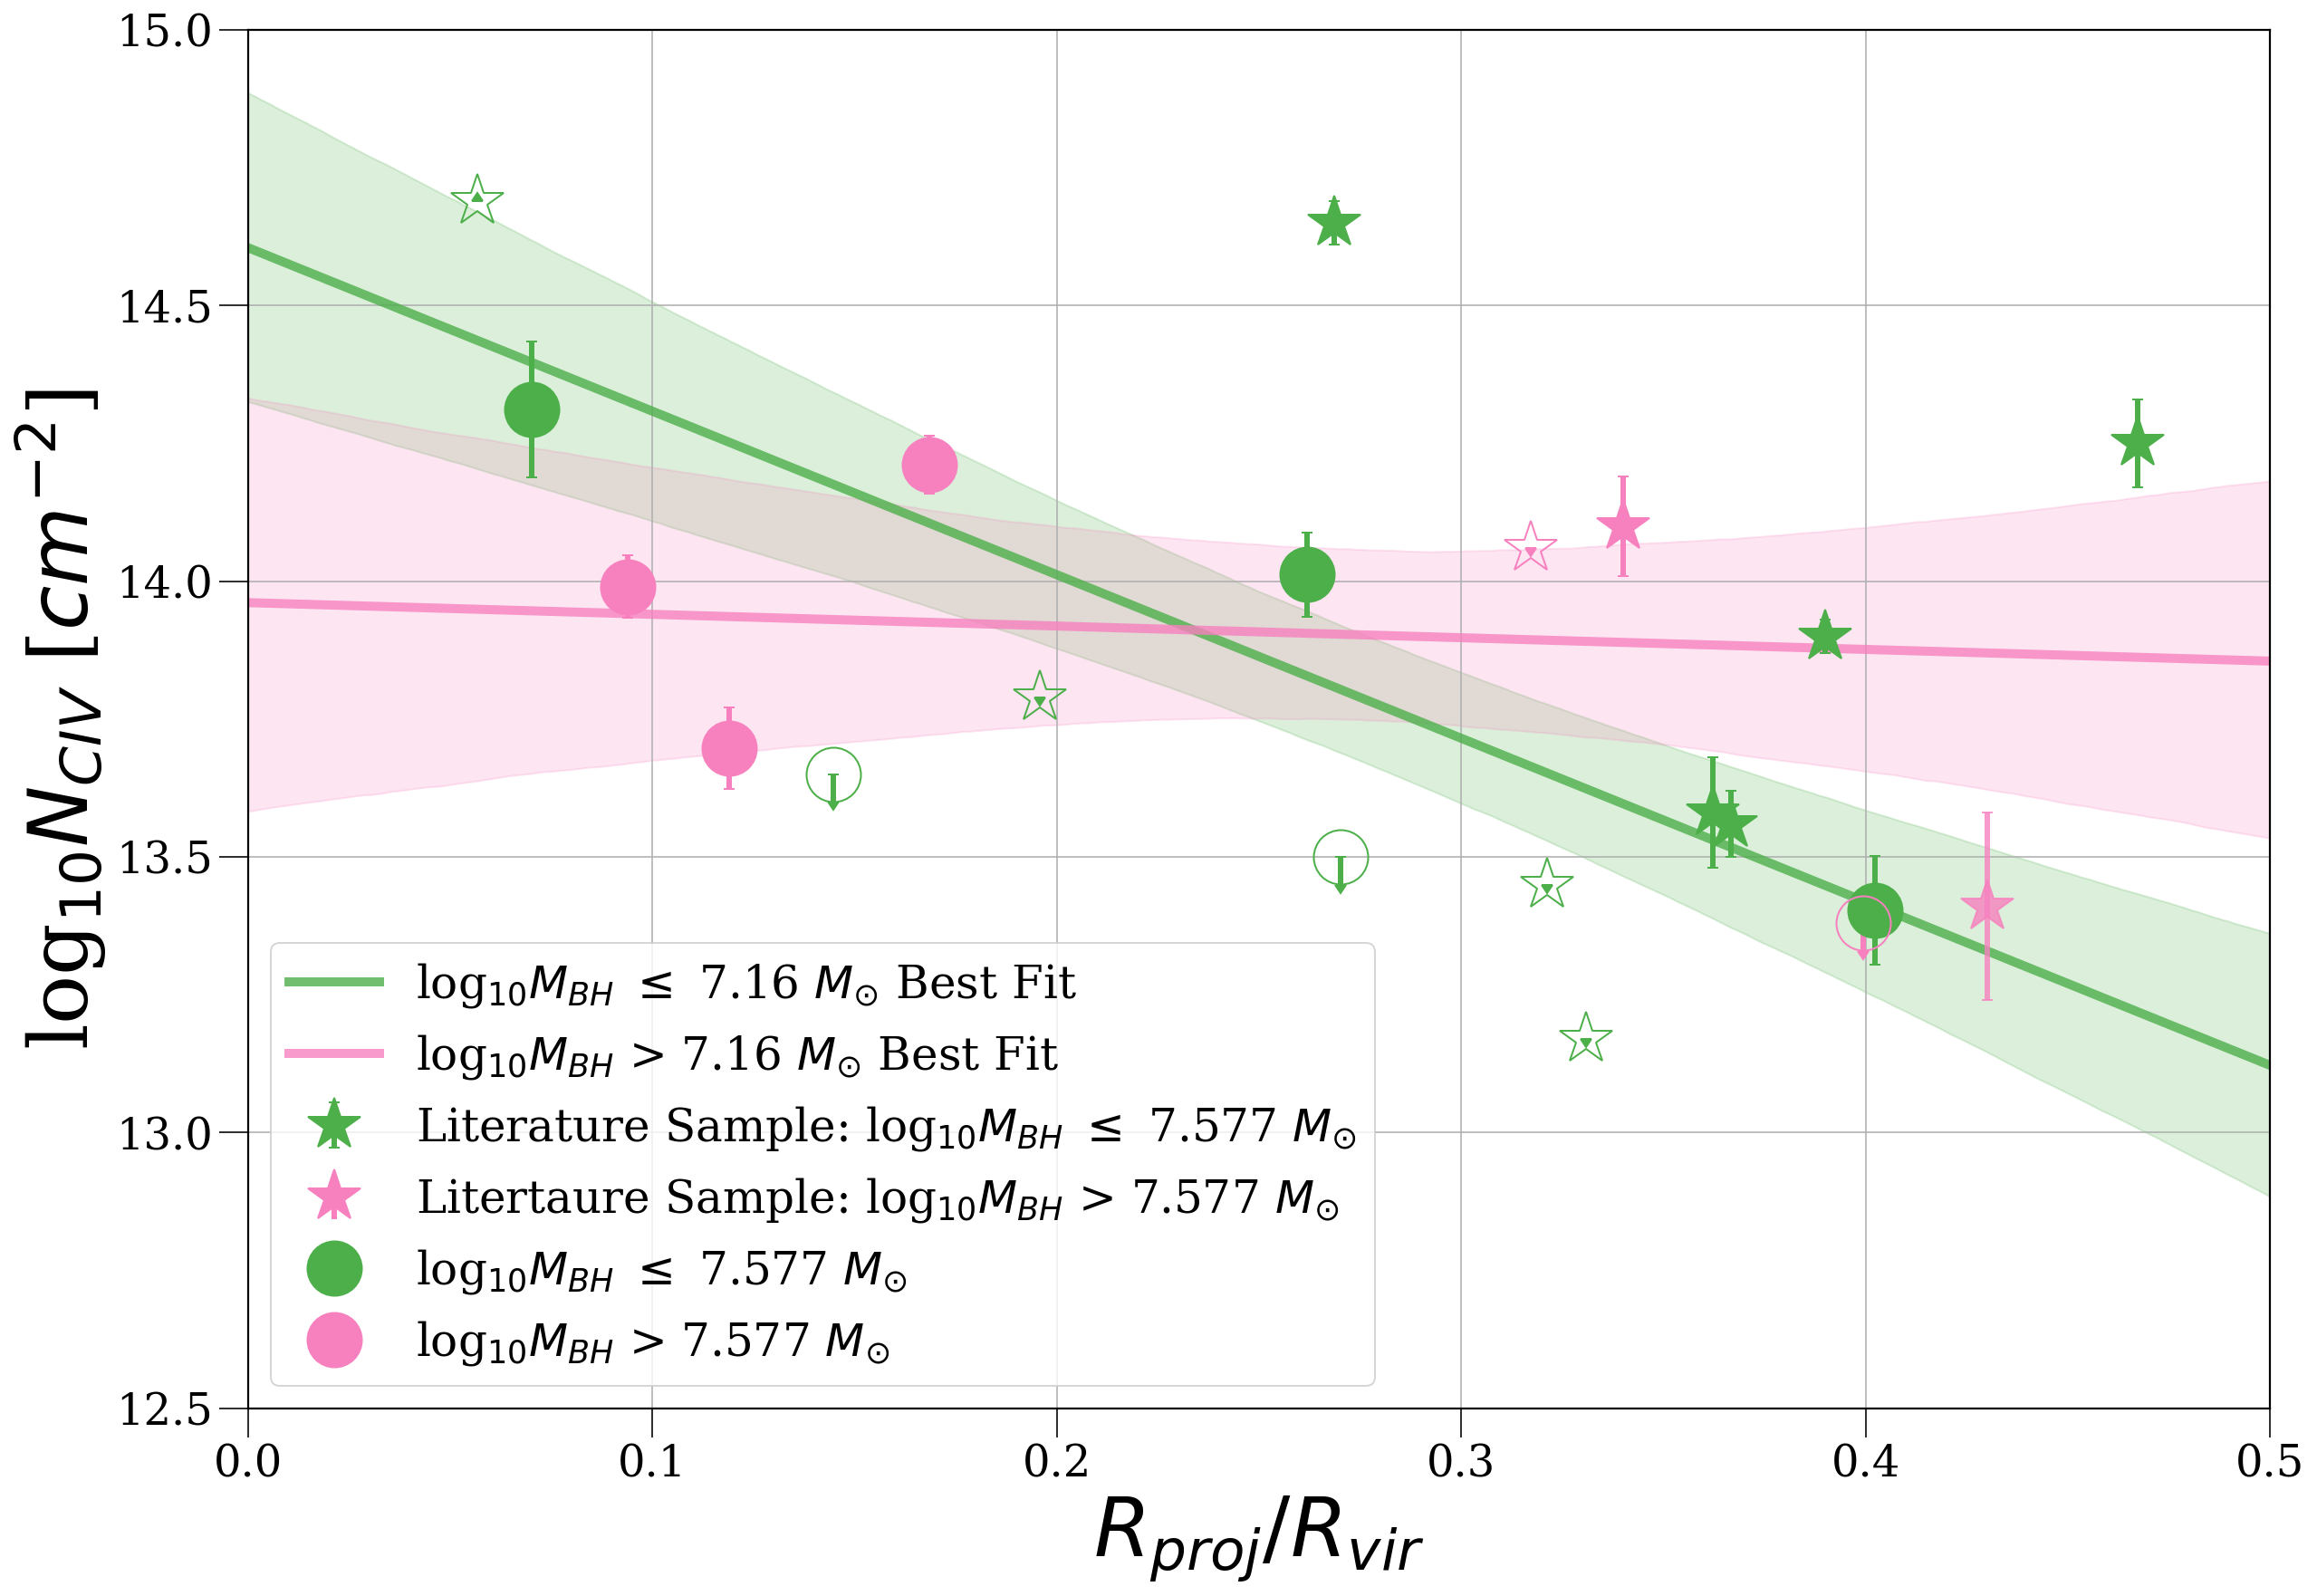

In [102]:
#Plotting NCIV vs R/Rvir     
fig, ax = plt.subplots()

########################################################

###Fits###

#Low Fit 
plt.plot(xxrr_low, mean_line_low, color = CB_color_cycle[2], alpha = 0.8,lw = 5, ls = "-", label='log$_{10}M_{BH}$ $\leq$ 7.16 $M_{\odot}$ Best Fit')
plt.fill_between(xxrr_low, lo_line_low, hi_line_low, color =CB_color_cycle[2], alpha = 0.2)


#High Fit 
plt.plot(xxrr_high, mean_line_high, color = CB_color_cycle[3], alpha = 0.8,lw = 5, ls = "-", label='log$_{10}M_{BH}$ > 7.16 $M_{\odot}$ Best Fit')
plt.fill_between(xxrr_high, lo_line_high, hi_line_high, color =CB_color_cycle[3], alpha = 0.2)

#Literature Sample 

########################################################


# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (AMIGA['Rproj/Rvir'], AMIGA['N'], yerr=AMIGA['sigN'],capsize = 3, c = CB_color_cycle[3], 
              alpha=0.8, marker="*", markersize=30, ls='none', elinewidth=3)

########################################################


########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth, high_mask_borth], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"Literature Sample: log$_{10}M_{BH}$ $\leq$ 7.577 $M_{\odot}$", 
                                r"Litertaure Sample: log$_{10}M_{BH}$ > 7.577 $M_{\odot}$"]):
    
    ax.errorbar(borth_det['Rproj/Rvir'][mask], borth_det['N'][mask],yerr=borth_det['sigN'][mask], #xerr=borth_det['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=30, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(borth_uplim['Rproj/Rvir'][mask], borth_uplim['N'][mask],yerr=borth_uplim['sigN'][mask], #xerr=borth_uplim['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)
    
########## Bordoloi ##########
    
for mask, colour, in zip([low_mask_bord, high_mask_bord], [CB_color_cycle[2],CB_color_cycle[3]]):
    
    ax.errorbar(bord_det['Rproj/Rvir'][mask], bord_det['N'][mask],yerr=bord_det['sigN'][mask], #xerr=bord_det['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=30, ls='none', elinewidth=3)
    
    ax.errorbar(bord_uplim['Rproj/Rvir'][mask], bord_uplim['N'][mask],yerr=bord_uplim['sigN'][mask], #xerr=bord_uplim['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)
    
    ax.errorbar(bord_lolim['Rproj/Rvir'][mask], bord_lolim['N'][mask],yerr=bord_lolim['sigN'][mask], #xerr=bord_lolim['MBH_err'][mask],
                capsize = 3, c = colour, marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=3)
    
########## COS-HAlOS ##########

for mask, colour in zip([low_mask_halos, high_mask_halos], [CB_color_cycle[2],CB_color_cycle[3]]):
    
    ax.errorbar(COSHALOS['Rproj/Rvir'][mask], COSHALOS['N'][mask],yerr=COSHALOS['sigN'][mask], 
                capsize = 3, c = colour, marker="*", markersize=30, ls='none', elinewidth=3)


########################################################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.577 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.577 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker="o", markersize=30, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker="o", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)
    

ax.legend(loc=3, fontsize=25)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(12.5, 15)
ax.set_xlim(0, 0.5)
ax.grid(True)
#plt.savefig('Figures/nciv_r25_vs_rr.png')
plt.show()

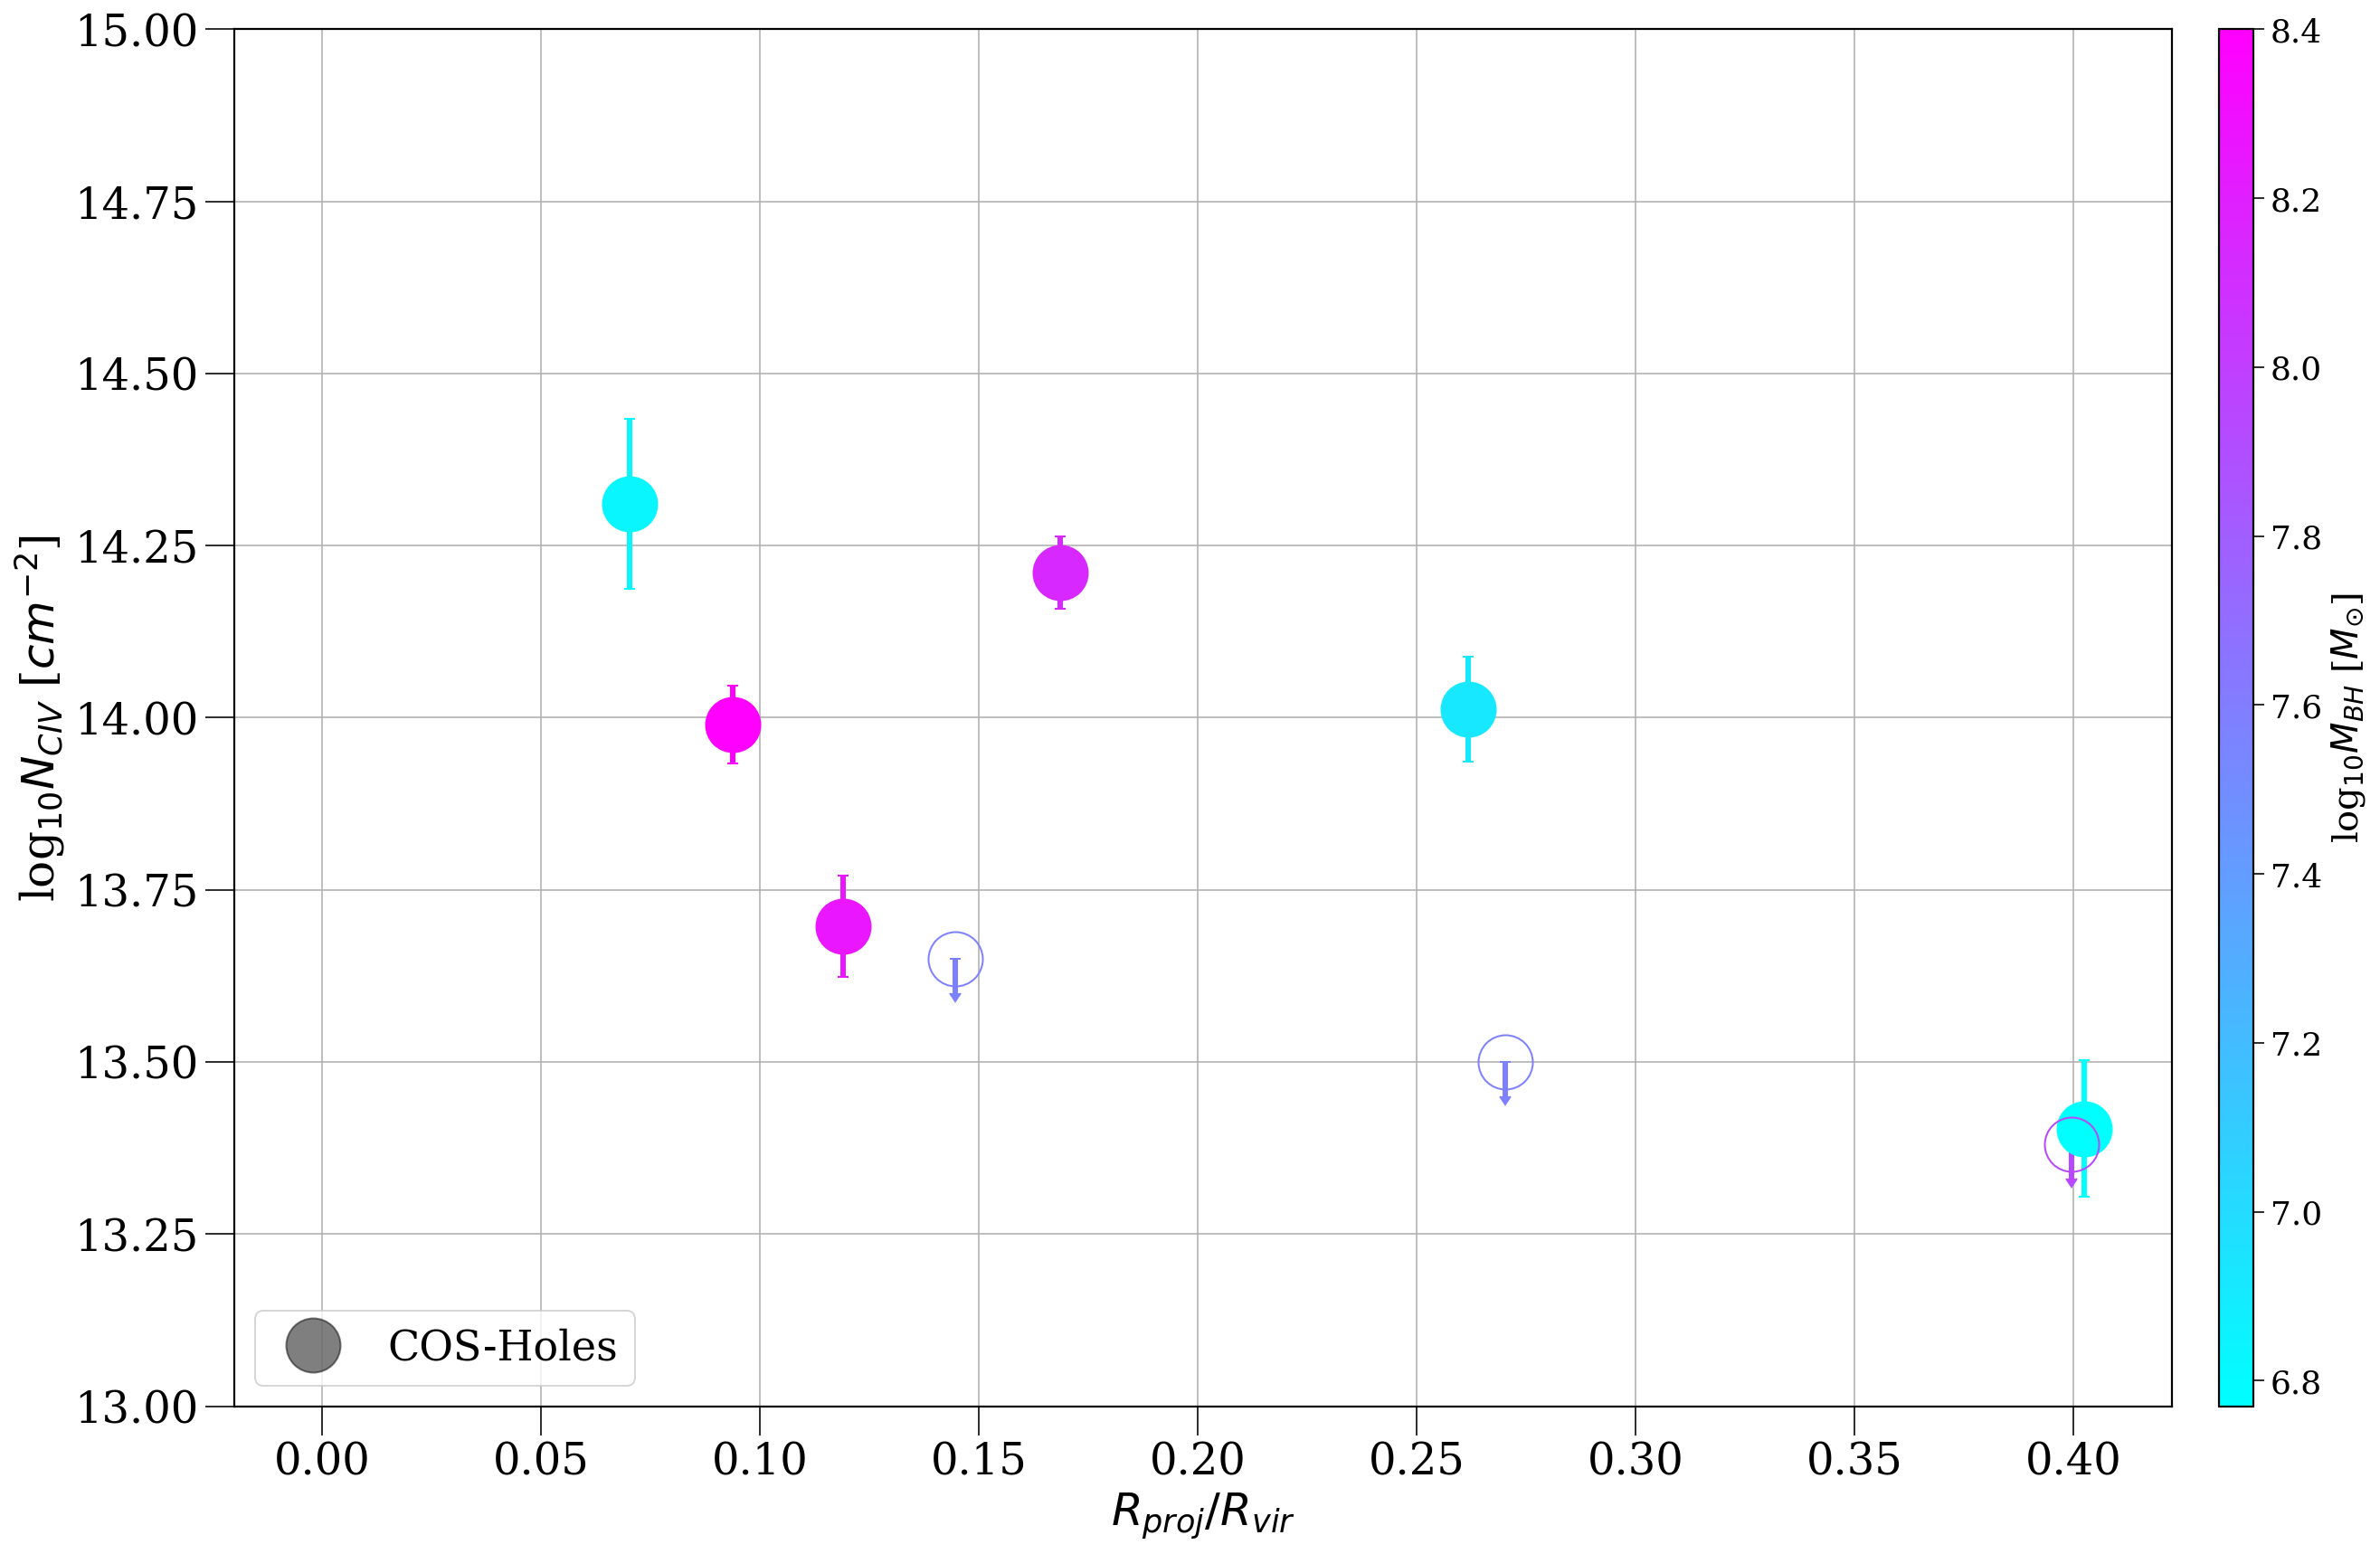

In [84]:
# Set figure size, I like this for 1 plot w colorbar but yaknow whateva
fig = plt.figure()

UL = np.array(coslit['uplim'])
has_UL = UL < 1

# Set a grid on your figure so you can define the color bar axis
axs = fig.add_gridspec(1, 50)

# Define the plot and the colorbar axes
plot = fig.add_subplot(axs[0, 0:48]) # this means use cols 0 - 49
cbar = fig.add_subplot(axs[0, 49])

# Now lets get the colors for ur points, luckily you have the values ...
# ... you want the colors to correspond to defined above as array 'c'
cool = plt.cm.get_cmap('cool')

#c = np.asarray(coslit['MBH'])
c = np.asarray(cos_sup['MBH'])
c_normed = (c-min(c))/(max(c)-min(c))
coloring = cool(c_normed) # you can replace plasma with whatev


# Okay now plotting, same as above but made the color our new defined one
# It gets mad at you without the loop cuz its dumb
r_arr = np.array(cos_sup['Rproj/Rvir'])
N_arr = np.array(cos_sup['N'])
sigN_arr = np.array(cos_sup['sigN'])
#sigmbh_arr = np.array(coslit['sigMBH'])
uplim_arr = np.array(cos_sup['uplim'])
marker_types = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o','o']


#need to have unassigned shapes to represent the 4 datasets but not have them show up on the plot 
#plot.plot(0,0, c='k', marker='*', markersize=30, ls='none', label='Literature Sample', alpha=0.5)
#plot.plot(0,0, c='k', marker='H', markersize=30, ls='none', label='Werk+13: COS-Halos', alpha=0.5)
#plot.plot(0,0, c='k', marker='d', markersize=30, ls='none', label='Borthakur+14: COS-Dwarfs', alpha=0.5)
#plot.plot(0,0, c='k', marker='p', markersize=30, ls='none', label='Lehner+20: Project AMIGA', alpha=0.5)
plot.plot(0,0, c='k', marker='o', markersize=30, ls='none', label='COS-Holes', alpha=0.5)


for i in range(len(r_arr)):
    if uplim_arr[i] < 1:  
        plot.errorbar(r_arr[i], N_arr[i], 
                yerr=sigN_arr[i],  
                capsize = 3, c=coloring[i], marker= marker_types[i], 
                markersize=30, ls='none', elinewidth=3, mfc='none', uplims=True)
    else: 
        plot.errorbar(r_arr[i], N_arr[i], 
                yerr=sigN_arr[i], 
                capsize = 3, c=coloring[i], marker=marker_types[i], 
                markersize=30, ls='none', elinewidth=3)
    
# I changed some of your sizes cause they looked too big with my code ig

# Here's where the magic happens
# Set up normalization for the color bar
# (sets lowest color to min value and highest color to max value)
norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))

# make the color bar
#cmap = mpl.colors.ListedColormap(coloring, name='Rproj/Rvir')

# !!!!! Use this instead to make the colorbar look continuous gradient:
cmap = cool

# mapping for the color bar
mapping = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# do the thing, telling it to use the subplot you created for the ...
# ... color bar (cax = cbar)
colorbar = fig.colorbar(mapping, cax=cbar, orientation='vertical')

# Okay now it's created, the rest is just visual preference:
colorbar.ax.tick_params(length=6, labelsize=18)
colorbar.ax.spines['top'].set_linewidth(1.5)
colorbar.ax.spines['bottom'].set_linewidth(1.5)
colorbar.ax.spines['left'].set_linewidth(1.5)
colorbar.ax.spines['right'].set_linewidth(1.5)
colorbar.set_label(label=r'log$_{10}M_{BH}$ [$M_{\odot}$]', size=20)

# Your other stylings from above:
plot.legend(loc=3, fontsize=23) # Theres no labels for your legend but ill leave it
plot.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=25)
plot.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=25)
plot.set_ylim([13, 15])
#plot.set_xlim([4, 9])
plot.grid(True)
#plt.tight_layout()
plt.show()

In [77]:
c_mbh_na = np.array([6.77      , 8.255     , 6.83      , 8.4       , 6.92      ,
       8.14      , 7.577     , 7.577     , 7.94      , 6.10533953,
       7.62918901, 7.16002989, 7.39812803, 5.4467845 , 5.446,
       5.446, 5.446, 6.12716341, 7.7057337 , 6.15592829, 8.15])
c_mbh_na

array([6.77      , 8.255     , 6.83      , 8.4       , 6.92      ,
       8.14      , 7.577     , 7.577     , 7.94      , 6.10533953,
       7.62918901, 7.16002989, 7.39812803, 5.4467845 , 5.446     ,
       5.446     , 5.446     , 6.12716341, 7.7057337 , 6.15592829,
       8.15      ])

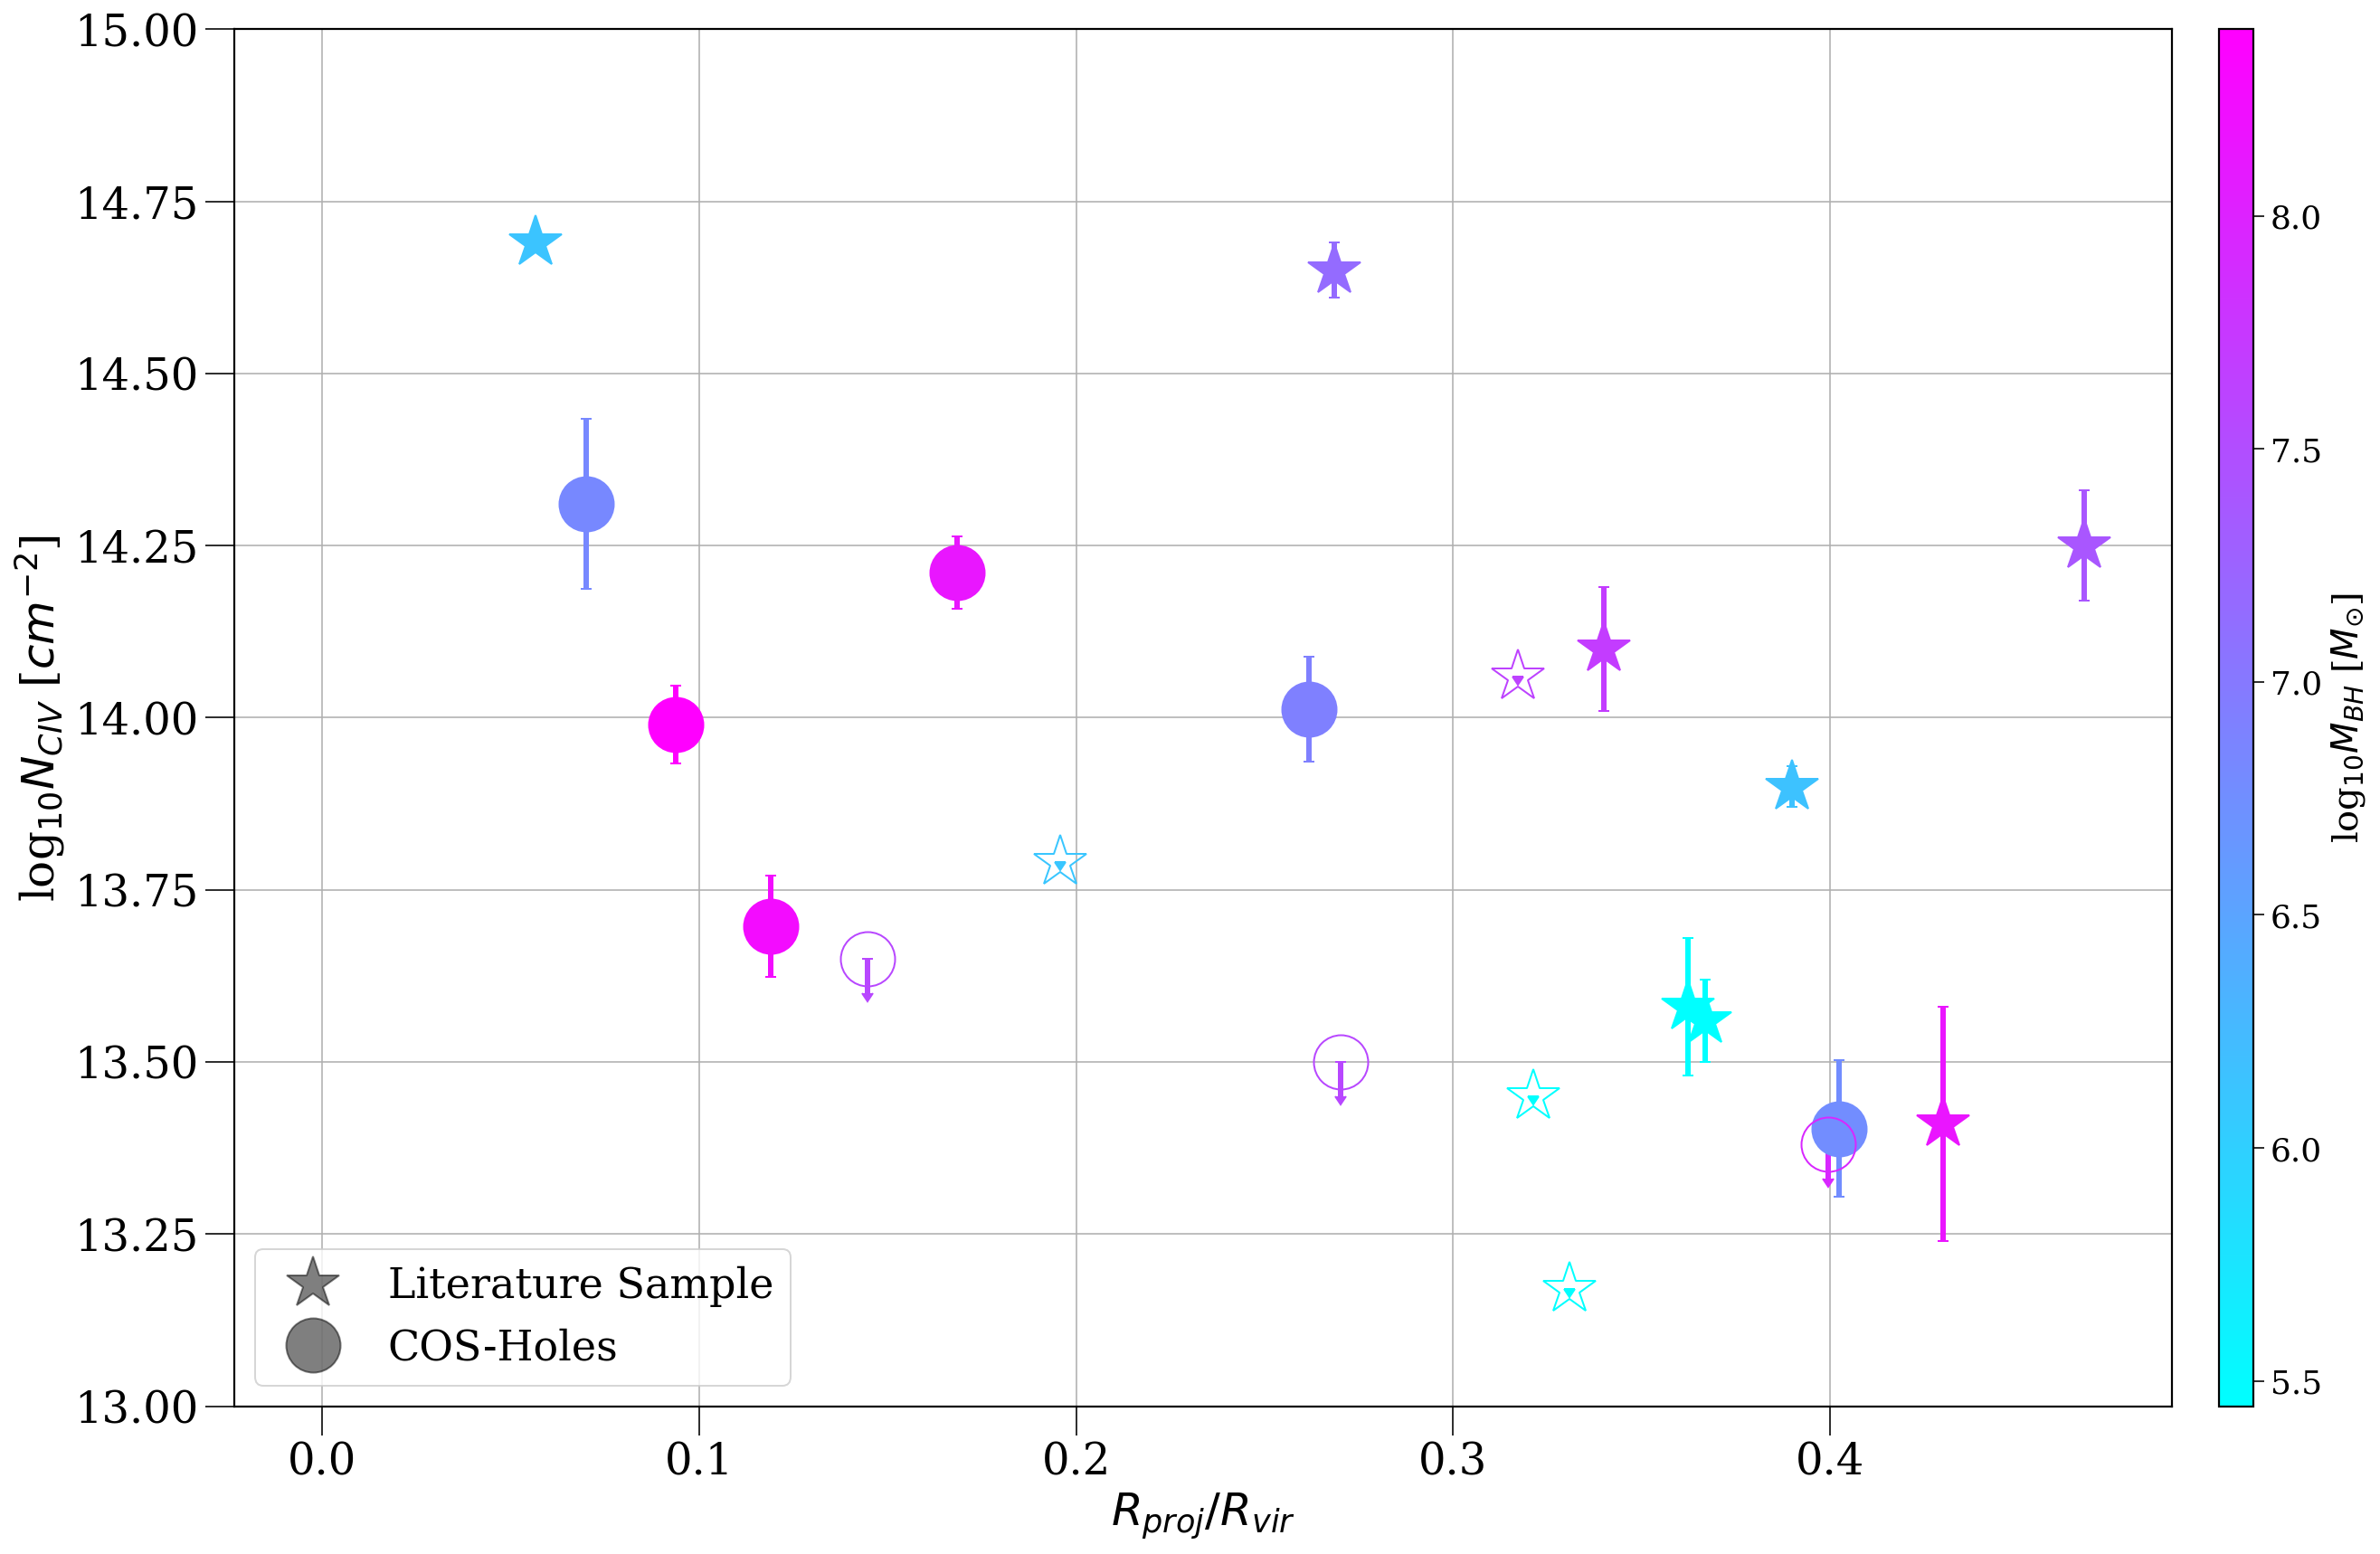

In [78]:
# Set figure size, I like this for 1 plot w colorbar but yaknow whateva
fig = plt.figure()

UL = np.array(coslit['uplim'])
has_UL = UL < 1

# Set a grid on your figure so you can define the color bar axis
axs = fig.add_gridspec(1, 50)

# Define the plot and the colorbar axes
plot = fig.add_subplot(axs[0, 0:48]) # this means use cols 0 - 49
cbar = fig.add_subplot(axs[0, 49])

# Now lets get the colors for ur points, luckily you have the values ...
# ... you want the colors to correspond to defined above as array 'c'
cool = plt.cm.get_cmap('cool')

#c = np.asarray(coslit['MBH'])
c = c_mbh_na
c_normed = (c-min(c))/(max(c)-min(c))
coloring = cool(c_normed) # you can replace plasma with whatev


# Okay now plotting, same as above but made the color our new defined one
# It gets mad at you without the loop cuz its dumb
r_arr = np.array(coslit['Rproj/Rvir'])
N_arr = np.array(coslit['N'])
sigN_arr = np.array(coslit['sigN'])
#sigmbh_arr = np.array(coslit['sigMBH'])
uplim_arr = np.array(coslit['uplim'])
marker_types = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o','o', 
                '*', '*', '*', '*', 
               '*', '*', '*', '*', '*', 
               '*', '*',
               '*']


#need to have unassigned shapes to represent the 4 datasets but not have them show up on the plot 
plot.plot(0,0, c='k', marker='*', markersize=30, ls='none', label='Literature Sample', alpha=0.5)
#plot.plot(0,0, c='k', marker='H', markersize=30, ls='none', label='Werk+13: COS-Halos', alpha=0.5)
#plot.plot(0,0, c='k', marker='d', markersize=30, ls='none', label='Borthakur+14: COS-Dwarfs', alpha=0.5)
#plot.plot(0,0, c='k', marker='p', markersize=30, ls='none', label='Lehner+20: Project AMIGA', alpha=0.5)
plot.plot(0,0, c='k', marker='o', markersize=30, ls='none', label='COS-Holes', alpha=0.5)


for i in range(len(r_arr)):
    if uplim_arr[i] < 1:  
        plot.errorbar(r_arr[i], N_arr[i], 
                yerr=sigN_arr[i],  
                capsize = 3, c=coloring[i], marker= marker_types[i], 
                markersize=30, ls='none', elinewidth=3, mfc='none', uplims=True)
    else: 
        plot.errorbar(r_arr[i], N_arr[i], 
                yerr=sigN_arr[i], 
                capsize = 3, c=coloring[i], marker=marker_types[i], 
                markersize=30, ls='none', elinewidth=3)
    
# I changed some of your sizes cause they looked too big with my code ig

# Here's where the magic happens
# Set up normalization for the color bar
# (sets lowest color to min value and highest color to max value)
norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))

# make the color bar
#cmap = mpl.colors.ListedColormap(coloring, name='Rproj/Rvir')

# !!!!! Use this instead to make the colorbar look continuous gradient:
cmap = cool

# mapping for the color bar
mapping = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# do the thing, telling it to use the subplot you created for the ...
# ... color bar (cax = cbar)
colorbar = fig.colorbar(mapping, cax=cbar, orientation='vertical')

# Okay now it's created, the rest is just visual preference:
colorbar.ax.tick_params(length=6, labelsize=18)
colorbar.ax.spines['top'].set_linewidth(1.5)
colorbar.ax.spines['bottom'].set_linewidth(1.5)
colorbar.ax.spines['left'].set_linewidth(1.5)
colorbar.ax.spines['right'].set_linewidth(1.5)
colorbar.set_label(label=r'log$_{10}M_{BH}$ [$M_{\odot}$]', size=20)

# Your other stylings from above:
plot.legend(loc=3, fontsize=23) # Theres no labels for your legend but ill leave it
plot.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=25)
plot.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=25)
plot.set_ylim([13, 15])
#plot.set_xlim([4, 9])
plot.grid(True)
#plt.tight_layout()
plt.show()

## Simulation Panel Figure 

In [103]:
########################################################

# R25: New Data from Nicole (June 5th 2023)

r25_rr = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_RoverRvir_new.txt', 
                       sep=" ", header=None, names =['Rproj/Rvir'])
r25_r = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/COSholes_Rkpc.txt', 
                       sep=" ", header=None, names =['Rproj'])

#High MBH Things 
hmbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])
hmbh_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_16percentile_new.txt.txt', 
                       sep=" ", header=None, names =['16per'])
hmbh_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_84percentile_new.txt.txt', 
                       sep=" ", header=None, names =['84per'])

#Low MBH Things 
lmbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])
lmbh_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_16percentile_new.txt', 
                       sep=" ", header=None, names =['16per'])
lmbh_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_84percentile_new.txt', 
                       sep=" ", header=None, names =['84per'])

#Galaxy Histogram info 
r25_mhalo = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Mhalo.txt', 
                       sep=" ", header=None, names =['Mhalo'])

r25_mbh = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Msmbh.txt', 
                       sep=" ", header=None, names =['Mbh'])

r25_mstar = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Mstar.txt', 
                       sep=" ", header=None, names =['Mhalo'])

#All the MBH together
all_r25_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])

all_r25_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_16percentile_new.txt', 
                       sep=" ", header=None, names =['16per'])


all_r25_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_84percentile_new.txt', 
                       sep=" ", header=None, names =['84per'])

########################################################

# EAGLE 

df_r_new_low = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH46_96_2bins.MS100_110.4.6_7.1.csv")
df_r_new_high = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH46_96_2bins.MS100_110.7.1_9.6.csv")
df_r_new_all = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH46_96_1bins.MS100_110.4.6_9.6.csv")

#EAGLE

df_rr_new_low = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_EAGLE.halo.list.CIV_median.MBH46_96_2bins.MS100_110.4.6_7.1.csv")
df_rr_new_high = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_EAGLE.halo.list.CIV_median.MBH46_96_2bins.MS100_110.7.1_9.6.csv")
df_rr_new_all = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_EAGLE.halo.list.CIV_median.MBH46_96_1bins.MS100_110.4.6_9.6.csv")

########################################################

# TNG 

df_rr_new_lowtng = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_TNG.halo.list.CIV_median.MBH55_107_2bins.MS100_110.5.52_8.120000000000001.csv")
df_rr_new_hightng = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_TNG.halo.list.CIV_median.MBH55_107_2bins.MS100_110.8.120000000000001_10.72.csv")
df_rr_new_alltng = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_TNG.halo.list.CIV_median.MBH55_107_1bins.MS100_110.5.52_10.72.csv")

df_r_new_lowtng = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_kpc_TNG.halo.list.CIV_median.MBH55_107_2bins.MS100_110.5.52_8.120000000000001.csv")
df_r_new_hightng = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_kpc_TNG.halo.list.CIV_median.MBH55_107_2bins.MS100_110.8.120000000000001_10.72.csv")
df_r_new_alltng = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_kpc_TNG.halo.list.CIV_median.MBH55_107_1bins.MS100_110.5.52_10.72.csv")


<>:12: DeprecationWarning: invalid escape sequence \o
<>:16: DeprecationWarning: invalid escape sequence \o
<>:64: DeprecationWarning: invalid escape sequence \o
<>:67: DeprecationWarning: invalid escape sequence \o
<>:113: DeprecationWarning: invalid escape sequence \o
<>:116: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \o
<>:16: DeprecationWarning: invalid escape sequence \o
<>:64: DeprecationWarning: invalid escape sequence \o
<>:67: DeprecationWarning: invalid escape sequence \o
<>:113: DeprecationWarning: invalid escape sequence \o
<>:116: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \o
<>:16: DeprecationWarning: invalid escape sequence \o
<>:64: DeprecationWarning: invalid escape sequence \o
<>:67: DeprecationWarning: invalid escape sequence \o
<>:113: DeprecationWarning: invalid escape sequence \o
<>:116: DeprecationWarning: invalid escape sequence \o
/var/folders/cm/j7lkws

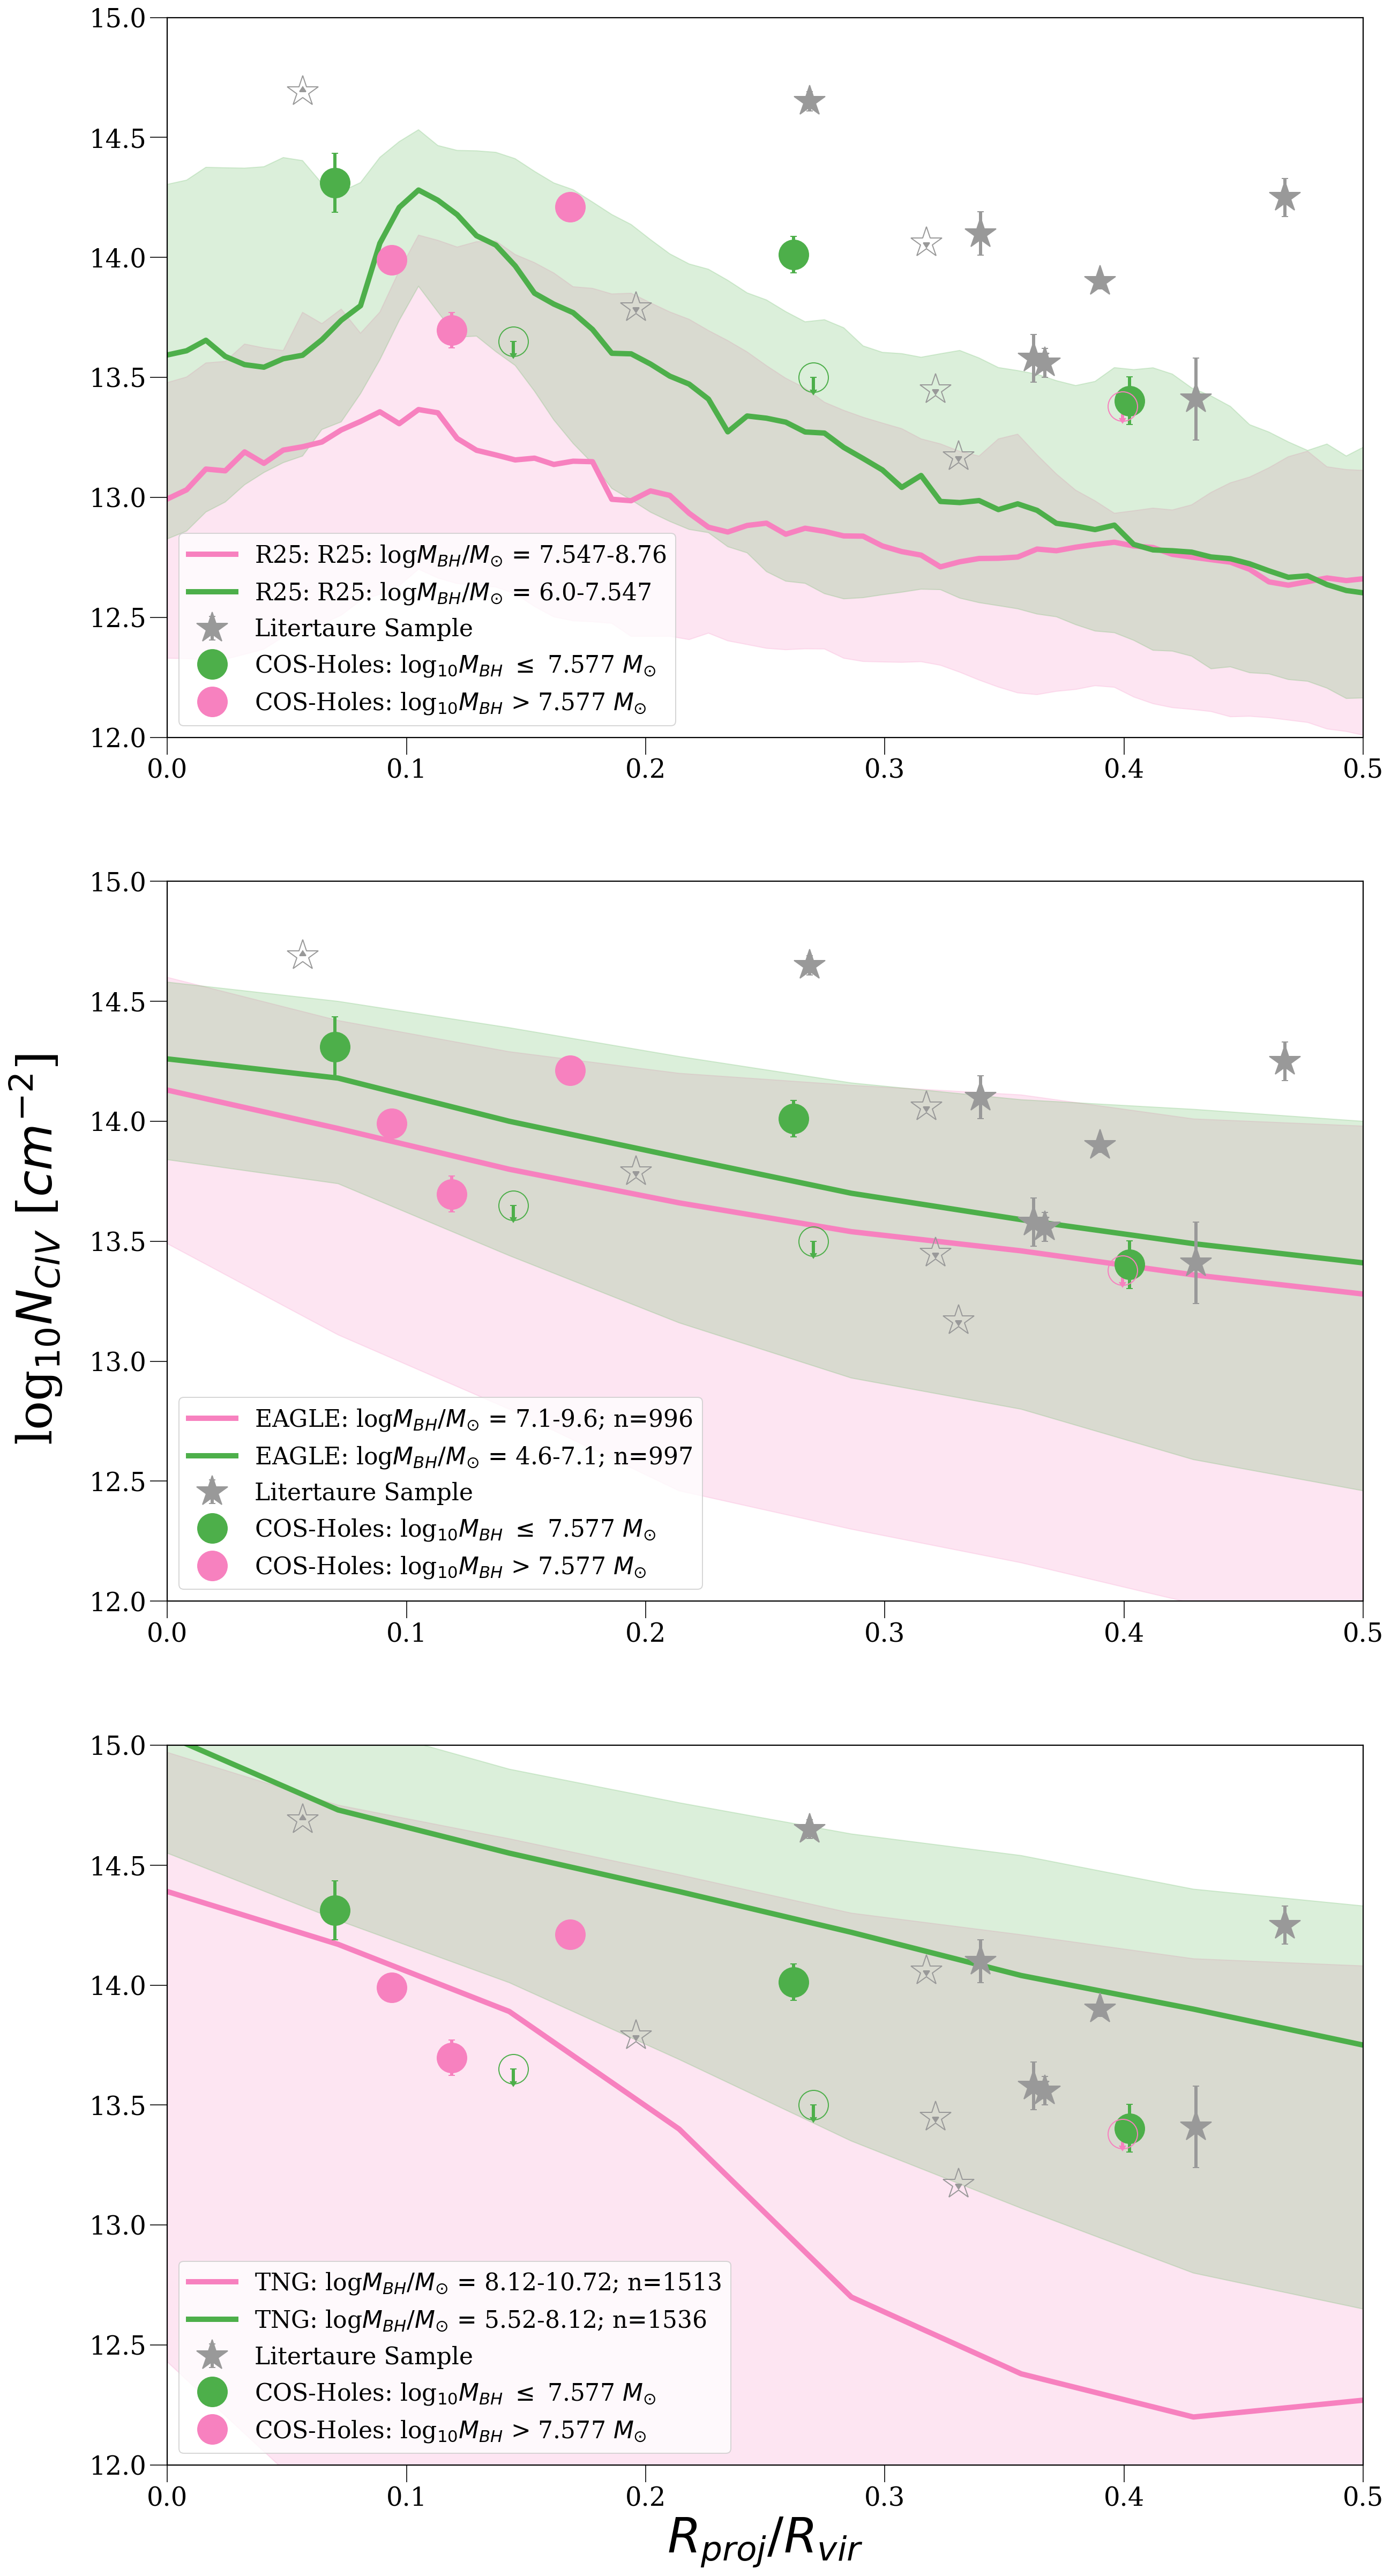

In [239]:
#Plotting NCIV vs R/Rvir     
fig, ax = plt.subplots(3, figsize=(20,42))

#PLOT 1

#######################################################

#R25

ax[0].fill_between(r25_rr['Rproj/Rvir'], hmbh_16['16per'], hmbh_84['84per'], alpha = 0.2, color = CB_color_cycle[3])
ax[0].plot(r25_rr['Rproj/Rvir'], hmbh_civ['logNciv'], c = CB_color_cycle[3], linewidth = 5, ls = '-',
         label = 'R25: R25: log$M_{BH}/M_{\odot}$ = 7.547-8.76')

ax[0].fill_between(r25_rr['Rproj/Rvir'], lmbh_16['16per'], lmbh_84['84per'], alpha = 0.2, color = CB_color_cycle[2])
ax[0].plot(r25_rr['Rproj/Rvir'], lmbh_civ['logNciv'], c = CB_color_cycle[2], linewidth = 5, ls = '-',
         label = 'R25: R25: log$M_{BH}/M_{\odot}$ = 6.0-7.547')


########################################################
#### LITERATURE SAMPLE 


########################################################

#Literature Sample 
    
ax[0].errorbar(coslit_det['Rproj/Rvir'][6:], coslit_det['N'][6:],yerr=coslit_det['sigN'][6:],
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, label='Litertaure Sample', ls='none', elinewidth=3)
    
ax[0].errorbar(coslit_uplim['Rproj/Rvir'][3:], coslit_uplim['N'][3:],yerr=coslit_uplim['sigN'][3:], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)

ax[0].errorbar(coslit_lolim['Rproj/Rvir'], coslit_lolim['N'],yerr=coslit_lolim['sigN'], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=3)

########################################################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"COS-Holes: log$_{10}M_{BH}$ $\leq$ 7.577 $M_{\odot}$", 
                                r"COS-Holes: log$_{10}M_{BH}$ > 7.577 $M_{\odot}$"]):
    
    ax[0].errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax[0].errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)
    

ax[0].legend(loc=3, fontsize=22)
#ax[0].set_xlabel(r"$R_{proj} [kpc]$", fontsize=45)
#ax[0].set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax[0].set_ylim(12, 15)
ax[0].set_xlim(0, 0.5)
#plt.savefig('Figures/nciv_r25_vs_rr.png')

########################################################
#PLOT 2

#EAGLE

ax[1].fill_between(df_rr_new_high['R/R200'], df_rr_new_high['16percentile'], df_rr_new_high['84percentile'], alpha = 0.2, color = CB_color_cycle[3])
ax[1].plot(df_rr_new_high['R/R200'], df_rr_new_high['median'], color = CB_color_cycle[3], lw = 5, label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 7.1-9.6; n=996')

ax[1].fill_between(df_rr_new_low['R/R200'], df_rr_new_low['16percentile'], df_rr_new_low['84percentile'], alpha = 0.2, color = CB_color_cycle[2])
ax[1].plot(df_rr_new_low['R/R200'], df_rr_new_low['median'], color = CB_color_cycle[2], lw = 5, label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 4.6-7.1; n=997')


########################################################
#### LITERATURE SAMPLE 


########################################################

#Literature Sample 
    
ax[1].errorbar(coslit_det['Rproj/Rvir'][6:], coslit_det['N'][6:],yerr=coslit_det['sigN'][6:],
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, label='Litertaure Sample', ls='none', elinewidth=3)
    
ax[1].errorbar(coslit_uplim['Rproj/Rvir'][3:], coslit_uplim['N'][3:],yerr=coslit_uplim['sigN'][3:], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)

ax[1].errorbar(coslit_lolim['Rproj/Rvir'], coslit_lolim['N'],yerr=coslit_lolim['sigN'], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=3)

########################################################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"COS-Holes: log$_{10}M_{BH}$ $\leq$ 7.577 $M_{\odot}$", 
                                r"COS-Holes: log$_{10}M_{BH}$ > 7.577 $M_{\odot}$"]):
    
    ax[1].errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax[1].errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax[1].legend(loc=3, fontsize=22)
#ax[0].set_xlabel(r"$R_{proj} [kpc]$", fontsize=45)
#ax[0].set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax[1].set_ylim(12, 15)
ax[1].set_xlim(0, 0.5)
    
########################################################
#PLOT 3

#TNG
    
ax[2].fill_between(df_rr_new_hightng['R/R200'], df_rr_new_hightng['16percentile'], df_rr_new_hightng['84percentile'], alpha = 0.2, color = CB_color_cycle[3])
ax[2].plot(df_rr_new_hightng['R/R200'], df_rr_new_hightng['median'], color = CB_color_cycle[3], lw = 5, label = 'TNG: log$M_{BH}/M_{\odot}$ = 8.12-10.72; n=1513')

ax[2].fill_between(df_rr_new_lowtng['R/R200'], df_rr_new_lowtng['16percentile'], df_rr_new_lowtng['84percentile'], alpha = 0.2, color = CB_color_cycle[2])
ax[2].plot(df_rr_new_lowtng['R/R200'], df_rr_new_lowtng['median'], color = CB_color_cycle[2], lw = 5, label = 'TNG: log$M_{BH}/M_{\odot}$ = 5.52-8.12; n=1536')
    

########################################################
#### LITERATURE SAMPLE 


########################################################

#Literature Sample 
    
ax[2].errorbar(coslit_det['Rproj/Rvir'][6:], coslit_det['N'][6:],yerr=coslit_det['sigN'][6:],
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, label='Litertaure Sample', ls='none', elinewidth=3)
    
ax[2].errorbar(coslit_uplim['Rproj/Rvir'][3:], coslit_uplim['N'][3:],yerr=coslit_uplim['sigN'][3:], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)

ax[2].errorbar(coslit_lolim['Rproj/Rvir'], coslit_lolim['N'],yerr=coslit_lolim['sigN'], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=3)

########################################################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"COS-Holes: log$_{10}M_{BH}$ $\leq$ 7.577 $M_{\odot}$", 
                                r"COS-Holes: log$_{10}M_{BH}$ > 7.577 $M_{\odot}$"]):
    
    ax[2].errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax[2].errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)    
    

ax[2].legend(loc=3, fontsize=22)
ax[2].set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
#ax[0].set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax[2].set_ylim(12, 15)
ax[2].set_xlim(0, 0.5)

fig.text(0.04, 0.5, r"log$_{10}N_{CIV}$ [$cm^{-2}$]", ha='center', va='center', rotation='vertical', fontsize=45)
plt.show()

<>:15: DeprecationWarning: invalid escape sequence \o
<>:18: DeprecationWarning: invalid escape sequence \o
<>:61: DeprecationWarning: invalid escape sequence \o
<>:63: DeprecationWarning: invalid escape sequence \o
<>:103: DeprecationWarning: invalid escape sequence \o
<>:105: DeprecationWarning: invalid escape sequence \o
<>:154: DeprecationWarning: invalid escape sequence \o
<>:158: DeprecationWarning: invalid escape sequence \o
<>:201: DeprecationWarning: invalid escape sequence \o
<>:204: DeprecationWarning: invalid escape sequence \o
<>:244: DeprecationWarning: invalid escape sequence \o
<>:247: DeprecationWarning: invalid escape sequence \o
<>:15: DeprecationWarning: invalid escape sequence \o
<>:18: DeprecationWarning: invalid escape sequence \o
<>:61: DeprecationWarning: invalid escape sequence \o
<>:63: DeprecationWarning: invalid escape sequence \o
<>:103: DeprecationWarning: invalid escape sequence \o
<>:105: DeprecationWarning: invalid escape sequence \o
<>:154: Deprecatio

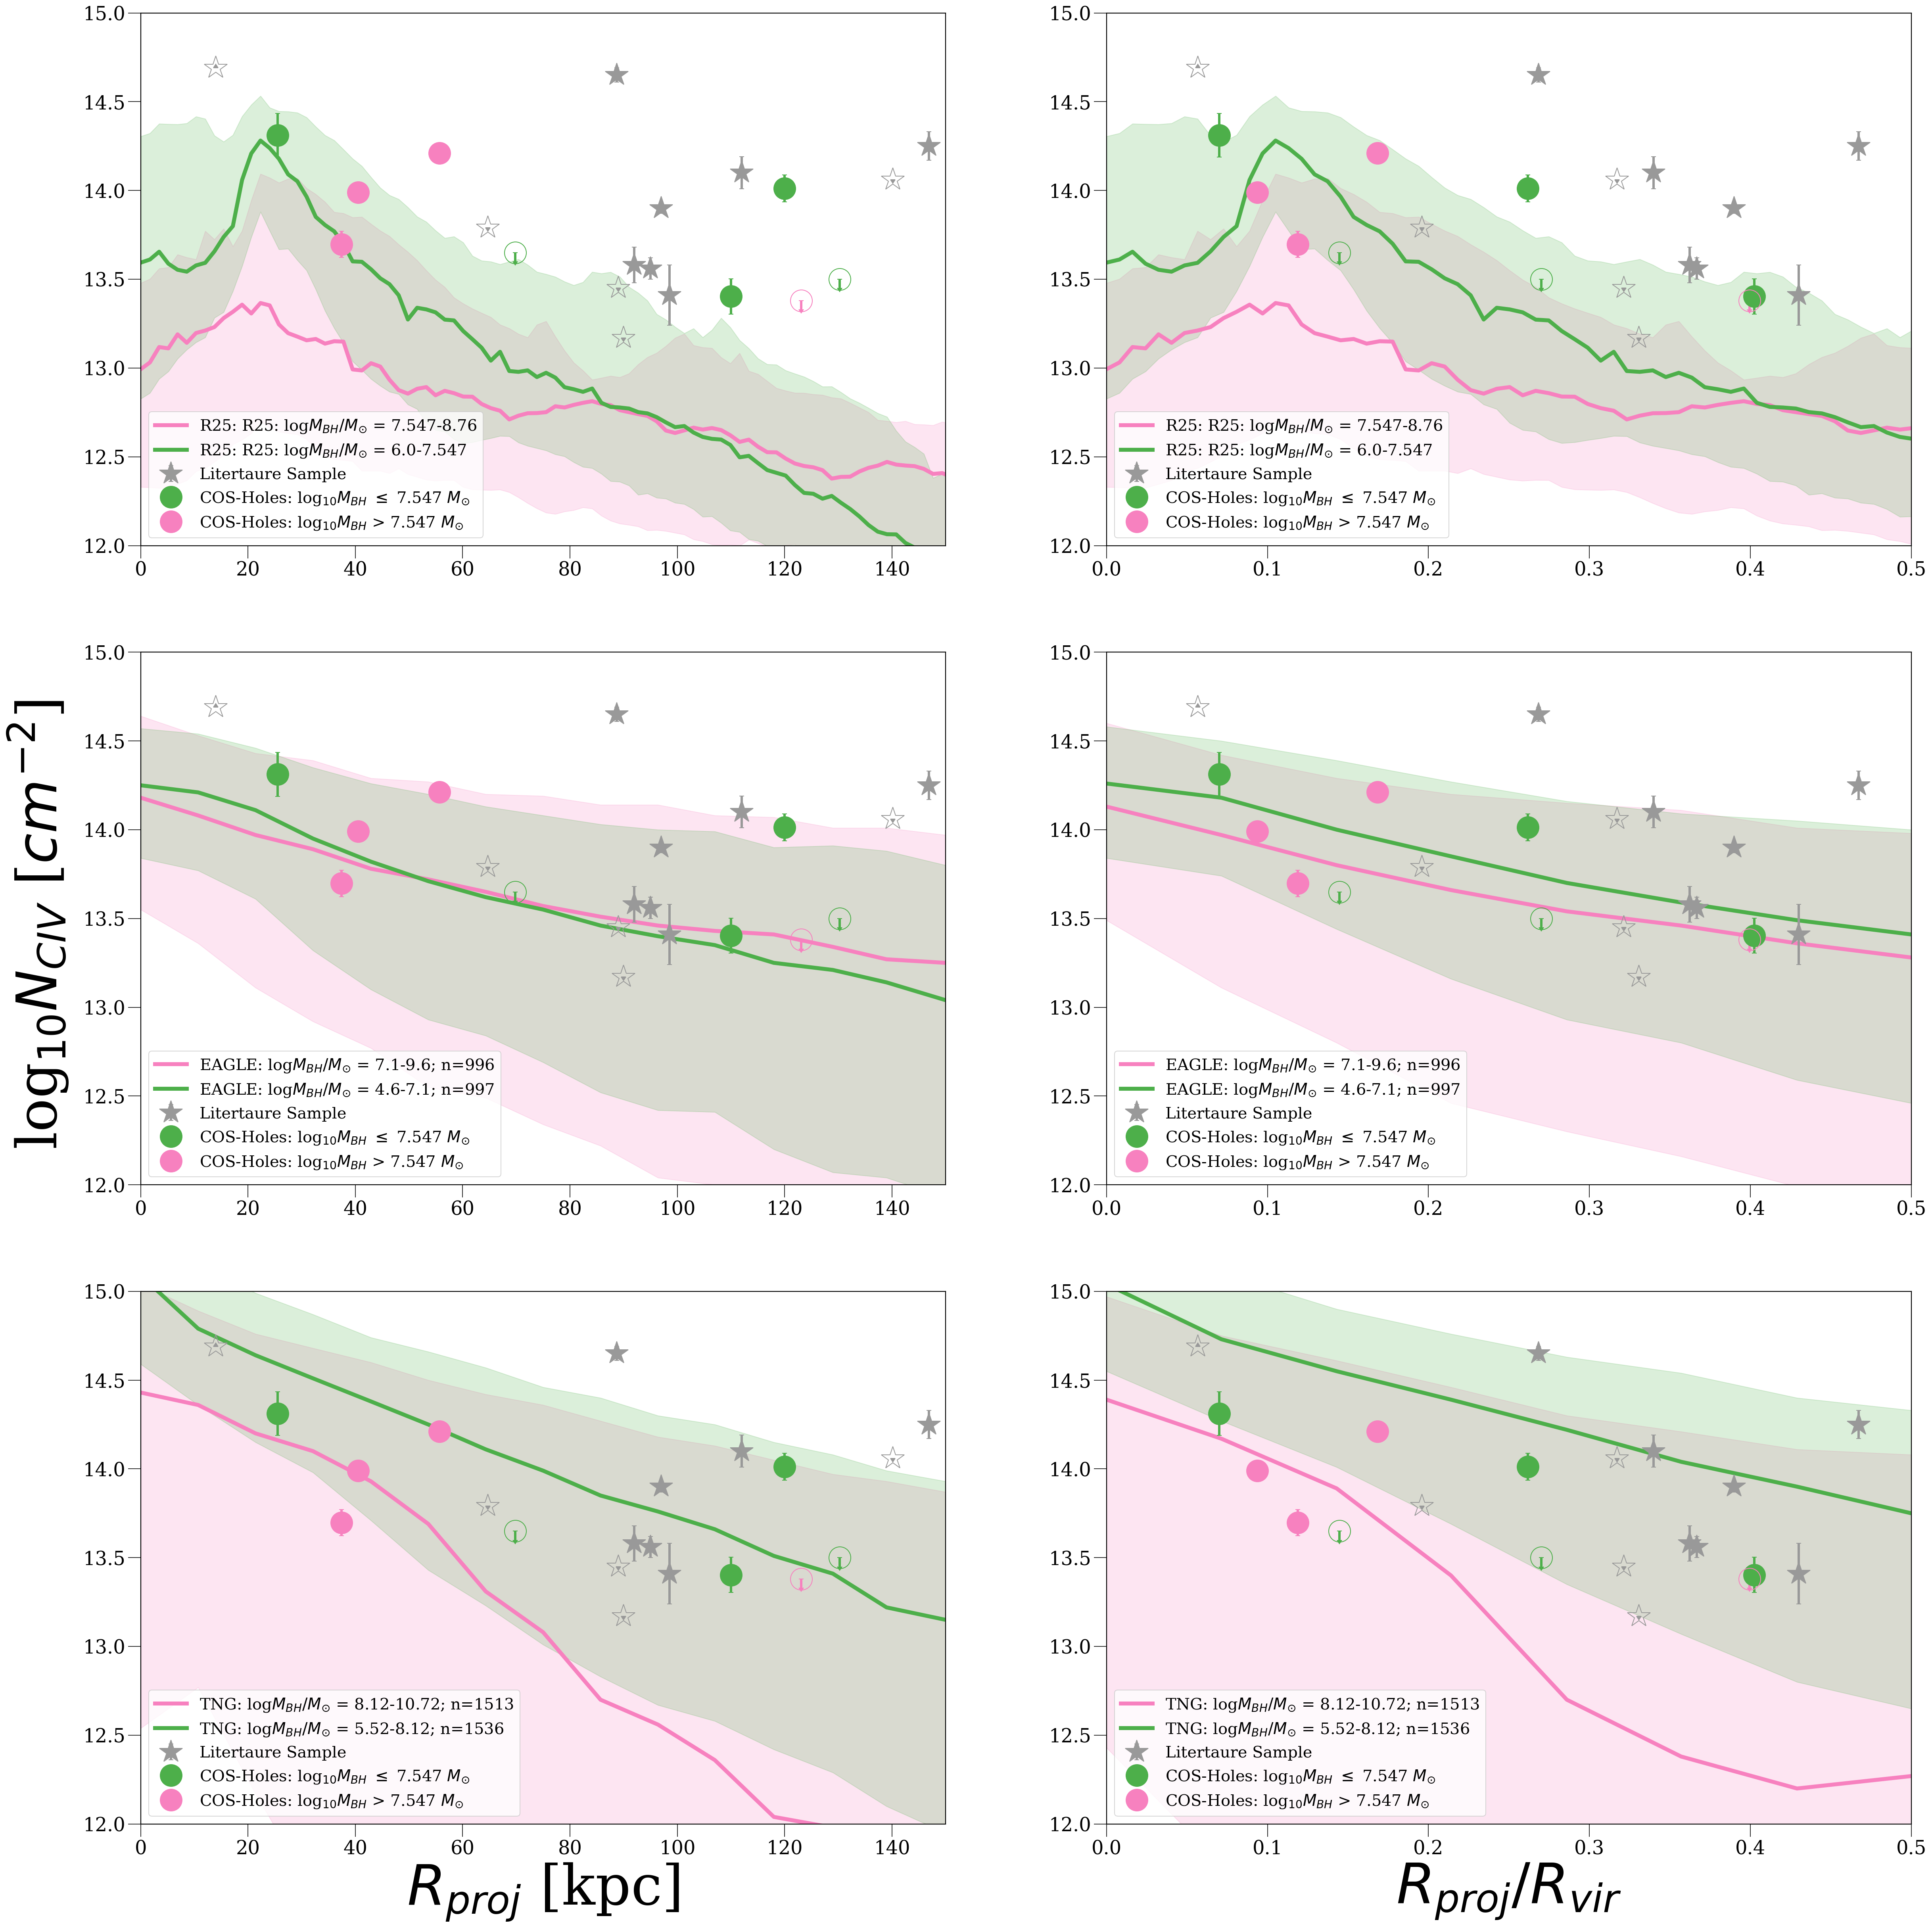

In [240]:
#Plotting NCIV vs R/Rvir     
fig, ax = plt.subplots(3,2, figsize=(40,42))
    #This one works wellish: 50,42

#######################################################

#PLOT 1

#######################################################

#R25

ax[0,0].fill_between(r25_r['Rproj'], hmbh_16['16per'], hmbh_84['84per'], alpha = 0.2, color = CB_color_cycle[3])
ax[0,0].plot(r25_r['Rproj'], hmbh_civ['logNciv'], c = CB_color_cycle[3], linewidth = 5, ls = '-',
         label = 'R25: R25: log$M_{BH}/M_{\odot}$ = 7.547-8.76')
ax[0,0].fill_between(r25_r['Rproj'], lmbh_16['16per'], lmbh_84['84per'], alpha = 0.2, color = CB_color_cycle[2])
ax[0,0].plot(r25_r['Rproj'], lmbh_civ['logNciv'], c = CB_color_cycle[2], linewidth = 5, ls = '-',
         label = 'R25: R25: log$M_{BH}/M_{\odot}$ = 6.0-7.547')


##################################
#### LITERATURE SAMPLE 

    
ax[0,0].errorbar(coslit_det['Rproj'][6:], coslit_det['N'][6:],yerr=coslit_det['sigN'][6:],
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, label='Litertaure Sample', ls='none', elinewidth=3)
    
ax[0,0].errorbar(coslit_uplim['Rproj'][3:], coslit_uplim['N'][3:],yerr=coslit_uplim['sigN'][3:], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)

ax[0,0].errorbar(coslit_lolim['Rproj'], coslit_lolim['N'],yerr=coslit_lolim['sigN'], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=3)

#############################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"COS-Holes: log$_{10}M_{BH}$ $\leq$ 7.547 $M_{\odot}$", 
                                r"COS-Holes: log$_{10}M_{BH}$ > 7.547 $M_{\odot}$"]):
    
    ax[0,0].errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax[0,0].errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)
    

ax[0,0].legend(loc=3, fontsize=20)
ax[0,0].set_ylim(12, 15)
ax[0,0].set_xlim(0, 150)


########################################################
#PLOT 2
#######################################################

#EAGLE

ax[1,0].fill_between(df_r_new_high['R(kpc)'], df_r_new_high['16percentile'], df_r_new_high['84percentile'], alpha = 0.2, color = CB_color_cycle[3])
ax[1,0].plot(df_r_new_high['R(kpc)'], df_r_new_high['median'], color = CB_color_cycle[3], lw = 5, label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 7.1-9.6; n=996')
ax[1,0].fill_between(df_r_new_low['R(kpc)'], df_r_new_low['16percentile'], df_r_new_low['84percentile'], alpha = 0.2, color = CB_color_cycle[2])
ax[1,0].plot(df_r_new_low['R(kpc)'], df_r_new_low['median'], color = CB_color_cycle[2], lw = 5, label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 4.6-7.1; n=997')


#################################
#### LITERATURE SAMPLE 
    
ax[1,0].errorbar(coslit_det['Rproj'][6:], coslit_det['N'][6:],yerr=coslit_det['sigN'][6:],
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, label='Litertaure Sample', ls='none', elinewidth=3)
    
ax[1,0].errorbar(coslit_uplim['Rproj'][3:], coslit_uplim['N'][3:],yerr=coslit_uplim['sigN'][3:], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)

ax[1,0].errorbar(coslit_lolim['Rproj'], coslit_lolim['N'],yerr=coslit_lolim['sigN'], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=3)

##################################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"COS-Holes: log$_{10}M_{BH}$ $\leq$ 7.547 $M_{\odot}$", 
                                r"COS-Holes: log$_{10}M_{BH}$ > 7.547 $M_{\odot}$"]):
    
    ax[1,0].errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax[1,0].errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax[1,0].legend(loc=3, fontsize=20)
ax[1,0].set_ylim(12, 15)
ax[1,0].set_xlim(0, 150)
    
########################################################
#PLOT 3
########################################################

#TNG
    
ax[2,0].fill_between(df_r_new_hightng['R(kpc)'], df_r_new_hightng['16percentile'], df_r_new_hightng['84percentile'], alpha = 0.2, color = CB_color_cycle[3])
ax[2,0].plot(df_r_new_hightng['R(kpc)'], df_r_new_hightng['median'], color = CB_color_cycle[3], lw = 5, label = 'TNG: log$M_{BH}/M_{\odot}$ = 8.12-10.72; n=1513')
ax[2,0].fill_between(df_r_new_lowtng['R(kpc)'], df_r_new_lowtng['16percentile'], df_r_new_lowtng['84percentile'], alpha = 0.2, color = CB_color_cycle[2])
ax[2,0].plot(df_r_new_lowtng['R(kpc)'], df_r_new_lowtng['median'], color = CB_color_cycle[2], lw = 5, label = 'TNG: log$M_{BH}/M_{\odot}$ = 5.52-8.12; n=1536')
    

##############################
#### LITERATURE SAMPLE 


##########################
    
ax[2,0].errorbar(coslit_det['Rproj'][6:], coslit_det['N'][6:],yerr=coslit_det['sigN'][6:],
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, label='Litertaure Sample', ls='none', elinewidth=3)
    
ax[2,0].errorbar(coslit_uplim['Rproj'][3:], coslit_uplim['N'][3:],yerr=coslit_uplim['sigN'][3:], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)

ax[2,0].errorbar(coslit_lolim['Rproj'], coslit_lolim['N'],yerr=coslit_lolim['sigN'], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=3)

##############################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"COS-Holes: log$_{10}M_{BH}$ $\leq$ 7.547 $M_{\odot}$", 
                                r"COS-Holes: log$_{10}M_{BH}$ > 7.547 $M_{\odot}$"]):
    
    ax[2,0].errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax[2,0].errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)    
    

ax[2,0].legend(loc=3, fontsize=20)
ax[2,0].set_xlabel(r"$R_{proj}$ [kpc]", fontsize=70)
ax[2,0].set_ylim(12, 15)
ax[2,0].set_xlim(0, 150)


#######################################################

#PLOT 4

#######################################################

#R25

ax[0,1].fill_between(r25_rr['Rproj/Rvir'], hmbh_16['16per'], hmbh_84['84per'], alpha = 0.2, color = CB_color_cycle[3])
ax[0,1].plot(r25_rr['Rproj/Rvir'], hmbh_civ['logNciv'], c = CB_color_cycle[3], linewidth = 5, ls = '-',
         label = 'R25: R25: log$M_{BH}/M_{\odot}$ = 7.547-8.76')

ax[0,1].fill_between(r25_rr['Rproj/Rvir'], lmbh_16['16per'], lmbh_84['84per'], alpha = 0.2, color = CB_color_cycle[2])
ax[0,1].plot(r25_rr['Rproj/Rvir'], lmbh_civ['logNciv'], c = CB_color_cycle[2], linewidth = 5, ls = '-',
         label = 'R25: R25: log$M_{BH}/M_{\odot}$ = 6.0-7.547')


##################################
#### LITERATURE SAMPLE 

    
ax[0,1].errorbar(coslit_det['Rproj/Rvir'][6:], coslit_det['N'][6:],yerr=coslit_det['sigN'][6:],
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, label='Litertaure Sample', ls='none', elinewidth=3)
    
ax[0,1].errorbar(coslit_uplim['Rproj/Rvir'][3:], coslit_uplim['N'][3:],yerr=coslit_uplim['sigN'][3:], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)

ax[0,1].errorbar(coslit_lolim['Rproj/Rvir'], coslit_lolim['N'],yerr=coslit_lolim['sigN'], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=3)

#############################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"COS-Holes: log$_{10}M_{BH}$ $\leq$ 7.547 $M_{\odot}$", 
                                r"COS-Holes: log$_{10}M_{BH}$ > 7.547 $M_{\odot}$"]):
    
    ax[0,1].errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax[0,1].errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)
    

ax[0,1].legend(loc=3, fontsize=20)
ax[0,1].set_ylim(12, 15)
ax[0,1].set_xlim(0, 0.5)


########################################################
#PLOT 5
#######################################################

#EAGLE

ax[1,1].fill_between(df_rr_new_high['R/R200'], df_rr_new_high['16percentile'], df_rr_new_high['84percentile'], alpha = 0.2, color = CB_color_cycle[3])
ax[1,1].plot(df_rr_new_high['R/R200'], df_rr_new_high['median'], color = CB_color_cycle[3], lw = 5, label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 7.1-9.6; n=996')

ax[1,1].fill_between(df_rr_new_low['R/R200'], df_rr_new_low['16percentile'], df_rr_new_low['84percentile'], alpha = 0.2, color = CB_color_cycle[2])
ax[1,1].plot(df_rr_new_low['R/R200'], df_rr_new_low['median'], color = CB_color_cycle[2], lw = 5, label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 4.6-7.1; n=997')


#################################
#### LITERATURE SAMPLE 
    
ax[1,1].errorbar(coslit_det['Rproj/Rvir'][6:], coslit_det['N'][6:],yerr=coslit_det['sigN'][6:],
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, label='Litertaure Sample', ls='none', elinewidth=3)
    
ax[1,1].errorbar(coslit_uplim['Rproj/Rvir'][3:], coslit_uplim['N'][3:],yerr=coslit_uplim['sigN'][3:], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)

ax[1,1].errorbar(coslit_lolim['Rproj/Rvir'], coslit_lolim['N'],yerr=coslit_lolim['sigN'], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=3)

##################################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"COS-Holes: log$_{10}M_{BH}$ $\leq$ 7.547 $M_{\odot}$", 
                                r"COS-Holes: log$_{10}M_{BH}$ > 7.547 $M_{\odot}$"]):
    
    ax[1,1].errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax[1,1].errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax[1,1].legend(loc=3, fontsize=20)
ax[1,1].set_ylim(12, 15)
ax[1,1].set_xlim(0, 0.5)
    
########################################################
#PLOT 6
########################################################

#TNG
    
ax[2,1].fill_between(df_rr_new_hightng['R/R200'], df_rr_new_hightng['16percentile'], df_rr_new_hightng['84percentile'], alpha = 0.2, color = CB_color_cycle[3])
ax[2,1].plot(df_rr_new_hightng['R/R200'], df_rr_new_hightng['median'], color = CB_color_cycle[3], lw = 5, label = 'TNG: log$M_{BH}/M_{\odot}$ = 8.12-10.72; n=1513')

ax[2,1].fill_between(df_rr_new_lowtng['R/R200'], df_rr_new_lowtng['16percentile'], df_rr_new_lowtng['84percentile'], alpha = 0.2, color = CB_color_cycle[2])
ax[2,1].plot(df_rr_new_lowtng['R/R200'], df_rr_new_lowtng['median'], color = CB_color_cycle[2], lw = 5, label = 'TNG: log$M_{BH}/M_{\odot}$ = 5.52-8.12; n=1536')
    

##############################
#### LITERATURE SAMPLE 


##########################
    
ax[2,1].errorbar(coslit_det['Rproj/Rvir'][6:], coslit_det['N'][6:],yerr=coslit_det['sigN'][6:],
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, label='Litertaure Sample', ls='none', elinewidth=3)
    
ax[2,1].errorbar(coslit_uplim['Rproj/Rvir'][3:], coslit_uplim['N'][3:],yerr=coslit_uplim['sigN'][3:], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=3)

ax[2,1].errorbar(coslit_lolim['Rproj/Rvir'], coslit_lolim['N'],yerr=coslit_lolim['sigN'], 
                capsize = 3, c = CB_color_cycle[6], marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=3)

##############################
    
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"COS-Holes: log$_{10}M_{BH}$ $\leq$ 7.547 $M_{\odot}$", 
                                r"COS-Holes: log$_{10}M_{BH}$ > 7.547 $M_{\odot}$"]):
    
    ax[2,1].errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax[2,1].errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)    
    

ax[2,1].legend(loc=3, fontsize=20)
ax[2,1].set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=70)
ax[2,1].set_ylim(12, 15)
ax[2,1].set_xlim(0, 0.5)
#ax[2,1].set_xticklabels(sum_ch["Rproj/Rvir"], fontsize=40)


fig.text(0.08, 0.5, r"log$_{10}N_{CIV}$ [$cm^{-2}$]", ha='center', va='center', rotation='vertical', fontsize=70)
plt.show()

## Kaplan Meier Fits 

In [207]:
#Splitting COSlit sample up so that I can make the fits for each 

coslit_lowrr = coslit.loc[(coslit['Rproj/Rvir'] <= 0.25)]

coslit_highrr = coslit.loc[(coslit['Rproj/Rvir'] > 0.25)]

In [208]:
#Got this code from Jess which this is from CGM^2 stuff I think.... 
    #Need to get more information about this for when/if we include in the paper 

# Defining functions for plotting
def plot_KM_lmbh(label, c, ax, lw, column_density=False):
    # Create semi-transparent Kaplan Meier object
    kmf = KaplanMeierFitter(alpha=0.32) #alpha is the value associate with the confidence intervals 

    # Select galaxies within rho/rvir limit
    #df = df#[df['rho_rvir'] < max_rhorvir] #I don't need the limit stuff 
    X = coslit_low['N'] # List of col densities
    Y = coslit_low['uplim'] # List of (non)detections, 0 for nondetect, 1 for detect

    # Calculates the Kaplan-Meier curve
    kmf.fit_left_censoring(X, event_observed=Y, label=label)
    # Plots the Kaplan-Meier curve on axis ax with color c
    kmf.plot(ax=ax, color=c, lw=lw)
    
    
# Defining functions for plotting
def plot_KM_hmbh(label, c, ax, lw, column_density=False):
    # Create semi-transparent Kaplan Meier object
    kmf = KaplanMeierFitter(alpha=0.32)

    # Select galaxies within rho/rvir limit
    #df = df#[df['rho_rvir'] < max_rhorvir] #I don't need the limit stuff 
    X = coslit_high['N'] # List of col densities
    Y = coslit_high['uplim'] # List of (non)detections, 0 for nondetect, 1 for detect

    # Calculates the Kaplan-Meier curve
    kmf.fit_left_censoring(X, event_observed=Y, label=label)
    # Plots the Kaplan-Meier curve on axis ax with color c
    kmf.plot(ax=ax, color=c, lw=lw)

In [209]:
#Got this code from Jess which this is from CGM^2 stuff I think.... 
    #Need to get more information about this for when/if we include in the paper 

# Defining functions for plotting
def plot_KM_inner_rr(label, c, ax, lw, column_density=False):
    # Create semi-transparent Kaplan Meier object
    kmf = KaplanMeierFitter(alpha=0.32)

    # Select galaxies within rho/rvir limit
    #df = df#[df['rho_rvir'] < max_rhorvir] #I don't need the limit stuff 
    X = coslit_low['Rproj/Rvir'] # List of col densities
    Y = coslit_low['uplim'] # List of (non)detections, 0 for nondetect, 1 for detect

    # Calculates the Kaplan-Meier curve
    kmf.fit_left_censoring(X, event_observed=Y, label=label)
    # Plots the Kaplan-Meier curve on axis ax with color c
    kmf.plot(ax=ax, color=c, lw=lw)
    
    
# Defining functions for plotting
def plot_KM_outer_rr(label, c, ax, lw, column_density=False):
    # Create semi-transparent Kaplan Meier object
    kmf = KaplanMeierFitter(alpha=0.32)

    # Select galaxies within rho/rvir limit
    #df = df#[df['rho_rvir'] < max_rhorvir] #I don't need the limit stuff 
    X = coslit_high['Rproj/Rvir'] # List of col densities
    Y = coslit_high['uplim'] # List of (non)detections, 0 for nondetect, 1 for detect

    # Calculates the Kaplan-Meier curve
    kmf.fit_left_censoring(X, event_observed=Y, label=label)
    # Plots the Kaplan-Meier curve on axis ax with color c
    kmf.plot(ax=ax, color=c, lw=lw)

/Users/samgarza/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:446: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,
/Users/samgarza/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:446: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,
/Users/samgarza/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:446: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,
/Users/samgarza/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:446: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,


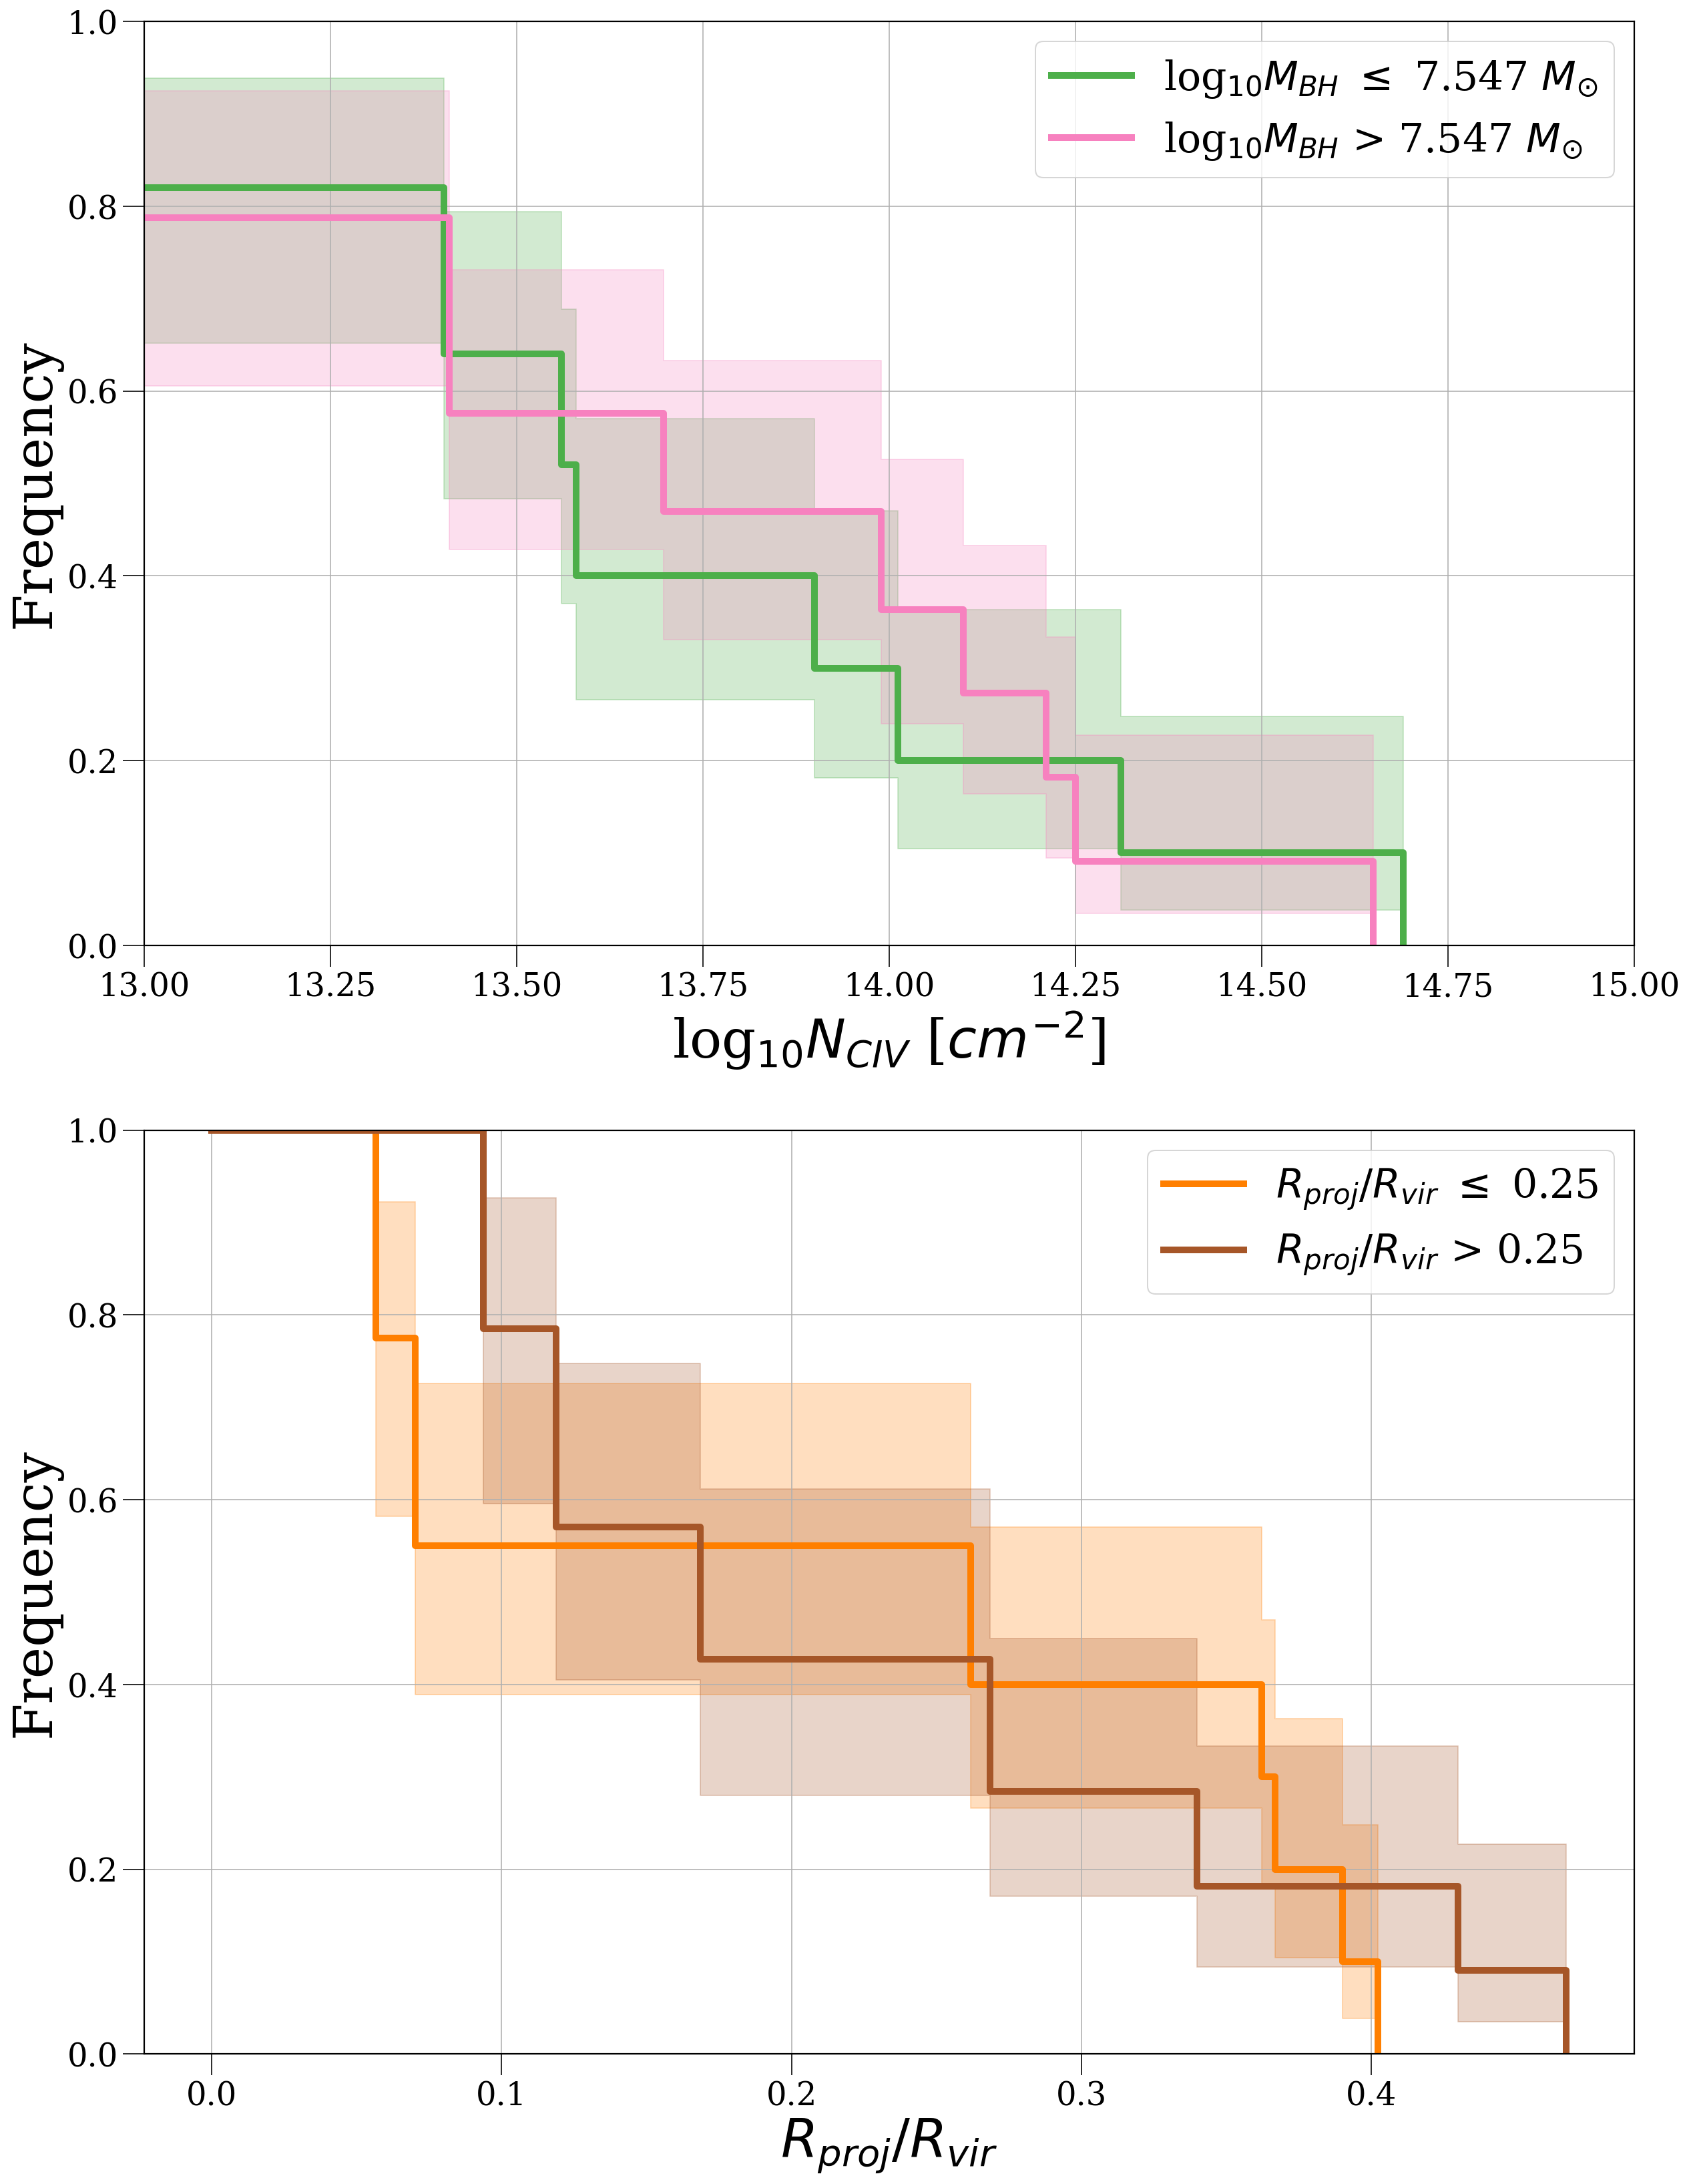

In [210]:
# Create the figure
fig, ax = plt.subplots(2,1, figsize=(20, 28))
#fig1.set_size_inches(24,7.5)
#fig1.patch.set_facecolor('white')

# Kaplan Meier plot - NCIV for different MBH sample
# Making/plotting a KM curve for low MBH sample data points 
plot_KM_lmbh(label=r"log$_{10}M_{BH}$ $\leq$ 7.547 $M_{\odot}$",
            c=CB_color_cycle[2], ax=ax[0], lw = 5, column_density=False)

# Making/plotting a KM curve for highMBH sample data points
plot_KM_hmbh(label=r"log$_{10}M_{BH}$ > 7.547 $M_{\odot}$",
            c= CB_color_cycle[3], ax=ax[0], lw = 5, column_density=False)

ax[0].set_ylim(ymin=0, ymax=1)
ax[0].set_xlim(xmin=13, xmax=15)
ax[0].set_xlabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]")
ax[0].set_ylabel("Frequency")
ax[0].grid()
ax[0].legend(fontsize=30)
#ax[0].tick_params(axis='x', labelsize=25)
#ax[0].tick_params(axis='y', labelsize=25)


# Kaplan Meier plot - R/Rvir for different MBH sample 
# Making/plotting a KM curve for inner region <= 0.2
plot_KM_inner_rr(label=r"$R_{proj}/R_{vir}$ $\leq$ 0.25",
            c=CB_color_cycle[1], ax=ax[1], lw = 5, column_density=False)

# Making/plotting a KM curve for outer region > 0.2 
plot_KM_outer_rr(label=r"$R_{proj}/R_{vir}$ > 0.25",
            c= CB_color_cycle[4], ax=ax[1], lw = 5, column_density=False)

ax[1].set_xlabel(r'$R_{proj}/R_{vir}$')
ax[1].set_ylim(ymin=0, ymax=1)
ax[1].set_ylabel("Frequency")
ax[1].grid()
ax[1].legend(fontsize=30)
#ax[1].tick_params(axis='x', labelsize=25)
#ax[1].tick_params(axis='y', labelsize=25)
plt.show()